# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimesions: (738, 1280, 3)


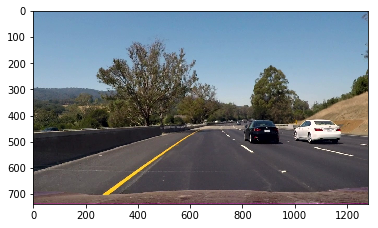

In [2]:
#reading in an image
image = mpimg.imread('test_images/vlcsnap-00001.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [45]:
import math
history_avg_left_xposition=[] 
history_avg_left_yposition=[]
history_avg_right_xposition=[]
history_avg_right_yposition=[]
history_slope_right=[]
history_slope_left=[]
counting =0

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    sum_right_line = 0
    sum_left_line = 0
    num_right_line = 0
    num_left_line = 0
    avg_right_line = 0
    sum_right_xposition = 0
    sum_right_yposition = 0
    sum_left_xposition = 0
    sum_left_yposition = 0
    
    right_array = []
    del_right_array = []
    left_array = []
    del_left_array = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            #drawing all lines out
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            #define acceptable slope range
            middle_num = 0.65 
            range_for_middle_num = 0.15
            
            #I try to get the slope value
            slope = ((y2-y1)/(x2-x1))
            #then seperate the left/right ones and abandon horizontal lines or over tilt lines
            if slope > 0 and x1 > (img.shape[1]/2) and x2 > (img.shape[1]/2) : #possible right lines
                if  middle_num-range_for_middle_num < abs(slope) < middle_num+range_for_middle_num :
                    #print('right slope is ',((y2-y1)/(x2-x1)))
                    sum_right_line += slope
                    num_right_line += 1
                    right_array.append([x1,y1])
                    right_array.append([x2,y2])
                    sum_right_xposition += (x1 + x2)
                    sum_right_yposition += (y1 + y2)
                    
                    #cv2.line(img, (x1, y1), (x2, y2), [0,0,255], 10)
                    
            elif slope < 0: #possible left lines
                
                if  middle_num-range_for_middle_num < abs(slope) < middle_num+range_for_middle_num and x1 < (img.shape[1]/2) and x2 < (img.shape[1]/2):
                    print('left slope is ',((y2-y1)/(x2-x1)))
                    print('slope=',slope)
                    sum_left_line += slope
                    num_left_line += 1
                    left_array.append([x1,y1])
                    left_array.append([x2,y2])
                    sum_left_xposition += (x1 + x2)
                    sum_left_yposition += (y1 + y2)
                    #cv2.line(img, (x1, y1), (x2, y2), [0,0,255], 10)
                   
    
    #print('slope is ',((y2-y1)/(x2-x1)))
            
    #average slope calculation
    if(num_right_line !=0 and num_left_line != 0):
        avg_slope_right = sum_right_line/num_right_line
        avg_slope_left = sum_left_line/num_left_line
        avg_right_xposition = sum_right_xposition/(num_right_line*2)
        avg_right_yposition = sum_right_yposition/(num_right_line*2)
        avg_left_xposition = sum_left_xposition / (num_left_line*2)
        avg_left_yposition = sum_left_yposition / (num_left_line*2)
    else: # no left or right line found , then use previous value to contiuous
        avg_left_xposition = history_avg_left_xposition[len(history_avg_left_xposition)-1]
        avg_left_yposition = history_avg_left_yposition[len(history_avg_left_yposition)-1]
        avg_right_xposition = history_avg_right_xposition[len(history_avg_right_xposition)-1]
        avg_right_yposition = history_avg_right_yposition[len(history_avg_right_yposition)-1]
        avg_slope_right = history_slope_right[len(history_slope_right)-1]
        avg_slope_left = history_slope_left[len(history_slope_left)-1]
    
    
    #check and decide if this pic is same video with previous one , it should be here to check
    # This reason why after third pics(no more now), left green line is tilt , is that history sum up first second and thrid left x y position all together.
    # so we need to check if this pic is same video with previous one.
    if(len(history_avg_left_xposition)!=0): # not first image of one video
        print('previous avg_left xposition is ',history_avg_left_xposition[len(history_avg_left_xposition)-1])
        if(abs(avg_left_xposition - history_avg_left_xposition[len(history_avg_left_xposition)-1]) > 20 or abs(avg_right_xposition - history_avg_right_xposition[len(history_avg_right_xposition)-1]) > 20):
            print('history reset !!!!!!!!!!!!!!!!!')
            history_avg_left_xposition.clear()
            history_avg_left_xposition.clear()
            history_avg_left_yposition.clear()
            history_avg_right_xposition.clear()
            history_avg_right_yposition.clear()
            history_slope_right.clear()
            history_slope_left.clear()
            counting =0
    
    
    
    history_slope_right.append(avg_slope_right)
    history_slope_left.append(avg_slope_left)

    
    print('avg left position is x=',avg_left_xposition,' y= ',avg_left_yposition )
    print('avg right slope is x=',avg_slope_right,' avg left slope= ',avg_slope_left )
    
    
    right_array.sort(reverse=True)
    left_array.sort(reverse=True)
    # for further delete some irrelevant points 
    for i in range(len(right_array)):
        #print('i is ',i,' right array i0 is ',right_array[i][0],'i1 is ', right_array[i][1])
        if (abs(right_array[i][0]-avg_right_xposition) > img.shape[1]/96*25) or (abs(right_array[i][1]-avg_right_yposition) > img.shape[0]*2/9): 
            del_right_array.append(i)

    for i in range(len(left_array)):
        print('i is ',i,' left array x is ',left_array[i][0],'y is ', left_array[i][1])
        if (abs(left_array[i][0]-avg_left_xposition) > img.shape[1]/96*25) or (abs(left_array[i][1]-avg_left_yposition) > img.shape[0]*2/9): 
            del_left_array.append(i)
    
    
    # for deleting some point are not in the descendant order
    
    for i in range(0,len(right_array)-2,1):
        #print ('new-right i is ', i,'i0= ',right_array[i][0],' i+1 0=',right_array[i+1][0],' i+2 0=',right_array[i+2][0] )
        if (right_array[i][1]-right_array[i+1][1]<-3) and (right_array[i][1]-right_array[i+2][1]<-3):
            del_right_array.append(i+1)
            del_right_array.append(i+2)
    for i in range(0,len(left_array)-2,1):
        print ('new left i is ', i,'i0= ',left_array[i][0],' i+1 0=',left_array[i+1][0],' i+2 0=',left_array[i+2][0] )
        if (left_array[i][1]-left_array[i+1][1]>3) and (left_array[i][1]-left_array[i+2][1]>3):
            del_left_array.append(i+1)
            del_left_array.append(i+2)
    
    
    
    
        
    #print('del array is ', del_right_array)
    # re-arrange array
    new_del_right_array = sorted(set(del_right_array))
    new_del_left_array = sorted(set(del_left_array))
    print('del left array is ', new_del_left_array)
    del_right_array.sort()
    del_left_array.sort()
    for v in reversed(new_del_right_array):
        #print('v is ', v)
        del right_array[v]
    for v in reversed(new_del_left_array):
        print('new del left v is ', v)
        del left_array[v]
    
    #print('avg right slope is ',avg_slope_right)
    #print('avg left slope is ',avg_slope_left)
    #print('right array is ', right_array)
    #right_x1_position = int(round((right_array[0][0]+right_array[1][0])/2))
    
    if(len(right_array) <= 0):
        right_x1_position = avg_right_xposition
    else:
        right_x1_position = int(round((right_array[0][0]+right_array[1][0])/2))
        
    last_index_left_array = len(left_array)-1
    print('last index left array is',last_index_left_array)
    if(last_index_left_array < 0):
        left_x1_position = avg_left_xposition
    else:
        left_x1_position = int(round((left_array[last_index_left_array][0]+left_array[last_index_left_array-1][0])/2))
    
    #min_line_x_position = (right_x1_position + left_x1_position)/2
    min_line_x_position = img.shape[1]/2
    print('min line is ', min_line_x_position)
      
    
    # calculate again the avg x y position for drawing final line
    sum_right_xposition = 0
    sum_right_yposition = 0
    sum_left_xposition = 0
    sum_left_yposition = 0
    for i in range(len(right_array)):
        sum_right_xposition += right_array[i][0]
        sum_right_yposition += right_array[i][1]
        
    for i in range(len(left_array)):
        sum_left_xposition += left_array[i][0]
        sum_left_yposition += left_array[i][1]
      
    if(len(right_array)==0):
        avg_right_xposition = history_avg_right_xposition[len(history_avg_right_xposition)-1]
        avg_right_yposition = history_avg_right_yposition[len(history_avg_right_yposition)-1]
    else:
        avg_right_xposition = sum_right_xposition/(len(right_array))
        avg_right_yposition = sum_right_yposition/(len(right_array))
    
    if(len(left_array)==0):
        avg_left_xposition = history_avg_left_xposition[len(history_avg_left_xposition)-1]
        avg_left_yposition = history_avg_left_yposition[len(history_avg_left_yposition)-1]
    else:
        avg_left_xposition = sum_left_xposition/(len(left_array))
        avg_left_yposition = sum_left_yposition/(len(left_array))
    
    
    print('avg left x position= ',avg_left_xposition)
    print('avg left y position= ',avg_left_yposition)
    #After checking each avg x y position, I found that sometimes there are not enough points to have avg stable x y position
    #Need a filter to filter out such situation


    
    history_avg_left_xposition.append(avg_left_xposition)
    history_avg_left_yposition.append(avg_left_yposition)
    avg_leftx_his_all = sum(history_avg_left_xposition)/len(history_avg_left_xposition)
    avg_lefty_his_all = sum(history_avg_left_yposition)/len(history_avg_left_yposition)
    
    
    print('length of history_avg_left_xposition',len(history_avg_left_xposition))
    print('length of history_avg_left_yposition',len(history_avg_left_yposition))
    print('avg leftx his all=',avg_leftx_his_all)
    print('avg lefty his all=',avg_lefty_his_all)
    
    if(abs(avg_left_xposition - avg_leftx_his_all)>img.shape[1]/192):
        print('leftx')
        avg_left_xposition = avg_leftx_his_all
    if(abs(avg_left_yposition - avg_lefty_his_all)>img.shape[0]/192):
        print('lefty')
        avg_left_yposition = avg_lefty_his_all
        
    ##### still need right filteravg_his_slope_right
    history_avg_right_xposition.append(avg_right_xposition)
    history_avg_right_yposition.append(avg_right_yposition)
    avg_rightx_his_all = sum(history_avg_right_xposition)/len(history_avg_right_xposition)
    avg_righty_his_all = sum(history_avg_right_yposition)/len(history_avg_right_yposition)
    if(abs(avg_right_xposition - avg_rightx_his_all)>img.shape[1]/192):
        #print('leftx')
        avg_right_xposition = avg_rightx_his_all
    if(abs(avg_right_yposition - avg_righty_his_all)>img.shape[0]/192):
        #print('lefty')
        avg_right_yposition = avg_righty_his_all
    
    #calculate the average slope for history each frame
    if(len(history_slope_left) != 0):
        avg_his_slope_left = sum(history_slope_left)/len(history_slope_left)
        avg_his_slope_right = sum(history_slope_right)/len(history_slope_right)
    else:
        avg_his_slope_left = sum(history_slope_left)
        avg_his_slope_right = sum(history_slope_right)
    
    
    
    
    last_index_right_array = len(right_array)-1
    last_index_left_array = len(left_array)-1
    
    #calculate  points for slope
    final_x1_right=right_x1_position
    if(len(right_array)==0):
        final_y1_right = avg_right_yposition
    else:
        final_y1_right=right_array[0][1]
    
    final_y2_right=int(round(avg_right_yposition))
    final_x2_right=int(round(avg_right_xposition))
    
    final_x1_left=left_x1_position
    if(last_index_left_array < 0):
        final_y1_left = avg_left_yposition
    else:
        final_y1_left=left_array[last_index_left_array][1] 
    
    final_y2_left=int(round(avg_left_yposition))
    final_x2_left=int(round(avg_left_xposition))
    #print('final_x1_left=',final_x1_left,'avg_slope_left=',avg_slope_left,'final_x2_left=',final_x2_left)
    #print('final_y1_left=',final_y1_left,'avg_slope_right=',avg_slope_right,'final_y2_left=',final_y2_left)
    print('final_x1_right=',final_x1_right,'avg_slope_right=',avg_slope_right,'final_x2_right=',final_x2_right)
    print('final_y1_right=',final_y1_right,'avg_slope_right=',avg_slope_right,'final_y2_right=',final_y2_right)
    
    #calculate final extrapolated points for drawing
    if ((final_y1_right - img.shape[0]) < -(img.shape[0]/18)): 
        print('final_y1_right=',final_y1_right,'avg_slope_right=',avg_slope_right,'final_x1_right=',final_x1_right)
        final_x1_right = int(round((img.shape[0]-final_y1_right)/avg_his_slope_right+final_x1_right))
        final_y1_right = int(round(imshape[0]))
        
    if (final_y2_right - (img.shape[0]*16/27)) > (img.shape[0]/18):
        print('final_y2_right=',final_y2_right,'avg_slope_right=',avg_slope_right,'final_x2_right=',final_x2_right)
        final_x2_right = int(round((img.shape[0]*17/27)-final_y2_right)/avg_his_slope_right+final_x2_right)
        final_y2_right = int(round((img.shape[0]*17/27)))
    
    if (final_y1_left - img.shape[0])< -(img.shape[0]/18):
        #print('final_y1_left=',final_y1_left,'avg_slope_left=',avg_slope_left,'final_x1_left=',final_x1_left)
        final_x1_left = int(round((img.shape[0]-final_y1_left)/avg_his_slope_left+final_x1_left))
        final_y1_left = int(round(img.shape[0]))
        
    if (final_y2_left - (img.shape[0]*16/27)) > (img.shape[0]/18):
        #print('final_y2_left=',final_y2_left,'avg_slope_left=',avg_slope_left,'final_x2_left=',final_x2_left)
        final_x2_left = int(round((img.shape[0]*17/27)-final_y2_left)/avg_his_slope_left+final_x2_left)
        final_y2_left = int(round((img.shape[0]*17/27)))
    
    print('after extrapolated')
    print('final_x1_right=',final_x1_right,'avg_slope_right=',avg_slope_right,'final_x2_right=',final_x2_right)
    print('final_y1_right=',final_y1_right,'avg_slope_right=',avg_slope_right,'final_y2_right=',final_y2_right)
    #print('final_x1_left=',final_x1_left,'avg_slope_left=',avg_slope_left,'final_x2_left=',final_x2_left)
    #print('final_y1_left=',final_y1_left,'avg_slope_right=',avg_slope_right,'final_y2_left=',final_y2_left)
    #print('final x2=', final_x2,' final y2=', final_y2)
    cv2.line(img,(final_x1_right,final_y1_right),(final_x2_right,final_y2_right),[0,255,0],15) 
    cv2.line(img,(final_x1_left,final_y1_left),(final_x2_left,final_y2_left),[0,255,0],15)
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

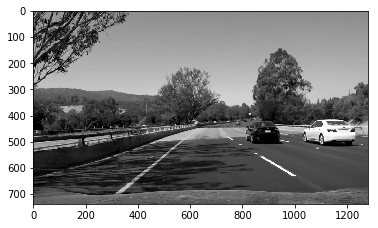

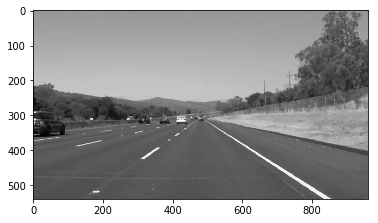

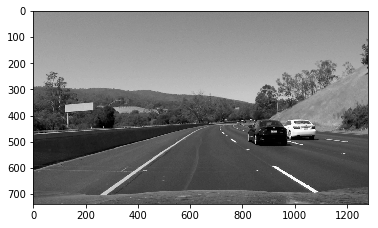

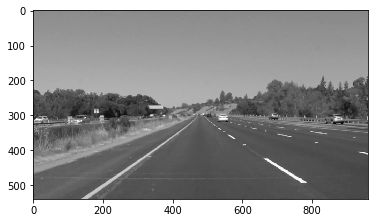

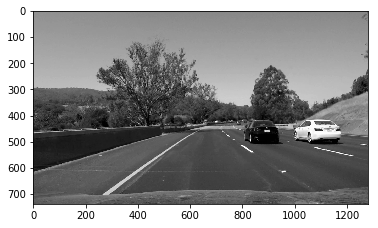

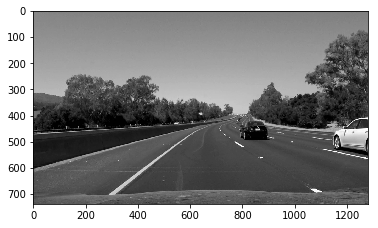

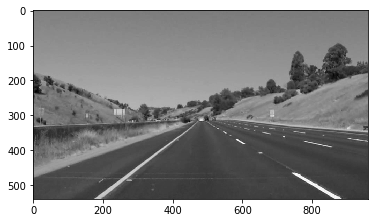

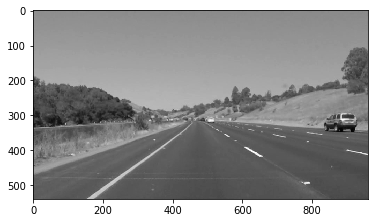

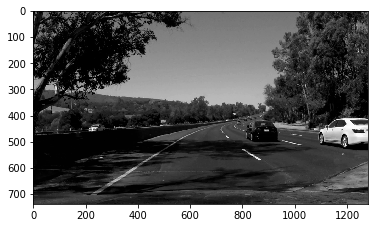

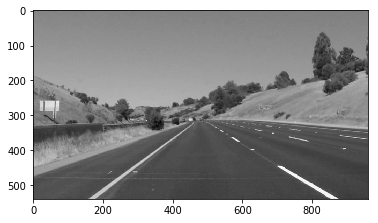

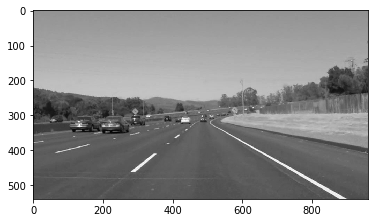

In [46]:
import os
files=os.listdir("test_images/")
gray_list=[]
image_list=[]
for v in files:
    image = mpimg.imread('test_images/'+v)
    image_list.append(image)
    gray = grayscale(image)
    plt.figure()
    plt.imshow(gray, cmap='gray')
    gray_list.append(gray)



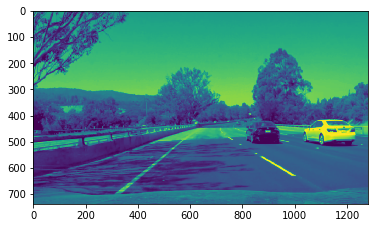

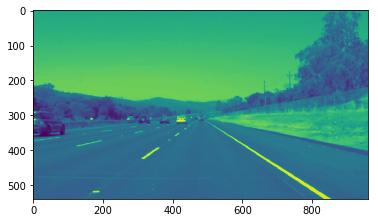

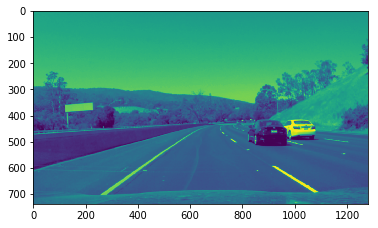

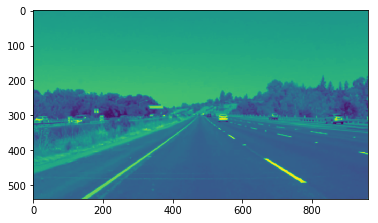

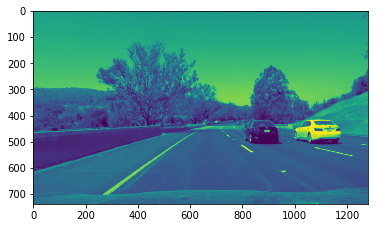

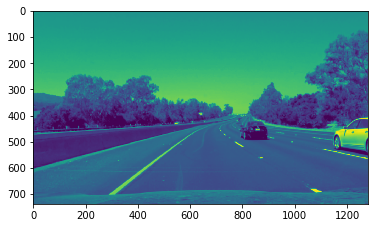

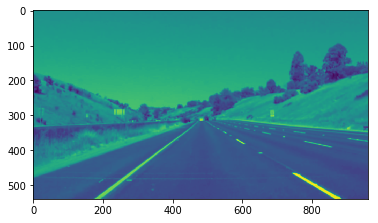

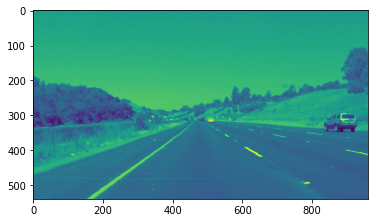

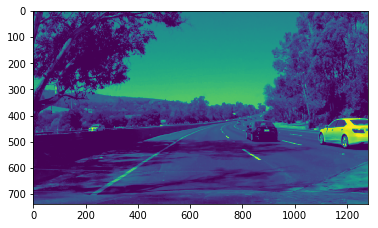

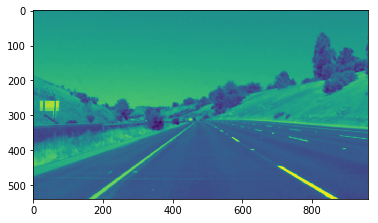

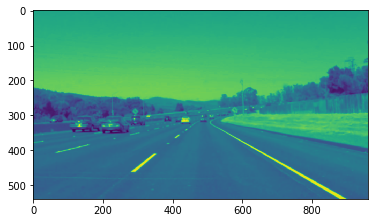

In [47]:
blur_gray_list=[]
for v in gray_list:
    blur_gray=gaussian_blur(v,5)
    plt.figure()
    plt.imshow(blur_gray)
    blur_gray_list.append(blur_gray)


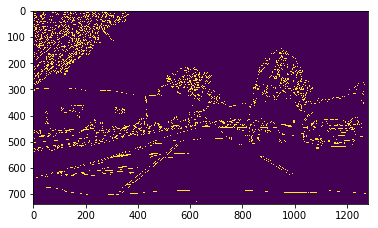

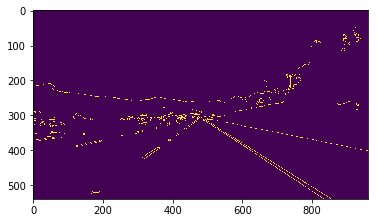

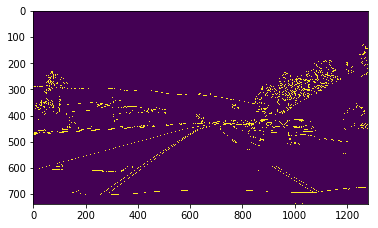

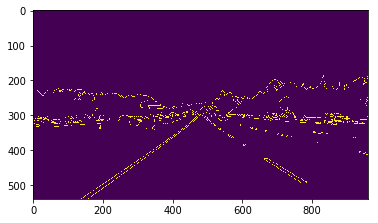

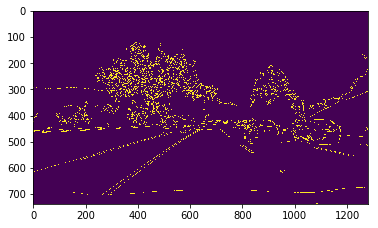

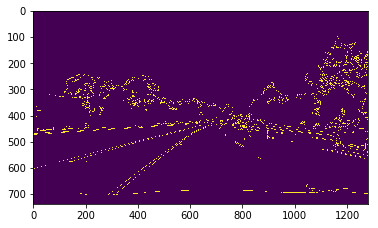

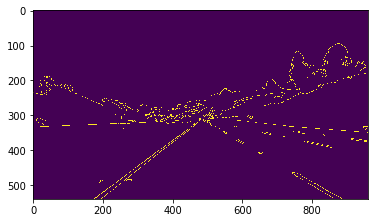

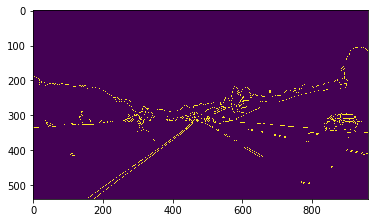

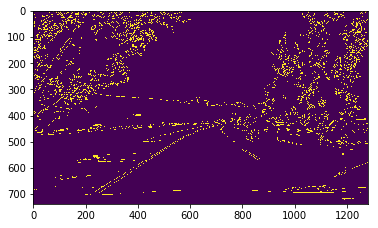

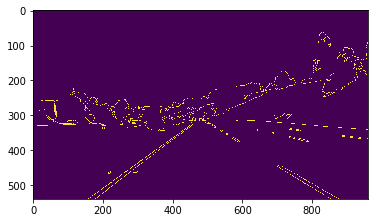

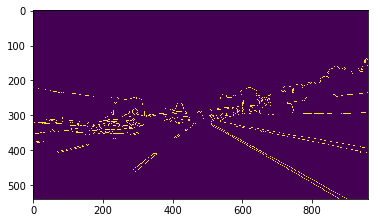

In [48]:
edges_list=[]
for v in blur_gray_list:
    edges = canny(v,8,180)
    plt.figure()
    plt.imshow(edges)
    edges_list.append(edges)



v.shape is  (738, 1280, 3)
v.shape is  (540, 960, 3)
v.shape is  (738, 1280, 3)
v.shape is  (540, 960, 3)
v.shape is  (738, 1280, 3)
v.shape is  (738, 1280, 3)
v.shape is  (540, 960, 3)
v.shape is  (540, 960, 3)
v.shape is  (738, 1280, 3)
v.shape is  (540, 960, 3)
v.shape is  (540, 960, 3)


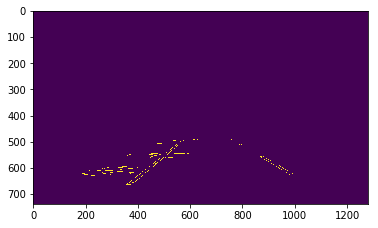

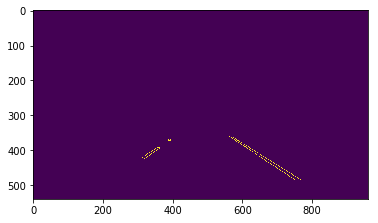

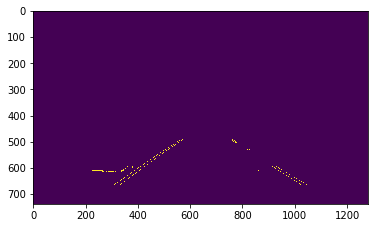

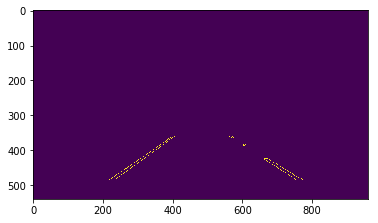

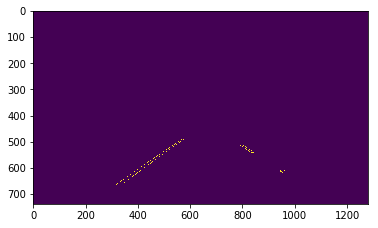

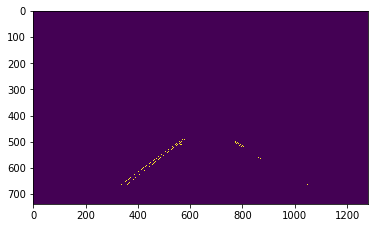

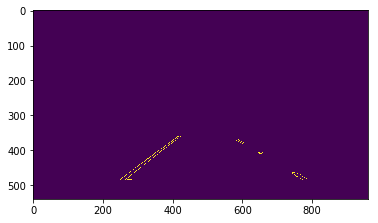

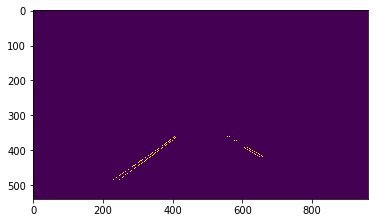

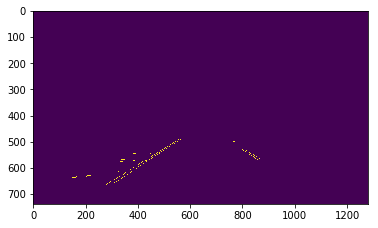

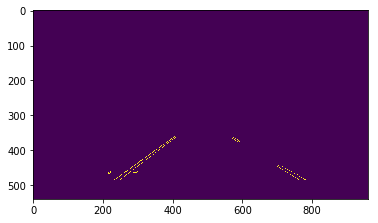

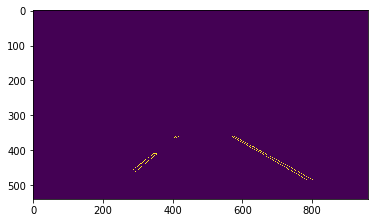

In [49]:
# This time we are defining a four sided polygon to mask
i=0
masked_edges_list=[]
for v in image_list:
    #print('i is ',i,'len of edges list is ', len(edges_list))
    imshape = v.shape
    print('v.shape is ',imshape)
    vertices = np.array([[(imshape[1]/16,imshape[0]*9/10),((imshape[1]/2)-(imshape[1]/10), imshape[0]*8/12), ((imshape[1]/2)+(imshape[1]/10), imshape[0]*8/12), (imshape[1]-(imshape[1]/16),imshape[0]*9/10)]], dtype=np.int32)
    masked_edges = region_of_interest(edges_list[i],vertices)
    plt.figure()
    plt.imshow(masked_edges)
    i=i+1
    masked_edges_list.append(masked_edges)



left slope is  -0.642857142857
slope= -0.642857142857
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.619047619048
slope= -0.619047619048
left slope is  -0.6
slope= -0.6
left slope is  -0.6
slope= -0.6
left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.789473684211
slope= -0.789473684211
left slope is  -0.653846153846
slope= -0.653846153846
left slope is  -0.75
slope= -0.75
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.75
slope= -0.75
left slope is  -0.625
slope= -0.625
left slope is  -0.75
slope= -0.75
left slope is  -0.769230769231
slope= -0.769230769231
left slope is  -0.75
slope= -0.75
left slope is  -0.625
slope= -0.625
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.75
slope= -0.75
avg left position is x= 375.888888889  y=  601.5
avg right slope is x= 0.579356189009  avg left slope=  -0.682972388236
i is  0  left array x is  509 y is  553
i is  1  left array x is  486 y is  546
i is  2 

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in int_scalars


i is  11  left array x is  517 y is  522
i is  12  left array x is  507 y is  528
i is  13  left array x is  503 y is  532
i is  14  left array x is  501 y is  533
i is  15  left array x is  499 y is  533
i is  16  left array x is  492 y is  539
i is  17  left array x is  476 y is  559
i is  18  left array x is  474 y is  559
i is  19  left array x is  443 y is  573
i is  20  left array x is  437 y is  586
i is  21  left array x is  433 y is  608
i is  22  left array x is  431 y is  592
i is  23  left array x is  431 y is  581
i is  24  left array x is  428 y is  582
i is  25  left array x is  427 y is  612
i is  26  left array x is  426 y is  607
i is  27  left array x is  425 y is  584
i is  28  left array x is  419 y is  611
i is  29  left array x is  406 y is  610
i is  30  left array x is  403 y is  611
i is  31  left array x is  401 y is  614
i is  32  left array x is  397 y is  603
i is  33  left array x is  395 y is  617
i is  34  left array x is  394 y is  618
i is  35  left a

i is  15  left array x is  481 y is  549
i is  16  left array x is  475 y is  562
i is  17  left array x is  473 y is  565
i is  18  left array x is  465 y is  561
i is  19  left array x is  462 y is  562
i is  20  left array x is  459 y is  564
i is  21  left array x is  458 y is  575
i is  22  left array x is  453 y is  568
i is  23  left array x is  446 y is  574
i is  24  left array x is  444 y is  574
i is  25  left array x is  441 y is  577
i is  26  left array x is  435 y is  592
i is  27  left array x is  432 y is  593
i is  28  left array x is  432 y is  582
i is  29  left array x is  430 y is  596
i is  30  left array x is  427 y is  597
i is  31  left array x is  422 y is  589
i is  32  left array x is  418 y is  605
i is  33  left array x is  418 y is  592
i is  34  left array x is  416 y is  593
i is  35  left array x is  414 y is  596
i is  36  left array x is  408 y is  611
i is  37  left array x is  407 y is  601
i is  38  left array x is  391 y is  625
i is  39  left a

avg left position is x= 334.642857143  y=  414.392857143
avg right slope is x= 0.627963306535  avg left slope=  -0.734090799236
i is  0  left array x is  414 y is  360
i is  1  left array x is  413 y is  360
i is  2  left array x is  407 y is  360
i is  3  left array x is  405 y is  361
i is  4  left array x is  385 y is  383
i is  5  left array x is  383 y is  384
i is  6  left array x is  376 y is  384
i is  7  left array x is  364 y is  391
i is  8  left array x is  361 y is  401
i is  9  left array x is  357 y is  396
i is  10  left array x is  352 y is  401
i is  11  left array x is  348 y is  402
i is  12  left array x is  339 y is  410
i is  13  left array x is  338 y is  418
i is  14  left array x is  325 y is  426
i is  15  left array x is  324 y is  419
i is  16  left array x is  323 y is  421
i is  17  left array x is  316 y is  434
i is  18  left array x is  311 y is  429
i is  19  left array x is  310 y is  430
i is  20  left array x is  304 y is  442
i is  21  left array 

new left i is  20 i0=  287  i+1 0= 282  i+2 0= 275
new left i is  21 i0=  282  i+1 0= 275  i+2 0= 274
new left i is  22 i0=  275  i+1 0= 274  i+2 0= 274
new left i is  23 i0=  274  i+1 0= 274  i+2 0= 268
new left i is  24 i0=  274  i+1 0= 268  i+2 0= 262
new left i is  25 i0=  268  i+1 0= 262  i+2 0= 258
new left i is  26 i0=  262  i+1 0= 258  i+2 0= 256
new left i is  27 i0=  258  i+1 0= 256  i+2 0= 255
new left i is  28 i0=  256  i+1 0= 255  i+2 0= 253
new left i is  29 i0=  255  i+1 0= 253  i+2 0= 250
new left i is  30 i0=  253  i+1 0= 250  i+2 0= 249
new left i is  31 i0=  250  i+1 0= 249  i+2 0= 248
new left i is  32 i0=  249  i+1 0= 248  i+2 0= 248
new left i is  33 i0=  248  i+1 0= 248  i+2 0= 247
new left i is  34 i0=  248  i+1 0= 247  i+2 0= 246
new left i is  35 i0=  247  i+1 0= 246  i+2 0= 231
del left array is  [18, 19, 24, 25, 34, 35]
new del left v is  35
new del left v is  34
new del left v is  25
new del left v is  24
new del left v is  19
new del left v is  18
last ind

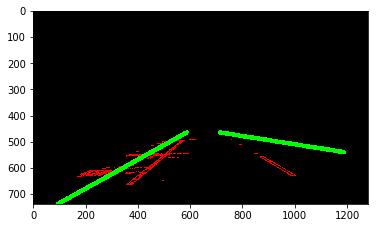

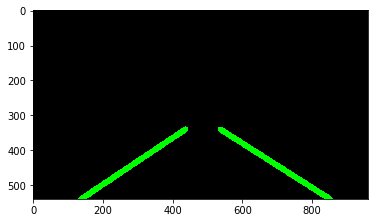

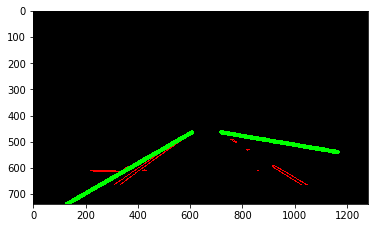

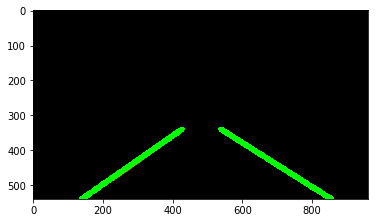

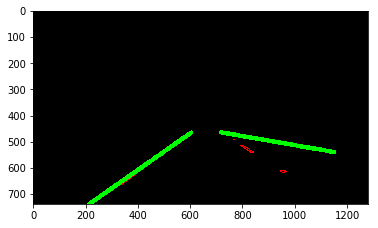

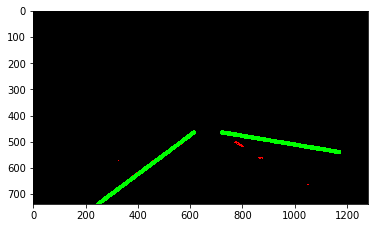

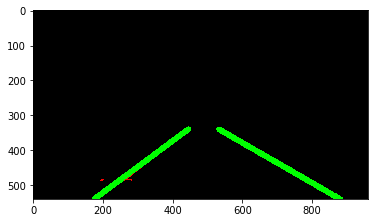

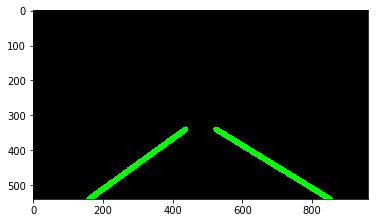

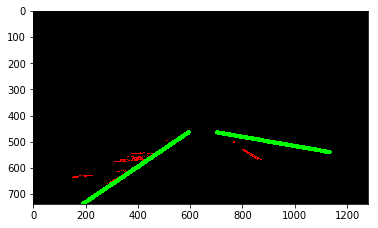

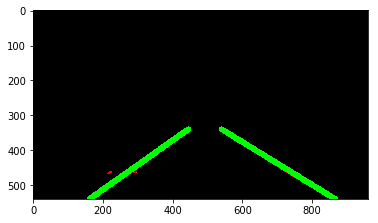

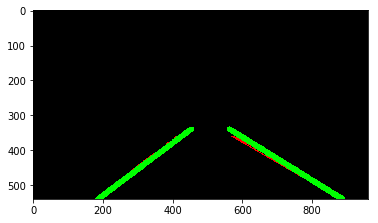

In [50]:
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1
theta = np.pi/180
threshold = 3
min_line_length = 3
max_line_gap = 7
lines_list=[]
for v in masked_edges_list:
    lines=hough_lines(v,rho,theta,threshold,min_line_length,max_line_gap)
    plt.figure()
    plt.imshow(lines)
    lines_list.append(lines)


"\ni=0\nfor v in mix_list:\n    mpimg.imsave('test_images/'+files[i]+'_after',v)\n    i = i+1\n"

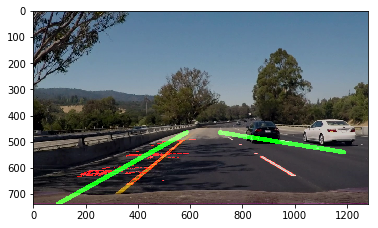

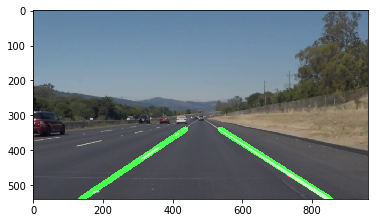

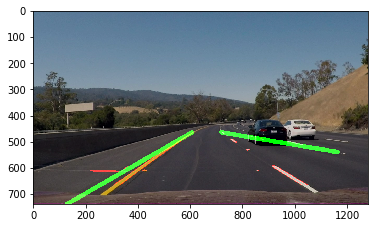

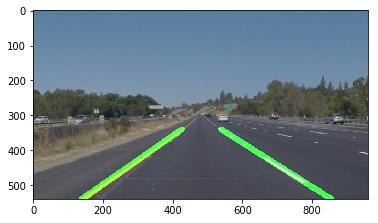

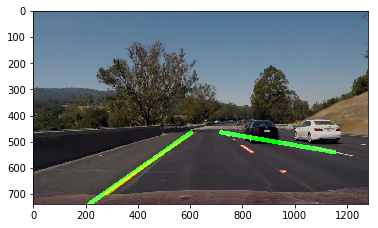

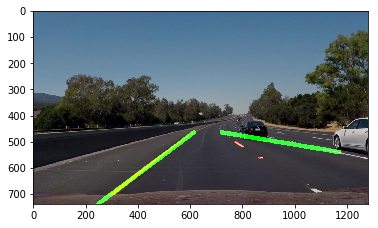

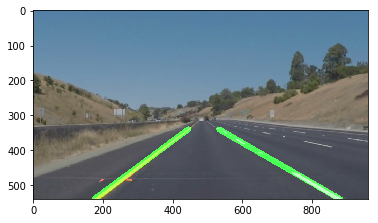

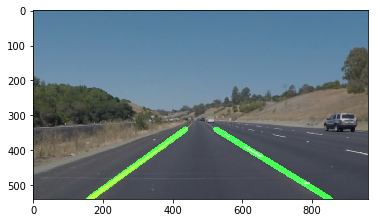

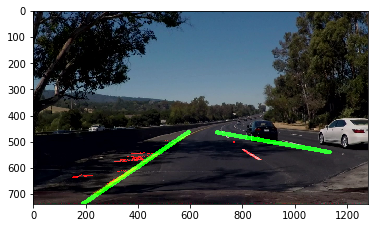

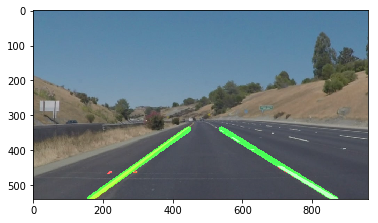

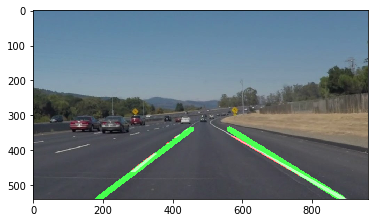

In [51]:
i=0
mix_list=[]
for v in lines_list:
    mix=weighted_img(v,image_list[i], α=0.8, β=1., λ=0.)
    plt.figure()
    plt.imshow(mix)
    i = i+1
    mix_list.append(mix)
"""
i=0
for v in mix_list:
    mpimg.imsave('test_images/'+files[i]+'_after',v)
    i = i+1
"""

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [ ]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
# Finished at previous cell

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [29]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [34]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    gray = grayscale(image)
    blur_gray = gaussian_blur(gray, 5)
    edges = canny(blur_gray, 10, 180)
    imshape = image.shape
    #print('imshape',imshape)
    vertices = np.array([[(imshape[1]/16,imshape[0]*9/10),((imshape[1]/2)-(imshape[1]/10), imshape[0]*8/12), ((imshape[1]/2)+(imshape[1]/10), imshape[0]*8/12), (imshape[1]-(imshape[1]/16),imshape[0]*9/10)]], dtype=np.int32)
    #vertices = np.array([[(60,720),(620,450),(720,450),(1100,720)]], dtype=np.int32)
    #print('vertices',vertices)
    masked_edges = region_of_interest(edges, vertices)
    rho = 1
    theta = np.pi/180
    threshold = 3
    min_line_length = 3
    max_line_gap = 7
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    result = weighted_img(lines, image, α=0.8, β=1., λ=0.)
    return result

Let's try the one with the solid white lane on the right first ...

In [ ]:
white_output = 'White.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [38]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

left slope is  -0.644444444444
slope= -0.644444444444
left slope is  -0.6171875
slope= -0.6171875
left slope is  -0.617647058824
slope= -0.617647058824
left slope is  -0.619565217391
slope= -0.619565217391
left slope is  -0.657894736842
slope= -0.657894736842
left slope is  -0.646341463415
slope= -0.646341463415
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.611111111111
slope= -0.611111111111
left slope is  -0.6
slope= -0.6
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.605263157895
slope= -0.605263157895
left slope is  -0.625
slope= -0.625
previous avg_left xposition is  470.958333333
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 310.416666667  y=  417.875
avg right slope is x= 0.646183562035  avg left slope=  -0.631482335271
i is  0  left array x is  407 y is  360
i is  1  left array x is  402 y is  362
i is  2  left array x is  400 y is  360
i is  3  left array x is  398 y is  366
i is  4  left array x is  398 y is  360
i 

  0%|          | 0/682 [00:00<?, ?it/s]

left slope is  -0.644444444444
slope= -0.644444444444
left slope is  -0.6171875
slope= -0.6171875
left slope is  -0.617647058824
slope= -0.617647058824
left slope is  -0.619565217391
slope= -0.619565217391
left slope is  -0.657894736842
slope= -0.657894736842
left slope is  -0.646341463415
slope= -0.646341463415
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.611111111111
slope= -0.611111111111
left slope is  -0.6
slope= -0.6
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.605263157895
slope= -0.605263157895
left slope is  -0.625
slope= -0.625
previous avg_left xposition is  310.416666667
avg left position is x= 310.416666667  y=  417.875
avg right slope is x= 0.646183562035  avg left slope=  -0.631482335271
i is  0  left array x is  407 y is  360
i is  1  left array x is  402 y is  362
i is  2  left array x is  400 y is  360
i is  3  left array x is  398 y is  366
i is  4  left array x is  398 y is  360
i is  5  left array x is  373 y is

  0%|          | 3/682 [00:00<00:30, 22.35it/s]

 y is  384
i is  9  left array x is  367 y is  385
i is  10  left array x is  320 y is  408
i is  11  left array x is  316 y is  412
i is  12  left array x is  297 y is  442
i is  13  left array x is  292 y is  445
i is  14  left array x is  287 y is  437
i is  15  left array x is  266 y is  449
i is  16  left array x is  212 y is  485
i is  17  left array x is  209 y is  486
i is  18  left array x is  193 y is  486
i is  19  left array x is  192 y is  486
new left i is  0 i0=  408  i+1 0= 406  i+2 0= 401
new left i is  1 i0=  406  i+1 0= 401  i+2 0= 401
new left i is  2 i0=  401  i+1 0= 401  i+2 0= 400
new left i is  3 i0=  401  i+1 0= 400  i+2 0= 398
new left i is  4 i0=  400  i+1 0= 398  i+2 0= 396
new left i is  5 i0=  398  i+1 0= 396  i+2 0= 390
new left i is  6 i0=  396  i+1 0= 390  i+2 0= 371
new left i is  7 i0=  390  i+1 0= 371  i+2 0= 367
new left i is  8 i0=  371  i+1 0= 367  i+2 0= 320
new left i is  9 i0=  367  i+1 0= 320  i+2 0= 316
new left i is  10 i0=  320  i+1 0= 316 

  1%|          | 5/682 [00:00<00:31, 21.53it/s]

final_x2_left= 326
final_y1_left= 486 avg_slope_right= 0.660411349234 final_y2_left= 411
final_y1_left= 486 avg_slope_left= -0.653219176562 final_x1_left= 204
final_y2_left= 411 avg_slope_left= -0.653219176562 final_x2_left= 326
after extrapolated
final_x1_left= 121 avg_slope_left= -0.653219176562 final_x2_left= 435
final_y1_left= 540 avg_slope_right= 0.660411349234 final_y2_left= 340
left slope is  -0.620689655172
slope= -0.620689655172
left slope is  -0.646153846154
slope= -0.646153846154
left slope is  -0.65625
slope= -0.65625
left slope is  -0.64
slope= -0.64
left slope is  -0.633333333333
slope= -0.633333333333
left slope is  -0.648275862069
slope= -0.648275862069
left slope is  -0.634615384615
slope= -0.634615384615
left slope is  -0.636363636364
slope= -0.636363636364
previous avg_left xposition is  326.409090909
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 302.5625  y=  424.5
avg right slope is x= 0.714285714286  avg left slope=  -0.639460214713
i is  0  left array x

  1%|          | 8/682 [00:00<00:30, 22.24it/s]

333 y is  412
i is  14  left array x is  329 y is  413
i is  15  left array x is  309 y is  426
i is  16  left array x is  307 y is  429
i is  17  left array x is  291 y is  438
i is  18  left array x is  258 y is  461
i is  19  left array x is  236 y is  475
i is  20  left array x is  231 y is  477
i is  21  left array x is  230 y is  478
i is  22  left array x is  226 y is  482
i is  23  left array x is  224 y is  482
i is  24  left array x is  219 y is  486
i is  25  left array x is  202 y is  486
new left i is  0 i0=  410  i+1 0= 409  i+2 0= 403
new left i is  1 i0=  409  i+1 0= 403  i+2 0= 402
new left i is  2 i0=  403  i+1 0= 402  i+2 0= 400
new left i is  3 i0=  402  i+1 0= 400  i+2 0= 398
new left i is  4 i0=  400  i+1 0= 398  i+2 0= 387
new left i is  5 i0=  398  i+1 0= 387  i+2 0= 387
new left i is  6 i0=  387  i+1 0= 387  i+2 0= 384
new left i is  7 i0=  387  i+1 0= 384  i+2 0= 382
new left i is  8 i0=  384  i+1 0= 382  i+2 0= 371
new left i is  9 i0=  382  i+1 0= 371  i+2 0

  1%|▏         | 10/682 [00:00<00:37, 17.99it/s]

 -0.67
slope= -0.67
left slope is  -0.609756097561
slope= -0.609756097561
left slope is  -0.659090909091
slope= -0.659090909091
left slope is  -0.6875
slope= -0.6875
left slope is  -0.625
slope= -0.625
left slope is  -0.692307692308
slope= -0.692307692308
left slope is  -0.64
slope= -0.64
left slope is  -0.6
slope= -0.6
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.75
slope= -0.75
left slope is  -0.75
slope= -0.75
left slope is  -0.75
slope= -0.75
left slope is  -0.702702702703
slope= -0.702702702703
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.6875
slope= -0.6875
left slope is  -0.6
slope= -0.6
left slope is  -0.75
slope= -0.75
left slope is  -0.6
slope= -0.6
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.666666666667
slope= -0.666666666667
previous avg_left xposition is  323.730769231
avg left position is x= 319.9  y=  415.675
avg right slope is x= 0.660906946511  avg left slope=  -0.674407155797
i is  0  l

  2%|▏         | 12/682 [00:00<00:36, 18.19it/s]

i is  14  left array x is  288 y is  443
i is  15  left array x is  277 y is  449
i is  16  left array x is  277 y is  442
i is  17  left array x is  273 y is  453
i is  18  left array x is  260 y is  460
i is  19  left array x is  250 y is  468
i is  20  left array x is  238 y is  476
i is  21  left array x is  235 y is  467
i is  22  left array x is  234 y is  477
i is  23  left array x is  233 y is  478
i is  24  left array x is  223 y is  476
i is  25  left array x is  221 y is  486
i is  26  left array x is  219 y is  477
i is  27  left array x is  207 y is  486
i is  28  left array x is  206 y is  486
i is  29  left array x is  205 y is  486
new left i is  0 i0=  410  i+1 0= 408  i+2 0= 402
new left i is  1 i0=  408  i+1 0= 402  i+2 0= 401
new left i is  2 i0=  402  i+1 0= 401  i+2 0= 390
new left i is  3 i0=  401  i+1 0= 390  i+2 0= 382
new left i is  4 i0=  390  i+1 0= 382  i+2 0= 356
new left i is  5 i0=  382  i+1 0= 356  i+2 0= 317
new left i is  6 i0=  356  i+1 0= 317  i+2 0

  2%|▏         | 14/682 [00:00<00:40, 16.45it/s]

left slope is  -0.727272727273
slope= -0.727272727273
left slope is  -0.642857142857
slope= -0.642857142857
left slope is  -0.657894736842
slope= -0.657894736842
left slope is  -0.661764705882
slope= -0.661764705882
left slope is  -0.72
slope= -0.72
left slope is  -0.684210526316
slope= -0.684210526316
left slope is  -0.75
slope= -0.75
left slope is  -0.658536585366
slope= -0.658536585366
left slope is  -0.785714285714
slope= -0.785714285714
left slope is  -0.625
slope= -0.625
left slope is  -0.740740740741
slope= -0.740740740741
left slope is  -0.740740740741
slope= -0.740740740741
left slope is  -0.65
slope= -0.65
left slope is  -0.76
slope= -0.76
left slope is  -0.655172413793
slope= -0.655172413793
left slope is  -0.695652173913
slope= -0.695652173913
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.6
slope= -0.6
left slope is  -0.7
slope= -0.7
left slope is  -0.625
slope= -0.625
previous avg_left xpositio

  3%|▎         | 18/682 [00:01<00:42, 15.46it/s]

new left i is  17 i0=  233  i+1 0= 232  i+2 0= 227
new left i is  18 i0=  232  i+1 0= 227  i+2 0= 227
new left i is  19 i0=  227  i+1 0= 227  i+2 0= 226
new left i is  20 i0=  227  i+1 0= 226  i+2 0= 216
new left i is  21 i0=  226  i+1 0= 216  i+2 0= 215
new left i is  22 i0=  216  i+1 0= 215  i+2 0= 213
new left i is  23 i0=  215  i+1 0= 213  i+2 0= 212
del left array is  [17, 18]
new del left v is  18
new del left v is  17
last index left array is 23
min line is  480.0
avg left x position=  288.625
avg left y position=  440.125
length of history_avg_left_xposition 1
length of history_avg_left_yposition 1
avg leftx his all= 288.625
avg lefty his all= 440.125
final_x1_left= 212 avg_slope_left= -0.693519469123 final_x2_left= 289
final_y1_left= 485 avg_slope_right= 0.647228622047 final_y2_left= 440
final_y1_left= 485 avg_slope_left= -0.693519469123 final_x1_left= 212
final_y2_left= 440 avg_slope_left= -0.693519469123 final_x2_left= 289
after extrapolated
final_x1_left= 133 avg_slope_left

  3%|▎         | 20/682 [00:01<00:41, 16.00it/s]

left slope is  -0.739130434783
slope= -0.739130434783
left slope is  -0.72
slope= -0.72
left slope is  -0.711111111111
slope= -0.711111111111
left slope is  -0.692307692308
slope= -0.692307692308
left slope is  -0.707317073171
slope= -0.707317073171
left slope is  -0.708333333333
slope= -0.708333333333
left slope is  -0.721649484536
slope= -0.721649484536
left slope is  -0.685714285714
slope= -0.685714285714
left slope is  -0.739130434783
slope= -0.739130434783
left slope is  -0.727272727273
slope= -0.727272727273
left slope is  -0.733333333333
slope= -0.733333333333
left slope is  -0.725490196078
slope= -0.725490196078
left slope is  -0.769230769231
slope= -0.769230769231
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.75
slope= -0.75
left slope is  -0.727272727273
slope= -0.727272727273
left slope is  -0.724137931034
slope= -0.724137931034
previous avg_left xposition is  300.066666667
avg left position is x= 303.588235294  y=  429.823529412
avg right slope is 

  4%|▎         | 24/682 [00:01<00:41, 15.70it/s]

 i+2 0= 399
new left i is  2 i0=  400  i+1 0= 399  i+2 0= 391
new left i is  3 i0=  399  i+1 0= 391  i+2 0= 384
new left i is  4 i0=  391  i+1 0= 384  i+2 0= 381
new left i is  5 i0=  384  i+1 0= 381  i+2 0= 373
new left i is  6 i0=  381  i+1 0= 373  i+2 0= 370
new left i is  7 i0=  373  i+1 0= 370  i+2 0= 369
new left i is  8 i0=  370  i+1 0= 369  i+2 0= 359
new left i is  9 i0=  369  i+1 0= 359  i+2 0= 358
new left i is  10 i0=  359  i+1 0= 358  i+2 0= 339
new left i is  11 i0=  358  i+1 0= 339  i+2 0= 336
new left i is  12 i0=  339  i+1 0= 336  i+2 0= 323
new left i is  13 i0=  336  i+1 0= 323  i+2 0= 318
new left i is  14 i0=  323  i+1 0= 318  i+2 0= 307
new left i is  15 i0=  318  i+1 0= 307  i+2 0= 298
new left i is  16 i0=  307  i+1 0= 298  i+2 0= 290
new left i is  17 i0=  298  i+1 0= 290  i+2 0= 270
new left i is  18 i0=  290  i+1 0= 270  i+2 0= 269
new left i is  19 i0=  270  i+1 0= 269  i+2 0= 268
new left i is  20 i0=  269  i+1 0= 268  i+2 0= 260
new left i is  21 i0=  268 

  4%|▍         | 28/682 [00:01<00:37, 17.39it/s]

 394  i+1 0= 339  i+2 0= 338
new left i is  8 i0=  339  i+1 0= 338  i+2 0= 337
new left i is  9 i0=  338  i+1 0= 337  i+2 0= 335
new left i is  10 i0=  337  i+1 0= 335  i+2 0= 334
new left i is  11 i0=  335  i+1 0= 334  i+2 0= 332
new left i is  12 i0=  334  i+1 0= 332  i+2 0= 329
new left i is  13 i0=  332  i+1 0= 329  i+2 0= 272
new left i is  14 i0=  329  i+1 0= 272  i+2 0= 250
new left i is  15 i0=  272  i+1 0= 250  i+2 0= 241
new left i is  16 i0=  250  i+1 0= 241  i+2 0= 233
new left i is  17 i0=  241  i+1 0= 233  i+2 0= 232
new left i is  18 i0=  233  i+1 0= 232  i+2 0= 216
new left i is  19 i0=  232  i+1 0= 216  i+2 0= 215
del left array is  []
last index left array is 21
min line is  480.0
avg left x position=  328.0
avg left y position=  416.863636364
length of history_avg_left_xposition 12
length of history_avg_left_yposition 12
avg leftx his all= 304.789138027
avg lefty his all= 429.908155811
leftx
lefty
final_x1_left= 216 avg_slope_left= -0.691020694592 final_x2_left= 305


  5%|▍         | 32/682 [00:01<00:36, 17.66it/s]

  i+2 0= 391
new left i is  4 i0=  391  i+1 0= 391  i+2 0= 379
new left i is  5 i0=  391  i+1 0= 379  i+2 0= 366
new left i is  6 i0=  379  i+1 0= 366  i+2 0= 345
new left i is  7 i0=  366  i+1 0= 345  i+2 0= 342
new left i is  8 i0=  345  i+1 0= 342  i+2 0= 334
new left i is  9 i0=  342  i+1 0= 334  i+2 0= 333
new left i is  10 i0=  334  i+1 0= 333  i+2 0= 320
new left i is  11 i0=  333  i+1 0= 320  i+2 0= 318
new left i is  12 i0=  320  i+1 0= 318  i+2 0= 312
new left i is  13 i0=  318  i+1 0= 312  i+2 0= 311
new left i is  14 i0=  312  i+1 0= 311  i+2 0= 307
new left i is  15 i0=  311  i+1 0= 307  i+2 0= 304
new left i is  16 i0=  307  i+1 0= 304  i+2 0= 302
new left i is  17 i0=  304  i+1 0= 302  i+2 0= 298
new left i is  18 i0=  302  i+1 0= 298  i+2 0= 293
new left i is  19 i0=  298  i+1 0= 293  i+2 0= 286
new left i is  20 i0=  293  i+1 0= 286  i+2 0= 281
new left i is  21 i0=  286  i+1 0= 281  i+2 0= 280
new left i is  22 i0=  281  i+1 0= 280  i+2 0= 276
new left i is  23 i0=  2

  6%|▌         | 38/682 [00:02<00:33, 19.29it/s]

366 y is  383
i is  7  left array x is  357 y is  398
i is  8  left array x is  343 y is  408
i is  9  left array x is  341 y is  403
i is  10  left array x is  340 y is  411
i is  11  left array x is  322 y is  415
i is  12  left array x is  315 y is  420
i is  13  left array x is  306 y is  428
i is  14  left array x is  303 y is  439
i is  15  left array x is  303 y is  430
i is  16  left array x is  302 y is  439
i is  17  left array x is  285 y is  452
i is  18  left array x is  284 y is  442
i is  19  left array x is  269 y is  454
i is  20  left array x is  267 y is  454
i is  21  left array x is  264 y is  456
i is  22  left array x is  254 y is  464
i is  23  left array x is  238 y is  486
i is  24  left array x is  222 y is  486
i is  25  left array x is  221 y is  486
new left i is  0 i0=  406  i+1 0= 402  i+2 0= 398
new left i is  1 i0=  402  i+1 0= 398  i+2 0= 392
new left i is  2 i0=  398  i+1 0= 392  i+2 0= 385
new left i is  3 i0=  392  i+1 0= 385  i+2 0= 371
new left i

  6%|▌         | 42/682 [00:02<00:30, 21.17it/s]

 i+1 0= 220  i+2 0= 219
del left array is  []
last index left array is 15
min line is  480.0
avg left x position=  301.5625
avg left y position=  430.5625
length of history_avg_left_xposition 8
length of history_avg_left_yposition 8
avg leftx his all= 303.666925956
avg lefty his all= 431.609506813
final_x1_left= 220 avg_slope_left= -0.71110013978 final_x2_left= 302
final_y1_left= 486 avg_slope_right= 0.649835122295 final_y2_left= 431
final_y1_left= 486 avg_slope_left= -0.71110013978 final_x1_left= 220
final_y2_left= 431 avg_slope_left= -0.71110013978 final_x2_left= 302
after extrapolated
final_x1_left= 146 avg_slope_left= -0.71110013978 final_x2_left= 426
final_y1_left= 540 avg_slope_right= 0.649835122295 final_y2_left= 340
left slope is  -0.796875
slope= -0.796875
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.768115942029
slope= -0.768115942029
left slope is  -0.767441860465
slope= -0.767441860465
left slope is  -0.772727272727
slope= -0.772727272727
left slo

  7%|▋         | 48/682 [00:02<00:30, 20.93it/s]

i0=  246  i+1 0= 239  i+2 0= 236
new left i is  12 i0=  239  i+1 0= 236  i+2 0= 231
new left i is  13 i0=  236  i+1 0= 231  i+2 0= 220
del left array is  []
last index left array is 15
min line is  480.0
avg left x position=  318.75
avg left y position=  419.0
length of history_avg_left_xposition 3
length of history_avg_left_yposition 3
avg leftx his all= 311.469907407
avg lefty his all= 423.206018519
leftx
lefty
final_x1_left= 226 avg_slope_left= -0.741920302818 final_x2_left= 311
final_y1_left= 486 avg_slope_right= 0.613890160765 final_y2_left= 423
final_y1_left= 486 avg_slope_left= -0.741920302818 final_x1_left= 226
final_y2_left= 423 avg_slope_left= -0.741920302818 final_x2_left= 311
after extrapolated
final_x1_left= 153 avg_slope_left= -0.741920302818 final_x2_left= 423
final_y1_left= 540 avg_slope_right= 0.613890160765 final_y2_left= 340
left slope is  -0.723880597015
slope= -0.723880597015
left slope is  -0.72131147541
slope= -0.72131147541
left slope is  -0.717391304348
slope= 

  8%|▊         | 54/682 [00:02<00:29, 21.58it/s]

  i+2 0= 220
new left i is  23 i0=  221  i+1 0= 220  i+2 0= 219
del left array is  [20, 21]
new del left v is  21
new del left v is  20
last index left array is 23
min line is  480.0
avg left x position=  307.75
avg left y position=  427.166666667
length of history_avg_left_xposition 1
length of history_avg_left_yposition 1
avg leftx his all= 307.75
avg lefty his all= 427.166666667
final_x1_left= 220 avg_slope_left= -0.762426277273 final_x2_left= 308
final_y1_left= 486 avg_slope_right= 0.587703702848 final_y2_left= 427
final_y1_left= 486 avg_slope_left= -0.762426277273 final_x1_left= 220
final_y2_left= 427 avg_slope_left= -0.762426277273 final_x2_left= 308
after extrapolated
final_x1_left= 149 avg_slope_left= -0.762426277273 final_x2_left= 422
final_y1_left= 540 avg_slope_right= 0.587703702848 final_y2_left= 340
left slope is  -0.756756756757
slope= -0.756756756757
left slope is  -0.724137931034
slope= -0.724137931034
left slope is  -0.757281553398
slope= -0.757281553398
left slope is 

  8%|▊         | 57/682 [00:02<00:29, 21.49it/s]

  i+2 0= 363
new left i is  8 i0=  366  i+1 0= 363  i+2 0= 352
new left i is  9 i0=  363  i+1 0= 352  i+2 0= 345
new left i is  10 i0=  352  i+1 0= 345  i+2 0= 341
new left i is  11 i0=  345  i+1 0= 341  i+2 0= 338
new left i is  12 i0=  341  i+1 0= 338  i+2 0= 315
new left i is  13 i0=  338  i+1 0= 315  i+2 0= 294
new left i is  14 i0=  315  i+1 0= 294  i+2 0= 234
new left i is  15 i0=  294  i+1 0= 234  i+2 0= 233
new left i is  16 i0=  234  i+1 0= 233  i+2 0= 220
new left i is  17 i0=  233  i+1 0= 220  i+2 0= 217
del left array is  []
last index left array is 19
min line is  480.0
avg left x position=  337.3
avg left y position=  406.5
length of history_avg_left_xposition 1
length of history_avg_left_yposition 1
avg leftx his all= 337.3
avg lefty his all= 406.5
final_x1_left= 218 avg_slope_left= -0.717194008225 final_x2_left= 337
final_y1_left= 486 avg_slope_right= 0.583333333333 final_y2_left= 406
final_y1_left= 486 avg_slope_left= -0.717194008225 final_x1_left= 218
final_y2_left= 4

  9%|▉         | 63/682 [00:03<00:29, 20.84it/s]

388  i+2 0= 382
new left i is  5 i0=  388  i+1 0= 382  i+2 0= 378
new left i is  6 i0=  382  i+1 0= 378  i+2 0= 344
new left i is  7 i0=  378  i+1 0= 344  i+2 0= 339
new left i is  8 i0=  344  i+1 0= 339  i+2 0= 326
new left i is  9 i0=  339  i+1 0= 326  i+2 0= 322
new left i is  10 i0=  326  i+1 0= 322  i+2 0= 319
new left i is  11 i0=  322  i+1 0= 319  i+2 0= 310
new left i is  12 i0=  319  i+1 0= 310  i+2 0= 308
new left i is  13 i0=  310  i+1 0= 308  i+2 0= 297
new left i is  14 i0=  308  i+1 0= 297  i+2 0= 294
new left i is  15 i0=  297  i+1 0= 294  i+2 0= 292
new left i is  16 i0=  294  i+1 0= 292  i+2 0= 273
new left i is  17 i0=  292  i+1 0= 273  i+2 0= 255
new left i is  18 i0=  273  i+1 0= 255  i+2 0= 253
new left i is  19 i0=  255  i+1 0= 253  i+2 0= 244
new left i is  20 i0=  253  i+1 0= 244  i+2 0= 232
new left i is  21 i0=  244  i+1 0= 232  i+2 0= 231
new left i is  22 i0=  232  i+1 0= 231  i+2 0= 217
new left i is  23 i0=  231  i+1 0= 217  i+2 0= 216
del left array is  [

 10%|█         | 69/682 [00:03<00:29, 20.78it/s]


i is  5  left array x is  384 y is  372
i is  6  left array x is  378 y is  371
i is  7  left array x is  376 y is  374
i is  8  left array x is  372 y is  375
i is  9  left array x is  359 y is  385
i is  10  left array x is  340 y is  399
i is  11  left array x is  338 y is  399
i is  12  left array x is  335 y is  408
i is  13  left array x is  333 y is  411
i is  14  left array x is  330 y is  420
i is  15  left array x is  329 y is  420
i is  16  left array x is  326 y is  423
i is  17  left array x is  325 y is  423
i is  18  left array x is  324 y is  420
i is  19  left array x is  323 y is  420
i is  20  left array x is  320 y is  423
i is  21  left array x is  320 y is  422
i is  22  left array x is  301 y is  426
i is  23  left array x is  296 y is  428
i is  24  left array x is  292 y is  431
i is  25  left array x is  286 y is  445
i is  26  left array x is  282 y is  439
i is  27  left array x is  277 y is  450
i is  28  left array x is  270 y is  447
i is  29  left array

 11%|█         | 72/682 [00:03<00:30, 19.88it/s]

 -0.679245283019
slope= -0.679245283019
left slope is  -0.707317073171
slope= -0.707317073171
left slope is  -0.678082191781
slope= -0.678082191781
left slope is  -0.703703703704
slope= -0.703703703704
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.68
slope= -0.68
left slope is  -0.689655172414
slope= -0.689655172414
left slope is  -0.692307692308
slope= -0.692307692308
left slope is  -0.692307692308
slope= -0.692307692308
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.685714285714
slope= -0.685714285714
left slope is  -0.676470588235
slope= -0.676470588235
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.666666666667
slope= -0.666666666667
previous avg_left xposition is  303.75
avg left position is x= 308.214285714  y=  426.428571429
avg right slope is x= 0.623581295628  avg left slope=  -0.685649242638
i is  0  left array x is  405 y is  360
i is  1  left array x is  402 y is  363
i is  2  left array x is  399 y

 11%|█▏        | 78/682 [00:04<00:30, 19.56it/s]

344
new left i is  13 i0=  351  i+1 0= 344  i+2 0= 342
new left i is  14 i0=  344  i+1 0= 342  i+2 0= 342
new left i is  15 i0=  342  i+1 0= 342  i+2 0= 330
new left i is  16 i0=  342  i+1 0= 330  i+2 0= 328
new left i is  17 i0=  330  i+1 0= 328  i+2 0= 312
new left i is  18 i0=  328  i+1 0= 312  i+2 0= 308
new left i is  19 i0=  312  i+1 0= 308  i+2 0= 306
new left i is  20 i0=  308  i+1 0= 306  i+2 0= 303
new left i is  21 i0=  306  i+1 0= 303  i+2 0= 293
new left i is  22 i0=  303  i+1 0= 293  i+2 0= 288
new left i is  23 i0=  293  i+1 0= 288  i+2 0= 278
new left i is  24 i0=  288  i+1 0= 278  i+2 0= 277
new left i is  25 i0=  278  i+1 0= 277  i+2 0= 260
new left i is  26 i0=  277  i+1 0= 260  i+2 0= 259
new left i is  27 i0=  260  i+1 0= 259  i+2 0= 244
new left i is  28 i0=  259  i+1 0= 244  i+2 0= 241
new left i is  29 i0=  244  i+1 0= 241  i+2 0= 236
new left i is  30 i0=  241  i+1 0= 236  i+2 0= 231
new left i is  31 i0=  236  i+1 0= 231  i+2 0= 230
new left i is  32 i0=  231 

 12%|█▏        | 82/682 [00:04<00:39, 15.28it/s]

 28  left array x is  290 y is  444
i is  29  left array x is  290 y is  443
i is  30  left array x is  289 y is  435
i is  31  left array x is  288 y is  436
i is  32  left array x is  284 y is  447
i is  33  left array x is  283 y is  439
i is  34  left array x is  282 y is  449
i is  35  left array x is  271 y is  460
i is  36  left array x is  271 y is  449
i is  37  left array x is  267 y is  463
i is  38  left array x is  257 y is  457
i is  39  left array x is  253 y is  461
i is  40  left array x is  250 y is  462
i is  41  left array x is  238 y is  470
i is  42  left array x is  233 y is  485
i is  43  left array x is  219 y is  484
new left i is  0 i0=  405  i+1 0= 397  i+2 0= 395
new left i is  1 i0=  397  i+1 0= 395  i+2 0= 394
new left i is  2 i0=  395  i+1 0= 394  i+2 0= 393
new left i is  3 i0=  394  i+1 0= 393  i+2 0= 391
new left i is  4 i0=  393  i+1 0= 391  i+2 0= 386
new left i is  5 i0=  391  i+1 0= 386  i+2 0= 386
new left i is  6 i0=  386  i+1 0= 386  i+2 0= 363

 12%|█▏        | 85/682 [00:04<00:36, 16.15it/s]

 -0.672131147541
slope= -0.672131147541
left slope is  -0.688524590164
slope= -0.688524590164
left slope is  -0.708737864078
slope= -0.708737864078
left slope is  -0.709677419355
slope= -0.709677419355
left slope is  -0.678571428571
slope= -0.678571428571
left slope is  -0.724137931034
slope= -0.724137931034
left slope is  -0.673684210526
slope= -0.673684210526
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.7
slope= -0.7
left slope is  -0.727272727273
slope= -0.727272727273
previous avg_left xposition is  303.21875
avg left position is x= 313.75  y=  422.15
avg right slope is x= 0.59441735348  avg left slope=  -0.694940398521
i is  0  left array x is  404 y is  360
i is  1  left array x is  403 y is  360
i is  2  left array x is  402 y is  360
i is  3  left array x is  397 y is  360
i is  4  left array x is  392 y is  368
i is  5  left array x is  380 y is  372
i is  6  left array x is  373 y is  381
i is  7  left array x is  353 y is  397
i is  8  left array x

 13%|█▎        | 91/682 [00:04<00:30, 19.07it/s]


new left i is  9 i0=  354  i+1 0= 329  i+2 0= 272
new left i is  10 i0=  329  i+1 0= 272  i+2 0= 247
new left i is  11 i0=  272  i+1 0= 247  i+2 0= 230
new left i is  12 i0=  247  i+1 0= 230  i+2 0= 229
new left i is  13 i0=  230  i+1 0= 229  i+2 0= 224
new left i is  14 i0=  229  i+1 0= 224  i+2 0= 209
new left i is  15 i0=  224  i+1 0= 209  i+2 0= 208
del left array is  []
last index left array is 17
min line is  480.0
avg left x position=  322.444444444
avg left y position=  413.777777778
length of history_avg_left_xposition 9
length of history_avg_left_yposition 9
avg leftx his all= 312.095177893
avg lefty his all= 421.754004714
leftx
lefty
final_x1_left= 208 avg_slope_left= -0.722614807686 final_x2_left= 312
final_y1_left= 486 avg_slope_right= 0.650837130354 final_y2_left= 422
final_y1_left= 486 avg_slope_left= -0.722614807686 final_x1_left= 208
final_y2_left= 422 avg_slope_left= -0.722614807686 final_x2_left= 312
after extrapolated
final_x1_left= 132 avg_slope_left= -0.722614807

 14%|█▍        | 94/682 [00:04<00:31, 18.93it/s]

 2  left array x is  387 y is  369
i is  3  left array x is  380 y is  379
i is  4  left array x is  304 y is  425
i is  5  left array x is  264 y is  467
i is  6  left array x is  261 y is  467
i is  7  left array x is  260 y is  467
i is  8  left array x is  257 y is  471
i is  9  left array x is  257 y is  468
i is  10  left array x is  256 y is  470
i is  11  left array x is  255 y is  470
i is  12  left array x is  234 y is  481
i is  13  left array x is  231 y is  484
i is  14  left array x is  228 y is  485
i is  15  left array x is  227 y is  475
i is  16  left array x is  212 y is  486
i is  17  left array x is  211 y is  486
new left i is  0 i0=  406  i+1 0= 399  i+2 0= 387
new left i is  1 i0=  399  i+1 0= 387  i+2 0= 380
new left i is  2 i0=  387  i+1 0= 380  i+2 0= 304
new left i is  3 i0=  380  i+1 0= 304  i+2 0= 264
new left i is  4 i0=  304  i+1 0= 264  i+2 0= 261
new left i is  5 i0=  264  i+1 0= 261  i+2 0= 260
new left i is  6 i0=  261  i+1 0= 260  i+2 0= 257
new lef

 14%|█▍        | 98/682 [00:05<00:33, 17.62it/s]

  i+2 0= 251
new left i is  23 i0=  254  i+1 0= 251  i+2 0= 245
new left i is  24 i0=  251  i+1 0= 245  i+2 0= 240
new left i is  25 i0=  245  i+1 0= 240  i+2 0= 235
new left i is  26 i0=  240  i+1 0= 235  i+2 0= 231
new left i is  27 i0=  235  i+1 0= 231  i+2 0= 221
new left i is  28 i0=  231  i+1 0= 221  i+2 0= 220
new left i is  29 i0=  221  i+1 0= 220  i+2 0= 214
del left array is  [26, 27]
new del left v is  27
new del left v is  26
last index left array is 29
min line is  480.0
avg left x position=  312.433333333
avg left y position=  422.733333333
length of history_avg_left_xposition 1
length of history_avg_left_yposition 1
avg leftx his all= 312.433333333
avg lefty his all= 422.733333333
final_x1_left= 217 avg_slope_left= -0.715192685284 final_x2_left= 312
final_y1_left= 486 avg_slope_right= 0.584311019094 final_y2_left= 423
final_y1_left= 486 avg_slope_left= -0.715192685284 final_x1_left= 217
final_y2_left= 423 avg_slope_left= -0.715192685284 final_x2_left= 312
after extrapola

 15%|█▌        | 103/682 [00:05<00:32, 18.02it/s]


i is  39  left array x is  214 y is  486
new left i is  0 i0=  408  i+1 0= 403  i+2 0= 401
new left i is  1 i0=  403  i+1 0= 401  i+2 0= 400
new left i is  2 i0=  401  i+1 0= 400  i+2 0= 388
new left i is  3 i0=  400  i+1 0= 388  i+2 0= 387
new left i is  4 i0=  388  i+1 0= 387  i+2 0= 384
new left i is  5 i0=  387  i+1 0= 384  i+2 0= 382
new left i is  6 i0=  384  i+1 0= 382  i+2 0= 374
new left i is  7 i0=  382  i+1 0= 374  i+2 0= 372
new left i is  8 i0=  374  i+1 0= 372  i+2 0= 364
new left i is  9 i0=  372  i+1 0= 364  i+2 0= 354
new left i is  10 i0=  364  i+1 0= 354  i+2 0= 338
new left i is  11 i0=  354  i+1 0= 338  i+2 0= 331
new left i is  12 i0=  338  i+1 0= 331  i+2 0= 315
new left i is  13 i0=  331  i+1 0= 315  i+2 0= 311
new left i is  14 i0=  315  i+1 0= 311  i+2 0= 301
new left i is  15 i0=  311  i+1 0= 301  i+2 0= 301
new left i is  16 i0=  301  i+1 0= 301  i+2 0= 299
new left i is  17 i0=  301  i+1 0= 299  i+2 0= 293
new left i is  18 i0=  299  i+1 0= 293  i+2 0= 291

 16%|█▌        | 109/682 [00:05<00:28, 20.25it/s]

 []
last index left array is 15
min line is  480.0
avg left x position=  310.25
avg left y position=  423.8125
length of history_avg_left_xposition 11
length of history_avg_left_yposition 11
avg leftx his all= 313.780310187
avg lefty his all= 423.03139571
final_x1_left= 212 avg_slope_left= -0.68319088058 final_x2_left= 310
final_y1_left= 486 avg_slope_right= 0.610497835498 final_y2_left= 424
final_y1_left= 486 avg_slope_left= -0.68319088058 final_x1_left= 212
final_y2_left= 424 avg_slope_left= -0.68319088058 final_x2_left= 310
after extrapolated
final_x1_left= 135 avg_slope_left= -0.68319088058 final_x2_left= 429
final_y1_left= 540 avg_slope_right= 0.610497835498 final_y2_left= 340
left slope is  -0.7
slope= -0.7
left slope is  -0.673796791444
slope= -0.673796791444
left slope is  -0.677419354839
slope= -0.677419354839
left slope is  -0.675324675325
slope= -0.675324675325
left slope is  -0.702898550725
slope= -0.702898550725
left slope is  -0.714285714286
slope= -0.714285714286
left sl

 17%|█▋        | 114/682 [00:06<00:30, 18.56it/s]

slope= -0.703488372093
left slope is  -0.691358024691
slope= -0.691358024691
left slope is  -0.733333333333
slope= -0.733333333333
left slope is  -0.704
slope= -0.704
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.733333333333
slope= -0.733333333333
left slope is  -0.72
slope= -0.72
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.75
slope= -0.75
left slope is  -0.7
slope= -0.7
left slope is  -0.684210526316
slope= -0.684210526316
left slope is  -0.709677419355
slope= -0.709677419355
previous avg_left xposition is  313.916666667
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 293.346153846  y=  435.384615385
avg right slope is x= 0.584033926552  avg left slope=  -0.707377190167
i is  0  left array x is  409 y is  360
i is  1  left array x is  403 y is  365
i is  2  left array x is  403 y is  360
i is  3  left array x is  401 y is  360
i is  4  left array x is  389 y is  370
i is  5  left array x is  384 y is  372
i is  6  left arr

 17%|█▋        | 116/682 [00:06<00:31, 17.94it/s]

y is  381
i is  9  left array x is  359 y is  397
i is  10  left array x is  319 y is  433
i is  11  left array x is  317 y is  426
i is  12  left array x is  315 y is  436
i is  13  left array x is  315 y is  432
i is  14  left array x is  315 y is  428
i is  15  left array x is  310 y is  435
i is  16  left array x is  287 y is  439
i is  17  left array x is  274 y is  457
i is  18  left array x is  264 y is  463
i is  19  left array x is  257 y is  469
i is  20  left array x is  240 y is  480
i is  21  left array x is  238 y is  470
i is  22  left array x is  232 y is  486
i is  23  left array x is  232 y is  485
i is  24  left array x is  216 y is  486
i is  25  left array x is  215 y is  486
new left i is  0 i0=  409  i+1 0= 408  i+2 0= 401
new left i is  1 i0=  408  i+1 0= 401  i+2 0= 401
new left i is  2 i0=  401  i+1 0= 401  i+2 0= 399
new left i is  3 i0=  401  i+1 0= 399  i+2 0= 395
new left i is  4 i0=  399  i+1 0= 395  i+2 0= 387
new left i is  5 i0=  395  i+1 0= 387  i+2 0

 18%|█▊        | 120/682 [00:06<00:38, 14.74it/s]

  i+1 0= 303  i+2 0= 297
new left i is  16 i0=  303  i+1 0= 297  i+2 0= 297
new left i is  17 i0=  297  i+1 0= 297  i+2 0= 293
new left i is  18 i0=  297  i+1 0= 293  i+2 0= 263
new left i is  19 i0=  293  i+1 0= 263  i+2 0= 257
new left i is  20 i0=  263  i+1 0= 257  i+2 0= 234
new left i is  21 i0=  257  i+1 0= 234  i+2 0= 232
new left i is  22 i0=  234  i+1 0= 232  i+2 0= 216
new left i is  23 i0=  232  i+1 0= 216  i+2 0= 215
del left array is  []
last index left array is 25
min line is  480.0
avg left x position=  330.307692308
avg left y position=  411.923076923
length of history_avg_left_xposition 2
length of history_avg_left_yposition 2
avg leftx his all= 328.903846154
avg lefty his all= 412.755016722
final_x1_left= 216 avg_slope_left= -0.705986103206 final_x2_left= 330
final_y1_left= 486 avg_slope_right= 0.634883481555 final_y2_left= 412
final_y1_left= 486 avg_slope_left= -0.705986103206 final_x1_left= 216
final_y2_left= 412 avg_slope_left= -0.705986103206 final_x2_left= 330
af

 18%|█▊        | 124/682 [00:06<00:36, 15.20it/s]


left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.695652173913
slope= -0.695652173913
left slope is  -0.75
slope= -0.75
left slope is  -0.694444444444
slope= -0.694444444444
left slope is  -0.75
slope= -0.75
previous avg_left xposition is  326.125
avg left position is x= 322.541666667  y=  417.75
avg right slope is x= 0.667489167221  avg left slope=  -0.704176574549
i is  0  left array x is  409 y is  360
i is  1  left array x is  406 y is  361
i is  2  left array x is  402 y is  365
i is  3  left array x is  399 y is  361
i is  4  left array x is  395 y is  369
i is  5  left array x is  393 y is  372
i is  6  left array x is  382 y is  378
i is  7  left array x is  374 y is  386
i is  8  left array x is  372 y is  381
i is  9  left array x is  362 y is  388
i is  10  left array x is  346 y is  399
i is  11  left array x is  338 y is  412
i is  12  left array x is  336 y is  406
i is  13  left array x is  331 y is  417
i is  14  left array x is  331 y is  408
i i

 19%|█▉        | 128/682 [00:06<00:32, 16.83it/s]


new left i is  26 i0=  262  i+1 0= 256  i+2 0= 237
new left i is  27 i0=  256  i+1 0= 237  i+2 0= 235
new left i is  28 i0=  237  i+1 0= 235  i+2 0= 220
new left i is  29 i0=  235  i+1 0= 220  i+2 0= 219
del left array is  [9, 10]
new del left v is  10
new del left v is  9
last index left array is 29
min line is  480.0
avg left x position=  326.533333333
avg left y position=  417.066666667
length of history_avg_left_xposition 3
length of history_avg_left_yposition 3
avg leftx his all= 314.371001221
avg lefty his all= 424.70995116
leftx
lefty
final_x1_left= 220 avg_slope_left= -0.715971025675 final_x2_left= 314
final_y1_left= 486 avg_slope_right= 0.646642709143 final_y2_left= 425
final_y1_left= 486 avg_slope_left= -0.715971025675 final_x1_left= 220
final_y2_left= 425 avg_slope_left= -0.715971025675 final_x2_left= 314
after extrapolated
final_x1_left= 144 avg_slope_left= -0.715971025675 final_x2_left= 433
final_y1_left= 540 avg_slope_right= 0.646642709143 final_y2_left= 340
left slope i

 19%|█▉        | 132/682 [00:07<00:32, 16.78it/s]

left slope is  -0.75
slope= -0.75
left slope is  -0.724137931034
slope= -0.724137931034
left slope is  -0.694214876033
slope= -0.694214876033
left slope is  -0.698412698413
slope= -0.698412698413
left slope is  -0.733333333333
slope= -0.733333333333
left slope is  -0.741935483871
slope= -0.741935483871
left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.583333333333
slope= -0.583333333333
left slope is  -0.7
slope= -0.7
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.769230769231
slope= -0.769230769231
left slope is  -0.75
slope= -0.75
left slope is  -0.75
slope= -0.75
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.571428571429
slope= -0.571428571429
previous avg_left xposition is  349.722222222
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 311.0625  y=  424.53125
avg right slope is x= 0.661174242424  avg left slope=  -0.692817163483
i is  0  left array x

 20%|██        | 137/682 [00:07<00:29, 18.71it/s]

275 y is  447
i is  12  left array x is  243 y is  482
i is  13  left array x is  236 y is  486
i is  14  left array x is  235 y is  486
i is  15  left array x is  219 y is  486
new left i is  0 i0=  411  i+1 0= 410  i+2 0= 409
new left i is  1 i0=  410  i+1 0= 409  i+2 0= 405
new left i is  2 i0=  409  i+1 0= 405  i+2 0= 404
new left i is  3 i0=  405  i+1 0= 404  i+2 0= 403
new left i is  4 i0=  404  i+1 0= 403  i+2 0= 395
new left i is  5 i0=  403  i+1 0= 395  i+2 0= 385
new left i is  6 i0=  395  i+1 0= 385  i+2 0= 346
new left i is  7 i0=  385  i+1 0= 346  i+2 0= 320
new left i is  8 i0=  346  i+1 0= 320  i+2 0= 304
new left i is  9 i0=  320  i+1 0= 304  i+2 0= 275
new left i is  10 i0=  304  i+1 0= 275  i+2 0= 243
new left i is  11 i0=  275  i+1 0= 243  i+2 0= 236
new left i is  12 i0=  243  i+1 0= 236  i+2 0= 235
new left i is  13 i0=  236  i+1 0= 235  i+2 0= 219
del left array is  []
last index left array is 15
min line is  480.0
avg left x position=  337.5
avg left y position= 

 21%|██        | 141/682 [00:07<00:29, 18.20it/s]

new left i is  9 i0=  246  i+1 0= 239  i+2 0= 237
new left i is  10 i0=  239  i+1 0= 237  i+2 0= 222
new left i is  11 i0=  237  i+1 0= 222  i+2 0= 221
del left array is  []
last index left array is 13
min line is  480.0
avg left x position=  326.857142857
avg left y position=  417.071428571
length of history_avg_left_xposition 4
length of history_avg_left_yposition 4
avg leftx his all= 333.095454545
avg lefty his all= 412.193290043
leftx
lefty
final_x1_left= 222 avg_slope_left= -0.690255689082 final_x2_left= 333
final_y1_left= 485 avg_slope_right= 0.612976743854 final_y2_left= 412
final_y1_left= 485 avg_slope_left= -0.690255689082 final_x1_left= 222
final_y2_left= 412 avg_slope_left= -0.690255689082 final_x2_left= 333
after extrapolated
final_x1_left= 143 avg_slope_left= -0.690255689082 final_x2_left= 436
final_y1_left= 540 avg_slope_right= 0.612976743854 final_y2_left= 340
left slope is  -0.692307692308
slope= -0.692307692308
left slope is  -0.647058823529
slope= -0.647058823529
left

 21%|██▏       | 146/682 [00:07<00:29, 18.47it/s]

 -0.6
slope= -0.6
left slope is  -0.75
slope= -0.75
left slope is  -0.69696969697
slope= -0.69696969697
left slope is  -0.736842105263
slope= -0.736842105263
left slope is  -0.722222222222
slope= -0.722222222222
left slope is  -0.740740740741
slope= -0.740740740741
left slope is  -0.75
slope= -0.75
left slope is  -0.722222222222
slope= -0.722222222222
left slope is  -0.714285714286
slope= -0.714285714286
previous avg_left xposition is  299.708333333
avg left position is x= 314.033333333  y=  424.766666667
avg right slope is x= 0.618008637453  avg left slope=  -0.721007749479
i is  0  left array x is  411 y is  360
i is  1  left array x is  410 y is  360
i is  2  left array x is  409 y is  360
i is  3  left array x is  403 y is  360
i is  4  left array x is  398 y is  363
i is  5  left array x is  397 y is  369
i is  6  left array x is  379 y is  378
i is  7  left array x is  374 y is  386
i is  8  left array x is  354 y is  394
i is  9  left array x is  352 y is  397
i is  10  left arr

 22%|██▏       | 148/682 [00:07<00:29, 18.14it/s]

left slope is  -0.75
slope= -0.75
left slope is  -0.747474747475
slope= -0.747474747475
left slope is  -0.693548387097
slope= -0.693548387097
left slope is  -0.692307692308
slope= -0.692307692308
left slope is  -0.761904761905
slope= -0.761904761905
left slope is  -0.789473684211
slope= -0.789473684211
left slope is  -0.716417910448
slope= -0.716417910448
left slope is  -0.75
slope= -0.75
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.769230769231
slope= -0.769230769231
left slope is  -0.756097560976
slope= -0.756097560976
left slope is  -0.75
slope= -0.75
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.75
slope= -0.75
left slope is  -0.722222222222
slope= -0.722222222222
previous avg_left xposition is  309.041666667
avg left position is x= 308.866666667  y=  427.533333333
avg right slope is x= 0.668894253894  avg left slope=  -0.746948886095
i is  0  left array x is  408 y is  360
i is  1  left array x is  404 y is  363
i is  2  left ar

 23%|██▎       | 154/682 [00:08<00:29, 17.78it/s]

 383 y is  378
i is  5  left array x is  363 y is  388
i is  6  left array x is  356 y is  405
i is  7  left array x is  355 y is  405
i is  8  left array x is  354 y is  405
i is  9  left array x is  352 y is  408
i is  10  left array x is  351 y is  408
i is  11  left array x is  351 y is  404
i is  12  left array x is  350 y is  408
i is  13  left array x is  347 y is  407
i is  14  left array x is  346 y is  398
i is  15  left array x is  317 y is  426
i is  16  left array x is  247 y is  477
i is  17  left array x is  243 y is  480
i is  18  left array x is  236 y is  486
i is  19  left array x is  235 y is  486
i is  20  left array x is  226 y is  480
i is  21  left array x is  218 y is  486
new left i is  0 i0=  409  i+1 0= 403  i+2 0= 403
new left i is  1 i0=  403  i+1 0= 403  i+2 0= 402
new left i is  2 i0=  403  i+1 0= 402  i+2 0= 383
new left i is  3 i0=  402  i+1 0= 383  i+2 0= 363
new left i is  4 i0=  383  i+1 0= 363  i+2 0= 356
new left i is  5 i0=  363  i+1 0= 356  i+2 

 23%|██▎       | 157/682 [00:08<00:27, 19.12it/s]

 -0.674698795181
slope= -0.674698795181
left slope is  -0.700729927007
slope= -0.700729927007
left slope is  -0.702380952381
slope= -0.702380952381
left slope is  -0.678571428571
slope= -0.678571428571
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.68253968254
slope= -0.68253968254
left slope is  -0.6
slope= -0.6
left slope is  -0.684210526316
slope= -0.684210526316
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.66
slope= -0.66
previous avg_left xposition is  314.375
avg left position is x= 303.2  y=  435.25
avg right slope is x= 0.604712301587  avg left slope=  -0.676408369295
i is  0  left array x is  416 y is  360
i is  1  left array x is  414 y is  360
i is  2  left array x is  408 y is  360
i is  3  left array x is  404 y is  363
i is  4  left array x is  385 y is  376
i is  5  left array x is  330 y is  419
i is  6  left array x is  322 y is  419
i is  7  left array x is  296 y is  445
i is  8  left array x is  288 y is  442
i is 

 24%|██▎       | 161/682 [00:08<00:29, 17.90it/s]


i is  16  left array x is  338 y is  417
i is  17  left array x is  330 y is  415
i is  18  left array x is  319 y is  432
i is  19  left array x is  305 y is  442
i is  20  left array x is  303 y is  442
i is  21  left array x is  298 y is  447
i is  22  left array x is  294 y is  449
i is  23  left array x is  289 y is  453
i is  24  left array x is  280 y is  460
i is  25  left array x is  276 y is  463
i is  26  left array x is  266 y is  469
i is  27  left array x is  244 y is  486
i is  28  left array x is  244 y is  476
i is  29  left array x is  237 y is  479
i is  30  left array x is  228 y is  486
i is  31  left array x is  227 y is  486
new left i is  0 i0=  420  i+1 0= 417  i+2 0= 413
new left i is  1 i0=  417  i+1 0= 413  i+2 0= 413
new left i is  2 i0=  413  i+1 0= 413  i+2 0= 411
new left i is  3 i0=  413  i+1 0= 411  i+2 0= 409
new left i is  4 i0=  411  i+1 0= 409  i+2 0= 398
new left i is  5 i0=  409  i+1 0= 398  i+2 0= 384
new left i is  6 i0=  398  i+1 0= 384  i+2 

 24%|██▍       | 166/682 [00:08<00:28, 18.24it/s]

i is  17  left array x is  283 y is  450
i is  18  left array x is  280 y is  451
i is  19  left array x is  270 y is  458
i is  20  left array x is  262 y is  464
i is  21  left array x is  252 y is  481
i is  22  left array x is  251 y is  482
i is  23  left array x is  248 y is  473
i is  24  left array x is  247 y is  486
i is  25  left array x is  247 y is  475
i is  26  left array x is  231 y is  486
i is  27  left array x is  230 y is  486
new left i is  0 i0=  421  i+1 0= 415  i+2 0= 375
new left i is  1 i0=  415  i+1 0= 375  i+2 0= 374
new left i is  2 i0=  375  i+1 0= 374  i+2 0= 361
new left i is  3 i0=  374  i+1 0= 361  i+2 0= 350
new left i is  4 i0=  361  i+1 0= 350  i+2 0= 348
new left i is  5 i0=  350  i+1 0= 348  i+2 0= 344
new left i is  6 i0=  348  i+1 0= 344  i+2 0= 340
new left i is  7 i0=  344  i+1 0= 340  i+2 0= 332
new left i is  8 i0=  340  i+1 0= 332  i+2 0= 329
new left i is  9 i0=  332  i+1 0= 329  i+2 0= 316
new left i is  10 i0=  329  i+1 0= 316  i+2 0= 31

 25%|██▌       | 171/682 [00:09<00:28, 17.92it/s]

33  left array x is  247 y is  476
new left i is  0 i0=  421  i+1 0= 418  i+2 0= 414
new left i is  1 i0=  418  i+1 0= 414  i+2 0= 413
new left i is  2 i0=  414  i+1 0= 413  i+2 0= 381
new left i is  3 i0=  413  i+1 0= 381  i+2 0= 378
new left i is  4 i0=  381  i+1 0= 378  i+2 0= 375
new left i is  5 i0=  378  i+1 0= 375  i+2 0= 371
new left i is  6 i0=  375  i+1 0= 371  i+2 0= 361
new left i is  7 i0=  371  i+1 0= 361  i+2 0= 352
new left i is  8 i0=  361  i+1 0= 352  i+2 0= 334
new left i is  9 i0=  352  i+1 0= 334  i+2 0= 331
new left i is  10 i0=  334  i+1 0= 331  i+2 0= 328
new left i is  11 i0=  331  i+1 0= 328  i+2 0= 317
new left i is  12 i0=  328  i+1 0= 317  i+2 0= 316
new left i is  13 i0=  317  i+1 0= 316  i+2 0= 314
new left i is  14 i0=  316  i+1 0= 314  i+2 0= 313
new left i is  15 i0=  314  i+1 0= 313  i+2 0= 304
new left i is  16 i0=  313  i+1 0= 304  i+2 0= 291
new left i is  17 i0=  304  i+1 0= 291  i+2 0= 290
new left i is  18 i0=  291  i+1 0= 290  i+2 0= 280
new le

 25%|██▌       | 173/682 [00:09<00:28, 17.64it/s]


slope= -0.692307692308
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.789473684211
slope= -0.789473684211
left slope is  -0.738095238095
slope= -0.738095238095
left slope is  -0.75
slope= -0.75
left slope is  -0.731707317073
slope= -0.731707317073
left slope is  -0.764705882353
slope= -0.764705882353
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.785714285714
slope= -0.785714285714
left slope is  -0.625
slope= -0.625
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.739130434783
slope= -0.739130434783
left slope is  -0.727272727273
slope= -0.727272727273
previous avg_left xposition is  329.357142857
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 306.96875  y=  440.46875
avg right slope is x= 0.571437908497  avg left slope=  -0.726411526211
i is  0  left array x is  421 y is  360
i is  1  left array x is  414 y is  360
i is  2  left array x is  413 y is  361
i is  3  left array x is  407 y is  371
i is  4 

 27%|██▋       | 181/682 [00:09<00:25, 19.60it/s]

left slope is  -0.68
slope= -0.68
left slope is  -0.647058823529
slope= -0.647058823529
left slope is  -0.736842105263
slope= -0.736842105263
left slope is  -0.769230769231
slope= -0.769230769231
left slope is  -0.753086419753
slope= -0.753086419753
left slope is  -0.647058823529
slope= -0.647058823529
left slope is  -0.75
slope= -0.75
previous avg_left xposition is  343.5
avg left position is x= 335.642857143  y=  419.571428571
avg right slope is x= 0.625202828394  avg left slope=  -0.706207143681
i is  0  left array x is  414 y is  365
i is  1  left array x is  412 y is  361
i is  2  left array x is  405 y is  372
i is  3  left array x is  400 y is  376
i is  4  left array x is  398 y is  376
i is  5  left array x is  387 y is  380
i is  6  left array x is  377 y is  386
i is  7  left array x is  376 y is  388
i is  8  left array x is  369 y is  392
i is  9  left array x is  367 y is  400
i is  10  left array x is  357 y is  402
i is  11  left array x is  351 y is  405
i is  12  left

 27%|██▋       | 187/682 [00:10<00:23, 20.66it/s]

 -0.729032258065
slope= -0.729032258065
left slope is  -0.730769230769
slope= -0.730769230769
left slope is  -0.744186046512
slope= -0.744186046512
left slope is  -0.728813559322
slope= -0.728813559322
left slope is  -0.7
slope= -0.7
left slope is  -0.6875
slope= -0.6875
left slope is  -0.733333333333
slope= -0.733333333333
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.7
slope= -0.7
left slope is  -0.741935483871
slope= -0.741935483871
previous avg_left xposition is  316.666666667
avg left position is x= 321.25  y=  435.05
avg right slope is x= 0.558535047296  avg left slope=  -0.716223657854
i is  0  left array x is  414 y is  360
i is  1  left array x is  413 y is  360
i is  2  left array x is  403 y is  367
i is  3  left array x is  397 y is  373
i is  4  left array x is  344 y is  420
i is  5  left array x is  334 y is  427
i is  6  left array x is  330 y is  431
i is  7  left array x is  329 y is  432
i is  8  left array x is  325 y is  435
i is  9  left 

 28%|██▊       | 190/682 [00:10<00:24, 19.81it/s]

left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.765625
slope= -0.765625
left slope is  -0.767441860465
slope= -0.767441860465
left slope is  -0.787878787879
slope= -0.787878787879
left slope is  -0.761904761905
slope= -0.761904761905
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.739130434783
slope= -0.739130434783
previous avg_left xposition is  325.0
avg left position is x= 315.642857143  y=  437.714285714
avg right slope is x= 0.589762182644  avg left slope=  -0.750078896229
i is  0  left array x is  420 y is  360
i is  1  left array x is  406 y is  370
i is  2  left array x is  362 y is  398
i is  3  left array x is  345 y is  420
i is  4  left array x is  342 y is  422
i is  5  left array x is  329 y is  424
i is  6  left array x is  319 y is  439
i is  7  left array x is  290 y is  463
i is  8  left array x is  288 y is  453
i is  9  left array x is  283 y is  468
i is  10  left array x is  281 y is  469
i is  11  left array x is  

 28%|██▊       | 193/682 [00:10<00:25, 18.94it/s]

 415  i+1 0= 412  i+2 0= 411
new left i is  2 i0=  412  i+1 0= 411  i+2 0= 409
new left i is  3 i0=  411  i+1 0= 409  i+2 0= 407
new left i is  4 i0=  409  i+1 0= 407  i+2 0= 404
new left i is  5 i0=  407  i+1 0= 404  i+2 0= 401
new left i is  6 i0=  404  i+1 0= 401  i+2 0= 385
new left i is  7 i0=  401  i+1 0= 385  i+2 0= 370
new left i is  8 i0=  385  i+1 0= 370  i+2 0= 319
new left i is  9 i0=  370  i+1 0= 319  i+2 0= 309
new left i is  10 i0=  319  i+1 0= 309  i+2 0= 305
new left i is  11 i0=  309  i+1 0= 305  i+2 0= 290
new left i is  12 i0=  305  i+1 0= 290  i+2 0= 283
new left i is  13 i0=  290  i+1 0= 283  i+2 0= 278
new left i is  14 i0=  283  i+1 0= 278  i+2 0= 261
new left i is  15 i0=  278  i+1 0= 261  i+2 0= 259
new left i is  16 i0=  261  i+1 0= 259  i+2 0= 245
new left i is  17 i0=  259  i+1 0= 245  i+2 0= 244
del left array is  []
last index left array is 19
min line is  480.0
avg left x position=  341.25
avg left y position=  418.0
length of history_avg_left_xposition 

 29%|██▉       | 198/682 [00:10<00:26, 18.32it/s]


new left i is  9 i0=  265  i+1 0= 264  i+2 0= 257
new left i is  10 i0=  264  i+1 0= 257  i+2 0= 253
new left i is  11 i0=  257  i+1 0= 253  i+2 0= 248
new left i is  12 i0=  253  i+1 0= 248  i+2 0= 242
new left i is  13 i0=  248  i+1 0= 242  i+2 0= 241
del left array is  [3, 4, 12, 13]
new del left v is  13
new del left v is  12
new del left v is  4
new del left v is  3
last index left array is 11
min line is  480.0
avg left x position=  302.25
avg left y position=  445.5
length of history_avg_left_xposition 1
length of history_avg_left_yposition 1
avg leftx his all= 302.25
avg lefty his all= 445.5
final_x1_left= 242 avg_slope_left= -0.73535455084 final_x2_left= 302
final_y1_left= 486 avg_slope_right= 0.599551820728 final_y2_left= 446
final_y1_left= 486 avg_slope_left= -0.73535455084 final_x1_left= 242
final_y2_left= 446 avg_slope_left= -0.73535455084 final_x2_left= 302
after extrapolated
final_x1_left= 169 avg_slope_left= -0.73535455084 final_x2_left= 446
final_y1_left= 540 avg_slop

 29%|██▉       | 201/682 [00:10<00:25, 19.02it/s]

left slope is  -0.782608695652
slope= -0.782608695652
left slope is  -0.754491017964
slope= -0.754491017964
left slope is  -0.788888888889
slope= -0.788888888889
left slope is  -0.753012048193
slope= -0.753012048193
left slope is  -0.787234042553
slope= -0.787234042553
left slope is  -0.752941176471
slope= -0.752941176471
previous avg_left xposition is  323.75
avg left position is x= 330.833333333  y=  422.25
avg right slope is x= 0.548297193334  avg left slope=  -0.769862644954
i is  0  left array x is  416 y is  360
i is  1  left array x is  414 y is  360
i is  2  left array x is  408 y is  360
i is  3  left array x is  406 y is  361
i is  4  left array x is  367 y is  397
i is  5  left array x is  352 y is  403
i is  6  left array x is  347 y is  415
i is  7  left array x is  267 y is  467
i is  8  left array x is  257 y is  486
i is  9  left array x is  255 y is  486
i is  10  left array x is  241 y is  486
i is  11  left array x is  240 y is  486
new left i is  0 i0=  416  i+1 0= 

 30%|███       | 206/682 [00:11<00:23, 19.99it/s]

 8
last index left array is 19
min line is  480.0
avg left x position=  335.65
avg left y position=  414.4
length of history_avg_left_xposition 2
length of history_avg_left_yposition 2
avg leftx his all= 338.936111111
avg lefty his all= 411.727777778
final_x1_left= 238 avg_slope_left= -0.689982532031 final_x2_left= 336
final_y1_left= 486 avg_slope_right= 0.585616313511 final_y2_left= 414
final_y1_left= 486 avg_slope_left= -0.689982532031 final_x1_left= 238
final_y2_left= 414 avg_slope_left= -0.689982532031 final_x2_left= 336
after extrapolated
final_x1_left= 159 avg_slope_left= -0.689982532031 final_x2_left= 444
final_y1_left= 540 avg_slope_right= 0.585616313511 final_y2_left= 340
left slope is  -0.748466257669
slope= -0.748466257669
left slope is  -0.748031496063
slope= -0.748031496063
left slope is  -0.767857142857
slope= -0.767857142857
left slope is  -0.767857142857
slope= -0.767857142857
left slope is  -0.625
slope= -0.625
left slope is  -0.757142857143
slope= -0.757142857143
left

 31%|███       | 211/682 [00:11<00:24, 19.60it/s]

i is  0  left array x is  409 y is  360
i is  1  left array x is  405 y is  362
i is  2  left array x is  401 y is  370
i is  3  left array x is  370 y is  394
i is  4  left array x is  359 y is  403
i is  5  left array x is  357 y is  405
i is  6  left array x is  351 y is  408
i is  7  left array x is  349 y is  411
i is  8  left array x is  342 y is  415
i is  9  left array x is  336 y is  421
i is  10  left array x is  329 y is  425
i is  11  left array x is  327 y is  428
i is  12  left array x is  317 y is  434
i is  13  left array x is  315 y is  437
i is  14  left array x is  305 y is  443
i is  15  left array x is  303 y is  446
i is  16  left array x is  299 y is  449
i is  17  left array x is  295 y is  451
i is  18  left array x is  290 y is  455
i is  19  left array x is  286 y is  449
i is  20  left array x is  279 y is  464
i is  21  left array x is  277 y is  465
i is  22  left array x is  272 y is  469
i is  23  left array x is  268 y is  473
i is  24  left array x is 

 32%|███▏      | 216/682 [00:11<00:26, 17.82it/s]

6  left array x is  376 y is  384
i is  7  left array x is  370 y is  388
i is  8  left array x is  365 y is  398
i is  9  left array x is  365 y is  390
i is  10  left array x is  349 y is  417
i is  11  left array x is  345 y is  420
i is  12  left array x is  345 y is  416
i is  13  left array x is  341 y is  419
i is  14  left array x is  338 y is  417
i is  15  left array x is  327 y is  427
i is  16  left array x is  307 y is  442
i is  17  left array x is  292 y is  452
i is  18  left array x is  292 y is  442
i is  19  left array x is  284 y is  458
i is  20  left array x is  265 y is  474
i is  21  left array x is  249 y is  485
i is  22  left array x is  248 y is  486
i is  23  left array x is  237 y is  482
i is  24  left array x is  233 y is  486
i is  25  left array x is  232 y is  486
new left i is  0 i0=  414  i+1 0= 413  i+2 0= 409
new left i is  1 i0=  413  i+1 0= 409  i+2 0= 408
new left i is  2 i0=  409  i+1 0= 408  i+2 0= 406
new left i is  3 i0=  408  i+1 0= 406  i

 32%|███▏      | 221/682 [00:11<00:24, 19.00it/s]

-0.724137931034
left slope is  -0.785714285714
slope= -0.785714285714
left slope is  -0.787878787879
slope= -0.787878787879
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.722222222222
slope= -0.722222222222
left slope is  -0.625
slope= -0.625
left slope is  -0.75
slope= -0.75
left slope is  -0.735294117647
slope= -0.735294117647
left slope is  -0.761904761905
slope= -0.761904761905
left slope is  -0.722222222222
slope= -0.722222222222
left slope is  -0.75
slope= -0.75
left slope is  -0.75
slope= -0.75
left slope is  -0.75
slope= -0.75
previous avg_left xposition is  341.3125
avg left position is x= 335.884615385  y=  413.384615385
avg right slope is x= 0.562929292929  avg left slope=  -0.741704008185
i is  0  left array x is  412 y is  360
i is  1  left array x is  409 y is  363
i is  2  left array x is  400 y is  363
i is  3  left array x is  394 y is  373
i is  4  left array x is  392 y is  376
i is  5  left array x is  384 y is  382
i is  6  left array x is 

 33%|███▎      | 226/682 [00:12<00:23, 19.25it/s]

-0.745874267396 final_x2_left= 333
after extrapolated
final_x1_left= 170 avg_slope_left= -0.745874267396 final_x2_left= 441
final_y1_left= 540 avg_slope_right= 0.639983164983 final_y2_left= 340
left slope is  -0.6875
slope= -0.6875
left slope is  -0.700598802395
slope= -0.700598802395
left slope is  -0.768115942029
slope= -0.768115942029
left slope is  -0.795918367347
slope= -0.795918367347
left slope is  -0.6
slope= -0.6
left slope is  -0.711111111111
slope= -0.711111111111
left slope is  -0.647058823529
slope= -0.647058823529
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.6
slope= -0.6
left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.692307692308
slope= -0.692307692308
left slope is  -0.733333333333
slope= -0.733333333333
left slope is  -0.625
slope= -0.625
previous avg_left xposition is  333.35
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 307.961538462  y=  433.807692308
avg right slope is x= 0.668443983009  avg left slope= 

 34%|███▎      | 229/682 [00:12<00:23, 19.59it/s]


i is  0  left array x is  411 y is  360
i is  1  left array x is  405 y is  360
i is  2  left array x is  404 y is  360
i is  3  left array x is  392 y is  374
i is  4  left array x is  367 y is  388
i is  5  left array x is  366 y is  388
i is  6  left array x is  351 y is  399
i is  7  left array x is  322 y is  428
i is  8  left array x is  278 y is  450
i is  9  left array x is  262 y is  473
i is  10  left array x is  258 y is  464
i is  11  left array x is  250 y is  471
i is  12  left array x is  244 y is  486
i is  13  left array x is  243 y is  486
i is  14  left array x is  242 y is  475
i is  15  left array x is  240 y is  478
i is  16  left array x is  237 y is  480
i is  17  left array x is  228 y is  486
new left i is  0 i0=  411  i+1 0= 405  i+2 0= 404
new left i is  1 i0=  405  i+1 0= 404  i+2 0= 392
new left i is  2 i0=  404  i+1 0= 392  i+2 0= 367
new left i is  3 i0=  392  i+1 0= 367  i+2 0= 366
new left i is  4 i0=  367  i+1 0= 366  i+2 0= 351
new left i is  5 i0= 

 34%|███▍      | 234/682 [00:12<00:23, 19.24it/s]

 5  left array x is  375 y is  381
i is  6  left array x is  364 y is  387
i is  7  left array x is  363 y is  389
i is  8  left array x is  361 y is  389
i is  9  left array x is  356 y is  394
i is  10  left array x is  344 y is  401
i is  11  left array x is  343 y is  403
i is  12  left array x is  335 y is  407
i is  13  left array x is  333 y is  410
i is  14  left array x is  323 y is  417
i is  15  left array x is  302 y is  430
i is  16  left array x is  296 y is  434
i is  17  left array x is  282 y is  445
i is  18  left array x is  272 y is  452
i is  19  left array x is  266 y is  466
i is  20  left array x is  254 y is  463
i is  21  left array x is  248 y is  478
i is  22  left array x is  239 y is  486
i is  23  left array x is  238 y is  486
i is  24  left array x is  225 y is  485
i is  25  left array x is  223 y is  486
new left i is  0 i0=  411  i+1 0= 410  i+2 0= 404
new left i is  1 i0=  410  i+1 0= 404  i+2 0= 401
new left i is  2 i0=  404  i+1 0= 401  i+2 0= 384

 35%|███▍      | 238/682 [00:12<00:23, 18.94it/s]

  i+1 0= 404  i+2 0= 403
new left i is  2 i0=  404  i+1 0= 403  i+2 0= 402
new left i is  3 i0=  403  i+1 0= 402  i+2 0= 361
new left i is  4 i0=  402  i+1 0= 361  i+2 0= 302
new left i is  5 i0=  361  i+1 0= 302  i+2 0= 288
new left i is  6 i0=  302  i+1 0= 288  i+2 0= 238
new left i is  7 i0=  288  i+1 0= 238  i+2 0= 237
new left i is  8 i0=  238  i+1 0= 237  i+2 0= 223
new left i is  9 i0=  237  i+1 0= 223  i+2 0= 221
del left array is  []
last index left array is 11
min line is  480.0
avg left x position=  324.916666667
avg left y position=  417.416666667
length of history_avg_left_xposition 14
length of history_avg_left_yposition 14
avg leftx his all= 318.473972456
avg lefty his all= 424.44856681
leftx
lefty
final_x1_left= 222 avg_slope_left= -0.708669807567 final_x2_left= 318
final_y1_left= 486 avg_slope_right= 0.618881922675 final_y2_left= 424
final_y1_left= 486 avg_slope_left= -0.708669807567 final_x1_left= 222
final_y2_left= 424 avg_slope_left= -0.708669807567 final_x2_left= 3

 36%|███▌      | 244/682 [00:13<00:23, 19.04it/s]

12 i0=  329  i+1 0= 328  i+2 0= 327
new left i is  13 i0=  328  i+1 0= 327  i+2 0= 325
new left i is  14 i0=  327  i+1 0= 325  i+2 0= 313
new left i is  15 i0=  325  i+1 0= 313  i+2 0= 301
new left i is  16 i0=  313  i+1 0= 301  i+2 0= 295
new left i is  17 i0=  301  i+1 0= 295  i+2 0= 286
new left i is  18 i0=  295  i+1 0= 286  i+2 0= 284
new left i is  19 i0=  286  i+1 0= 284  i+2 0= 263
new left i is  20 i0=  284  i+1 0= 263  i+2 0= 250
new left i is  21 i0=  263  i+1 0= 250  i+2 0= 238
new left i is  22 i0=  250  i+1 0= 238  i+2 0= 237
new left i is  23 i0=  238  i+1 0= 237  i+2 0= 224
del left array is  []
last index left array is 25
min line is  480.0
avg left x position=  325.653846154
avg left y position=  416.5
length of history_avg_left_xposition 3
length of history_avg_left_yposition 3
avg leftx his all= 309.934615385
avg lefty his all= 426.830555556
leftx
lefty
final_x1_left= 230 avg_slope_left= -0.692212872629 final_x2_left= 310
final_y1_left= 485 avg_slope_right= 0.608652

 36%|███▋      | 248/682 [00:13<00:23, 18.45it/s]

454
i is  18  left array x is  254 y is  463
i is  19  left array x is  240 y is  474
i is  20  left array x is  238 y is  486
i is  21  left array x is  237 y is  486
new left i is  0 i0=  413  i+1 0= 412  i+2 0= 406
new left i is  1 i0=  412  i+1 0= 406  i+2 0= 405
new left i is  2 i0=  406  i+1 0= 405  i+2 0= 399
new left i is  3 i0=  405  i+1 0= 399  i+2 0= 397
new left i is  4 i0=  399  i+1 0= 397  i+2 0= 385
new left i is  5 i0=  397  i+1 0= 385  i+2 0= 378
new left i is  6 i0=  385  i+1 0= 378  i+2 0= 357
new left i is  7 i0=  378  i+1 0= 357  i+2 0= 353
new left i is  8 i0=  357  i+1 0= 353  i+2 0= 344
new left i is  9 i0=  353  i+1 0= 344  i+2 0= 342
new left i is  10 i0=  344  i+1 0= 342  i+2 0= 335
new left i is  11 i0=  342  i+1 0= 335  i+2 0= 311
new left i is  12 i0=  335  i+1 0= 311  i+2 0= 297
new left i is  13 i0=  311  i+1 0= 297  i+2 0= 295
new left i is  14 i0=  297  i+1 0= 295  i+2 0= 291
new left i is  15 i0=  295  i+1 0= 291  i+2 0= 269
new left i is  16 i0=  291

 37%|███▋      | 252/682 [00:13<00:23, 17.95it/s]

259
new left i is  18 i0=  270  i+1 0= 259  i+2 0= 238
new left i is  19 i0=  259  i+1 0= 238  i+2 0= 237
new left i is  20 i0=  238  i+1 0= 237  i+2 0= 221
new left i is  21 i0=  237  i+1 0= 221  i+2 0= 220
del left array is  []
last index left array is 23
min line is  480.0
avg left x position=  341.958333333
avg left y position=  406.916666667
length of history_avg_left_xposition 4
length of history_avg_left_yposition 4
avg leftx his all= 340.329229798
avg lefty his all= 408.557449495
final_x1_left= 220 avg_slope_left= -0.71444041705 final_x2_left= 342
final_y1_left= 486 avg_slope_right= 0.623198403372 final_y2_left= 407
final_y1_left= 486 avg_slope_left= -0.71444041705 final_x1_left= 220
final_y2_left= 407 avg_slope_left= -0.71444041705 final_x2_left= 342
after extrapolated
final_x1_left= 143 avg_slope_left= -0.71444041705 final_x2_left= 437
final_y1_left= 540 avg_slope_right= 0.623198403372 final_y2_left= 340
left slope is  -0.724137931034
slope= -0.724137931034
left slope is  -0.

 38%|███▊      | 257/682 [00:13<00:22, 18.73it/s]

 2  left array x is  405 y is  360
i is  3  left array x is  404 y is  360
i is  4  left array x is  381 y is  378
i is  5  left array x is  372 y is  383
i is  6  left array x is  362 y is  390
i is  7  left array x is  357 y is  395
i is  8  left array x is  354 y is  397
i is  9  left array x is  352 y is  397
i is  10  left array x is  350 y is  400
i is  11  left array x is  341 y is  406
i is  12  left array x is  332 y is  412
i is  13  left array x is  312 y is  435
i is  14  left array x is  311 y is  436
i is  15  left array x is  299 y is  443
i is  16  left array x is  287 y is  459
i is  17  left array x is  282 y is  462
i is  18  left array x is  268 y is  467
i is  19  left array x is  265 y is  469
i is  20  left array x is  247 y is  482
i is  21  left array x is  241 y is  486
i is  22  left array x is  240 y is  486
i is  23  left array x is  228 y is  484
i is  24  left array x is  225 y is  486
i is  25  left array x is  223 y is  486
new left i is  0 i0=  412  i+

 39%|███▊      | 263/682 [00:13<00:20, 20.90it/s]

350  i+2 0= 346
new left i is  10 i0=  350  i+1 0= 346  i+2 0= 315
new left i is  11 i0=  346  i+1 0= 315  i+2 0= 312
new left i is  12 i0=  315  i+1 0= 312  i+2 0= 309
new left i is  13 i0=  312  i+1 0= 309  i+2 0= 297
new left i is  14 i0=  309  i+1 0= 297  i+2 0= 279
new left i is  15 i0=  297  i+1 0= 279  i+2 0= 256
new left i is  16 i0=  279  i+1 0= 256  i+2 0= 243
new left i is  17 i0=  256  i+1 0= 243  i+2 0= 240
new left i is  18 i0=  243  i+1 0= 240  i+2 0= 235
new left i is  19 i0=  240  i+1 0= 235  i+2 0= 232
new left i is  20 i0=  235  i+1 0= 232  i+2 0= 228
new left i is  21 i0=  232  i+1 0= 228  i+2 0= 227
del left array is  [19, 20]
new del left v is  20
new del left v is  19
last index left array is 21
min line is  480.0
avg left x position=  328.590909091
avg left y position=  416.318181818
length of history_avg_left_xposition 8
length of history_avg_left_yposition 8
avg leftx his all= 325.583135614
avg lefty his all= 419.533703796
lefty
final_x1_left= 228 avg_slope_le

 39%|███▉      | 266/682 [00:14<00:20, 20.22it/s]

388  i+2 0= 386
new left i is  6 i0=  388  i+1 0= 386  i+2 0= 371
new left i is  7 i0=  386  i+1 0= 371  i+2 0= 365
new left i is  8 i0=  371  i+1 0= 365  i+2 0= 358
new left i is  9 i0=  365  i+1 0= 358  i+2 0= 353
new left i is  10 i0=  358  i+1 0= 353  i+2 0= 337
new left i is  11 i0=  353  i+1 0= 337  i+2 0= 333
new left i is  12 i0=  337  i+1 0= 333  i+2 0= 255
new left i is  13 i0=  333  i+1 0= 255  i+2 0= 246
new left i is  14 i0=  255  i+1 0= 246  i+2 0= 241
new left i is  15 i0=  246  i+1 0= 241  i+2 0= 240
new left i is  16 i0=  241  i+1 0= 240  i+2 0= 225
new left i is  17 i0=  240  i+1 0= 225  i+2 0= 224
del left array is  []
last index left array is 19
min line is  480.0
avg left x position=  336.5
avg left y position=  412.85
length of history_avg_left_xposition 14
length of history_avg_left_yposition 14
avg leftx his all= 326.823398923
avg lefty his all= 419.269556931
leftx
lefty
final_x1_left= 224 avg_slope_left= -0.73576189778 final_x2_left= 327
final_y1_left= 486 avg_

 40%|████      | 273/682 [00:14<00:22, 18.26it/s]

y is  485
i is  21  left array x is  224 y is  486
new left i is  0 i0=  407  i+1 0= 406  i+2 0= 400
new left i is  1 i0=  406  i+1 0= 400  i+2 0= 373
new left i is  2 i0=  400  i+1 0= 373  i+2 0= 368
new left i is  3 i0=  373  i+1 0= 368  i+2 0= 367
new left i is  4 i0=  368  i+1 0= 367  i+2 0= 342
new left i is  5 i0=  367  i+1 0= 342  i+2 0= 340
new left i is  6 i0=  342  i+1 0= 340  i+2 0= 324
new left i is  7 i0=  340  i+1 0= 324  i+2 0= 315
new left i is  8 i0=  324  i+1 0= 315  i+2 0= 296
new left i is  9 i0=  315  i+1 0= 296  i+2 0= 294
new left i is  10 i0=  296  i+1 0= 294  i+2 0= 292
new left i is  11 i0=  294  i+1 0= 292  i+2 0= 267
new left i is  12 i0=  292  i+1 0= 267  i+2 0= 264
new left i is  13 i0=  267  i+1 0= 264  i+2 0= 253
new left i is  14 i0=  264  i+1 0= 253  i+2 0= 251
new left i is  15 i0=  253  i+1 0= 251  i+2 0= 251
new left i is  16 i0=  251  i+1 0= 251  i+2 0= 241
new left i is  17 i0=  251  i+1 0= 241  i+2 0= 228
new left i is  18 i0=  241  i+1 0= 228  i

 40%|████      | 275/682 [00:14<00:22, 17.96it/s]

left slope is  -0.772727272727
slope= -0.772727272727
left slope is  -0.769230769231
slope= -0.769230769231
left slope is  -0.719512195122
slope= -0.719512195122
left slope is  -0.716049382716
slope= -0.716049382716
left slope is  -0.694444444444
slope= -0.694444444444
left slope is  -0.692307692308
slope= -0.692307692308
left slope is  -0.720588235294
slope= -0.720588235294
left slope is  -0.677419354839
slope= -0.677419354839
left slope is  -0.703703703704
slope= -0.703703703704
left slope is  -0.724137931034
slope= -0.724137931034
left slope is  -0.761904761905
slope= -0.761904761905
left slope is  -0.705882352941
slope= -0.705882352941
left slope is  -0.730769230769
slope= -0.730769230769
left slope is  -0.75
slope= -0.75
left slope is  -0.7
slope= -0.7
left slope is  -0.730769230769
slope= -0.730769230769
left slope is  -0.736842105263
slope= -0.736842105263
left slope is  -0.75
slope= -0.75
previous avg_left xposition is  306.923076923
avg left position is x= 301.666666667  y=  4

 41%|████      | 279/682 [00:14<00:25, 15.95it/s]


new left i is  11 i0=  359  i+1 0= 354  i+2 0= 350
new left i is  12 i0=  354  i+1 0= 350  i+2 0= 345
new left i is  13 i0=  350  i+1 0= 345  i+2 0= 344
new left i is  14 i0=  345  i+1 0= 344  i+2 0= 339
new left i is  15 i0=  344  i+1 0= 339  i+2 0= 333
new left i is  16 i0=  339  i+1 0= 333  i+2 0= 331
new left i is  17 i0=  333  i+1 0= 331  i+2 0= 323
new left i is  18 i0=  331  i+1 0= 323  i+2 0= 319
new left i is  19 i0=  323  i+1 0= 319  i+2 0= 319
new left i is  20 i0=  319  i+1 0= 319  i+2 0= 307
new left i is  21 i0=  319  i+1 0= 307  i+2 0= 305
new left i is  22 i0=  307  i+1 0= 305  i+2 0= 302
new left i is  23 i0=  305  i+1 0= 302  i+2 0= 286
new left i is  24 i0=  302  i+1 0= 286  i+2 0= 274
new left i is  25 i0=  286  i+1 0= 274  i+2 0= 273
new left i is  26 i0=  274  i+1 0= 273  i+2 0= 267
new left i is  27 i0=  273  i+1 0= 267  i+2 0= 263
new left i is  28 i0=  267  i+1 0= 263  i+2 0= 263
new left i is  29 i0=  263  i+1 0= 263  i+2 0= 257
new left i is  30 i0=  263  i+

 42%|████▏     | 284/682 [00:15<00:22, 17.54it/s]

 i+2 0= 290
new left i is  8 i0=  302  i+1 0= 290  i+2 0= 284
new left i is  9 i0=  290  i+1 0= 284  i+2 0= 282
new left i is  10 i0=  284  i+1 0= 282  i+2 0= 280
new left i is  11 i0=  282  i+1 0= 280  i+2 0= 279
new left i is  12 i0=  280  i+1 0= 279  i+2 0= 277
new left i is  13 i0=  279  i+1 0= 277  i+2 0= 271
new left i is  14 i0=  277  i+1 0= 271  i+2 0= 259
new left i is  15 i0=  271  i+1 0= 259  i+2 0= 249
new left i is  16 i0=  259  i+1 0= 249  i+2 0= 245
new left i is  17 i0=  249  i+1 0= 245  i+2 0= 244
new left i is  18 i0=  245  i+1 0= 244  i+2 0= 239
new left i is  19 i0=  244  i+1 0= 239  i+2 0= 237
new left i is  20 i0=  239  i+1 0= 237  i+2 0= 229
new left i is  21 i0=  237  i+1 0= 229  i+2 0= 228
new left i is  22 i0=  229  i+1 0= 228  i+2 0= 210
new left i is  23 i0=  228  i+1 0= 210  i+2 0= 206
del left array is  [14, 15, 20, 21, 24, 25]
new del left v is  25
new del left v is  24
new del left v is  21
new del left v is  20
new del left v is  15
new del left v is  1

 42%|████▏     | 286/682 [00:15<00:24, 15.85it/s]

left slope is  -0.705882352941
slope= -0.705882352941
left slope is  -0.748466257669
slope= -0.748466257669
left slope is  -0.742857142857
slope= -0.742857142857
left slope is  -0.74
slope= -0.74
left slope is  -0.75
slope= -0.75
left slope is  -0.75
slope= -0.75
left slope is  -0.755102040816
slope= -0.755102040816
left slope is  -0.733333333333
slope= -0.733333333333
left slope is  -0.619047619048
slope= -0.619047619048
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.75
slope= -0.75
left slope is  -0.7
slope= -0.7
left slope is  -0.785714285714
slope= -0.785714285714
left slope is  -0.6
slope= -0.6
left slope is  -0.625
slope= -0.625
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.777777777778
slope= -0.777777777778
previous avg_left xposition is  334.409090909
avg left position is x= 333.470588235  y=  415.088235294
avg right slope is x= 0.610416666667  avg left slope=  -0.7192720738
i is  0  left array x is  416 y is  360
i is  1  lef

 43%|████▎     | 290/682 [00:15<00:24, 15.77it/s]


i is  10  left array x is  348 y is  401
i is  11  left array x is  334 y is  412
i is  12  left array x is  331 y is  423
i is  13  left array x is  317 y is  435
i is  14  left array x is  316 y is  435
i is  15  left array x is  313 y is  438
i is  16  left array x is  312 y is  438
i is  17  left array x is  302 y is  433
i is  18  left array x is  272 y is  465
i is  19  left array x is  269 y is  469
i is  20  left array x is  246 y is  486
i is  21  left array x is  245 y is  486
i is  22  left array x is  230 y is  486
i is  23  left array x is  229 y is  486
new left i is  0 i0=  414  i+1 0= 411  i+2 0= 410
new left i is  1 i0=  411  i+1 0= 410  i+2 0= 407
new left i is  2 i0=  410  i+1 0= 407  i+2 0= 387
new left i is  3 i0=  407  i+1 0= 387  i+2 0= 368
new left i is  4 i0=  387  i+1 0= 368  i+2 0= 368
new left i is  5 i0=  368  i+1 0= 368  i+2 0= 358
new left i is  6 i0=  368  i+1 0= 358  i+2 0= 353
new left i is  7 i0=  358  i+1 0= 353  i+2 0= 352
new left i is  8 i0=  353

 43%|████▎     | 294/682 [00:15<00:25, 15.29it/s]

230
new left i is  29 i0=  234  i+1 0= 230  i+2 0= 229
del left array is  [27, 28]
new del left v is  28
new del left v is  27
last index left array is 29
min line is  480.0
avg left x position=  321.666666667
avg left y position=  426.566666667
length of history_avg_left_xposition 9
length of history_avg_left_yposition 9
avg leftx his all= 330.431235717
avg lefty his all= 418.427815771
leftx
lefty
final_x1_left= 230 avg_slope_left= -0.689252616985 final_x2_left= 330
final_y1_left= 486 avg_slope_right= 0.601648601632 final_y2_left= 418
final_y1_left= 486 avg_slope_left= -0.689252616985 final_x1_left= 230
final_y2_left= 418 avg_slope_left= -0.689252616985 final_x2_left= 330
after extrapolated
final_x1_left= 153 avg_slope_left= -0.689252616985 final_x2_left= 441
final_y1_left= 540 avg_slope_right= 0.601648601632 final_y2_left= 340
left slope is  -0.730538922156
slope= -0.730538922156
left slope is  -0.741935483871
slope= -0.741935483871
left slope is  -0.733333333333
slope= -0.7333333333

 44%|████▍     | 299/682 [00:16<00:24, 15.73it/s]

 8 i0=  342  i+1 0= 341  i+2 0= 328
new left i is  9 i0=  341  i+1 0= 328  i+2 0= 322
new left i is  10 i0=  328  i+1 0= 322  i+2 0= 322
new left i is  11 i0=  322  i+1 0= 322  i+2 0= 321
new left i is  12 i0=  322  i+1 0= 321  i+2 0= 316
new left i is  13 i0=  321  i+1 0= 316  i+2 0= 308
new left i is  14 i0=  316  i+1 0= 308  i+2 0= 306
new left i is  15 i0=  308  i+1 0= 306  i+2 0= 301
new left i is  16 i0=  306  i+1 0= 301  i+2 0= 295
new left i is  17 i0=  301  i+1 0= 295  i+2 0= 291
new left i is  18 i0=  295  i+1 0= 291  i+2 0= 290
new left i is  19 i0=  291  i+1 0= 290  i+2 0= 287
new left i is  20 i0=  290  i+1 0= 287  i+2 0= 270
new left i is  21 i0=  287  i+1 0= 270  i+2 0= 250
new left i is  22 i0=  270  i+1 0= 250  i+2 0= 247
new left i is  23 i0=  250  i+1 0= 247  i+2 0= 233
new left i is  24 i0=  247  i+1 0= 233  i+2 0= 230
new left i is  25 i0=  233  i+1 0= 230  i+2 0= 229
del left array is  []
last index left array is 27
min line is  480.0
avg left x position=  320.571

 44%|████▍     | 303/682 [00:16<00:23, 16.21it/s]

  left array x is  365 y is  393
i is  8  left array x is  364 y is  400
i is  9  left array x is  355 y is  405
i is  10  left array x is  352 y is  402
i is  11  left array x is  350 y is  402
i is  12  left array x is  341 y is  410
i is  13  left array x is  333 y is  414
i is  14  left array x is  324 y is  422
i is  15  left array x is  316 y is  426
i is  16  left array x is  311 y is  431
i is  17  left array x is  309 y is  431
i is  18  left array x is  306 y is  433
i is  19  left array x is  294 y is  443
i is  20  left array x is  285 y is  449
i is  21  left array x is  281 y is  460
i is  22  left array x is  273 y is  456
i is  23  left array x is  271 y is  469
i is  24  left array x is  247 y is  486
i is  25  left array x is  246 y is  486
i is  26  left array x is  242 y is  479
i is  27  left array x is  238 y is  480
i is  28  left array x is  231 y is  486
i is  29  left array x is  230 y is  486
new left i is  0 i0=  416  i+1 0= 415  i+2 0= 409
new left i is  1 

 45%|████▌     | 308/682 [00:16<00:20, 18.37it/s]


i is  5  left array x is  388 y is  372
i is  6  left array x is  366 y is  388
i is  7  left array x is  356 y is  401
i is  8  left array x is  324 y is  419
i is  9  left array x is  270 y is  475
i is  10  left array x is  263 y is  479
i is  11  left array x is  253 y is  479
i is  12  left array x is  249 y is  482
i is  13  left array x is  245 y is  486
i is  14  left array x is  229 y is  486
i is  15  left array x is  227 y is  486
new left i is  0 i0=  413  i+1 0= 410  i+2 0= 406
new left i is  1 i0=  410  i+1 0= 406  i+2 0= 405
new left i is  2 i0=  406  i+1 0= 405  i+2 0= 402
new left i is  3 i0=  405  i+1 0= 402  i+2 0= 388
new left i is  4 i0=  402  i+1 0= 388  i+2 0= 366
new left i is  5 i0=  388  i+1 0= 366  i+2 0= 356
new left i is  6 i0=  366  i+1 0= 356  i+2 0= 324
new left i is  7 i0=  356  i+1 0= 324  i+2 0= 270
new left i is  8 i0=  324  i+1 0= 270  i+2 0= 263
new left i is  9 i0=  270  i+1 0= 263  i+2 0= 253
new left i is  10 i0=  263  i+1 0= 253  i+2 0= 249
ne

 46%|████▌     | 312/682 [00:16<00:19, 18.91it/s]

 0.6499004884 final_y2_left= 417
final_y1_left= 436 avg_slope_left= -0.735638097535 final_x1_left= 196
final_y2_left= 417 avg_slope_left= -0.735638097535 final_x2_left= 314
after extrapolated
final_x1_left= 55 avg_slope_left= -0.735638097535 final_x2_left= 418
final_y1_left= 540 avg_slope_right= 0.6499004884 final_y2_left= 340
left slope is  -0.716049382716
slope= -0.716049382716
left slope is  -0.631578947368
slope= -0.631578947368
left slope is  -0.782608695652
slope= -0.782608695652
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.642857142857
slope= -0.642857142857
left slope is  -0.615384615385
slope= -0.615384615385
left slope is  -0.678571428571
slope= -0.678571428571
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.636363636364
slope= -0.636363636364
left slope is  -0.6
slope= -0.6
left slope is  -0.625
slope= -0.625
left slope is  -0.625
slope= -0.625
left slope is  -0.642857142857
slope= -0.642857142857
left slope is  -0.615384615

 46%|████▋     | 317/682 [00:17<00:21, 17.34it/s]

 y is  480
i is  28  left array x is  222 y is  486
i is  29  left array x is  221 y is  486
new left i is  0 i0=  403  i+1 0= 402  i+2 0= 399
new left i is  1 i0=  402  i+1 0= 399  i+2 0= 399
new left i is  2 i0=  399  i+1 0= 399  i+2 0= 398
new left i is  3 i0=  399  i+1 0= 398  i+2 0= 395
new left i is  4 i0=  398  i+1 0= 395  i+2 0= 384
new left i is  5 i0=  395  i+1 0= 384  i+2 0= 374
new left i is  6 i0=  384  i+1 0= 374  i+2 0= 354
new left i is  7 i0=  374  i+1 0= 354  i+2 0= 353
new left i is  8 i0=  354  i+1 0= 353  i+2 0= 350
new left i is  9 i0=  353  i+1 0= 350  i+2 0= 349
new left i is  10 i0=  350  i+1 0= 349  i+2 0= 348
new left i is  11 i0=  349  i+1 0= 348  i+2 0= 345
new left i is  12 i0=  348  i+1 0= 345  i+2 0= 342
new left i is  13 i0=  345  i+1 0= 342  i+2 0= 325
new left i is  14 i0=  342  i+1 0= 325  i+2 0= 318
new left i is  15 i0=  325  i+1 0= 318  i+2 0= 313
new left i is  16 i0=  318  i+1 0= 313  i+2 0= 307
new left i is  17 i0=  313  i+1 0= 307  i+2 0= 301

 47%|████▋     | 322/682 [00:17<00:19, 18.93it/s]

 -0.769230769231
slope= -0.769230769231
left slope is  -0.744186046512
slope= -0.744186046512
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.75
slope= -0.75
left slope is  -0.747967479675
slope= -0.747967479675
left slope is  -0.741935483871
slope= -0.741935483871
left slope is  -0.730769230769
slope= -0.730769230769
left slope is  -0.730769230769
slope= -0.730769230769
left slope is  -0.75
slope= -0.75
left slope is  -0.692307692308
slope= -0.692307692308
left slope is  -0.764705882353
slope= -0.764705882353
left slope is  -0.741935483871
slope= -0.741935483871
left slope is  -0.75
slope= -0.75
left slope is  -0.75
slope= -0.75
previous avg_left xposition is  291.46875
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 314.714285714  y=  425.678571429
avg right slope is x= 0.583007856341  avg left slope=  -0.737890997573
i is  0  left array x is  410 y is  360
i is  1  left array x is  409 y is  360
i is  2  left array x is  403 y is  360
i is  3  left ar

 48%|████▊     | 326/682 [00:17<00:19, 17.83it/s]

 y is  417
i is  18  left array x is  322 y is  417
i is  19  left array x is  320 y is  426
i is  20  left array x is  319 y is  427
i is  21  left array x is  317 y is  419
i is  22  left array x is  310 y is  432
i is  23  left array x is  306 y is  428
i is  24  left array x is  305 y is  437
i is  25  left array x is  303 y is  430
i is  26  left array x is  301 y is  440
i is  27  left array x is  295 y is  443
i is  28  left array x is  288 y is  448
i is  29  left array x is  288 y is  439
i is  30  left array x is  286 y is  451
i is  31  left array x is  283 y is  444
i is  32  left array x is  281 y is  445
i is  33  left array x is  276 y is  457
i is  34  left array x is  275 y is  458
i is  35  left array x is  268 y is  464
i is  36  left array x is  264 y is  467
i is  37  left array x is  264 y is  456
i is  38  left array x is  261 y is  458
i is  39  left array x is  257 y is  471
i is  40  left array x is  250 y is  476
i is  41  left array x is  249 y is  478
i is 

 48%|████▊     | 330/682 [00:17<00:20, 17.29it/s]


lefty
final_x1_left= 235 avg_slope_left= -0.73256154351 final_x2_left= 317
final_y1_left= 481 avg_slope_right= 0.615652120358 final_y2_left= 424
final_y1_left= 481 avg_slope_left= -0.73256154351 final_x1_left= 235
final_y2_left= 424 avg_slope_left= -0.73256154351 final_x2_left= 317
after extrapolated
final_x1_left= 152 avg_slope_left= -0.73256154351 final_x2_left= 434
final_y1_left= 540 avg_slope_right= 0.615652120358 final_y2_left= 340
left slope is  -0.7
slope= -0.7
left slope is  -0.698324022346
slope= -0.698324022346
left slope is  -0.748031496063
slope= -0.748031496063
left slope is  -0.75
slope= -0.75
left slope is  -0.74358974359
slope= -0.74358974359
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.756756756757
slope= -0.756756756757
previous avg_left xposition is  323.5625
avg left position is x= 317.0  y=  426.357142857
avg right slope is x= 0.618911912872  avg left slope=  -0.723338383632
i is  0  left array x is  409 y is  360
i is  1  left array x i

 49%|████▉     | 335/682 [00:18<00:18, 18.65it/s]


final_y1_left= 540 avg_slope_right= 0.683333333333 final_y2_left= 340
left slope is  -0.674074074074
slope= -0.674074074074
left slope is  -0.724137931034
slope= -0.724137931034
left slope is  -0.676470588235
slope= -0.676470588235
left slope is  -0.735294117647
slope= -0.735294117647
left slope is  -0.727272727273
slope= -0.727272727273
left slope is  -0.682926829268
slope= -0.682926829268
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.727272727273
slope= -0.727272727273
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.7
slope= -0.7
left slope is  -0.739130434783
slope= -0.739130434783
previous avg_left xposition is  305.75
avg left position is x= 316.227272727  y=  419.227272727
avg right slope is x= 0.581446140067  avg left slope=  -0.701810251175
i is  0  left array x is  406 y is  360
i is  1  left array x is  405 y is  360
i is  2  left array x is  400 y is  360
i is  3  left array x is  398 y is  360
i is  4  left array x is  389 

 49%|████▉     | 337/682 [00:18<00:18, 18.99it/s]

left slope is  -0.702247191011
slope= -0.702247191011
left slope is  -0.689189189189
slope= -0.689189189189
left slope is  -0.69918699187
slope= -0.69918699187
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.739130434783
slope= -0.739130434783
left slope is  -0.730769230769
slope= -0.730769230769
left slope is  -0.681818181818
slope= -0.681818181818
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.701298701299
slope= -0.701298701299
left slope is  -0.695652173913
slope= -0.695652173913
left slope is  -0.727272727273
slope= -0.727272727273
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.736842105263
slope= -0.736842105263
previous avg_left xposition is  324.964285714
avg left position is x= 320.566666667  y=  417.166666667
avg right slope is x= 0.597500194192  avg left slope=  -0.720121308373
i is  0  left arra

 50%|█████     | 341/682 [00:18<00:20, 16.92it/s]

 398
i is  9  left array x is  354 y is  398
i is  10  left array x is  347 y is  403
i is  11  left array x is  339 y is  410
i is  12  left array x is  323 y is  425
i is  13  left array x is  320 y is  427
i is  14  left array x is  314 y is  426
i is  15  left array x is  312 y is  429
i is  16  left array x is  308 y is  432
i is  17  left array x is  303 y is  434
i is  18  left array x is  297 y is  430
i is  19  left array x is  296 y is  439
i is  20  left array x is  295 y is  441
i is  21  left array x is  289 y is  444
i is  22  left array x is  287 y is  447
i is  23  left array x is  284 y is  440
i is  24  left array x is  282 y is  449
i is  25  left array x is  281 y is  450
i is  26  left array x is  278 y is  453
i is  27  left array x is  274 y is  455
i is  28  left array x is  243 y is  466
i is  29  left array x is  234 y is  484
i is  30  left array x is  230 y is  486
i is  31  left array x is  227 y is  478
i is  32  left array x is  225 y is  478
i is  33  le

 51%|█████     | 345/682 [00:18<00:19, 17.06it/s]

 25  left array x is  257 y is  467
i is  26  left array x is  253 y is  471
i is  27  left array x is  241 y is  478
i is  28  left array x is  232 y is  486
i is  29  left array x is  231 y is  476
i is  30  left array x is  229 y is  476
i is  31  left array x is  215 y is  486
new left i is  0 i0=  411  i+1 0= 410  i+2 0= 408
new left i is  1 i0=  410  i+1 0= 408  i+2 0= 407
new left i is  2 i0=  408  i+1 0= 407  i+2 0= 407
new left i is  3 i0=  407  i+1 0= 407  i+2 0= 404
new left i is  4 i0=  407  i+1 0= 404  i+2 0= 403
new left i is  5 i0=  404  i+1 0= 403  i+2 0= 401
new left i is  6 i0=  403  i+1 0= 401  i+2 0= 397
new left i is  7 i0=  401  i+1 0= 397  i+2 0= 387
new left i is  8 i0=  397  i+1 0= 387  i+2 0= 373
new left i is  9 i0=  387  i+1 0= 373  i+2 0= 365
new left i is  10 i0=  373  i+1 0= 365  i+2 0= 345
new left i is  11 i0=  365  i+1 0= 345  i+2 0= 341
new left i is  12 i0=  345  i+1 0= 341  i+2 0= 327
new left i is  13 i0=  341  i+1 0= 327  i+2 0= 325
new left i is 

 51%|█████     | 349/682 [00:18<00:20, 16.64it/s]

142 avg_slope_left= -0.670246503641 final_x2_left= 437
final_y1_left= 540 avg_slope_right= 0.603294272376 final_y2_left= 340
left slope is  -0.675675675676
slope= -0.675675675676
left slope is  -0.722222222222
slope= -0.722222222222
left slope is  -0.6875
slope= -0.6875
left slope is  -0.722222222222
slope= -0.722222222222
left slope is  -0.689655172414
slope= -0.689655172414
left slope is  -0.583333333333
slope= -0.583333333333
left slope is  -0.725490196078
slope= -0.725490196078
left slope is  -0.727272727273
slope= -0.727272727273
left slope is  -0.75
slope= -0.75
left slope is  -0.673076923077
slope= -0.673076923077
left slope is  -0.666666666667
slope= -0.666666666667
previous avg_left xposition is  343.863636364
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 303.090909091  y=  432.909090909
avg right slope is x= 0.620401330123  avg left slope=  -0.693010467178
i is  0  left array x is  411 y is  360
i is  1  left array x is  408 y is  363
i is  2  left array x is  405 y

 52%|█████▏    | 356/682 [00:19<00:16, 19.20it/s]

left slope is  -0.741935483871
slope= -0.741935483871
left slope is  -0.671052631579
slope= -0.671052631579
left slope is  -0.6
slope= -0.6
left slope is  -0.6
slope= -0.6
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.735294117647
slope= -0.735294117647
left slope is  -0.75
slope= -0.75
left slope is  -0.6
slope= -0.6
previous avg_left xposition is  330.423076923
avg left position is x= 324.038461538  y=  420.5
avg right slope is x= 0.628747869123  avg left slope=  -0.681739775416
i is  0  left array x is  412 y is  360
i is  1  left array x is  406 y is  360
i is  2  left array x is  403 y is  361
i is  3  left array x is  401 y is  367
i is  4  left array x is  396 y is  367
i is  5  left array x is  391 y is  369
i is  6  left array x is  371 y is  388
i is  7  left array x is  367 y is  392
i is  8  left array x is  364 y is  393
i is  9  left array x is  341 y is  404
i is  10  left array x is  333 y is  424
i is  11  left array x is  330 y is  424
i is  

 52%|█████▏    | 358/682 [00:19<00:17, 18.06it/s]

left slope is  -0.719626168224
slope= -0.719626168224
left slope is  -0.688524590164
slope= -0.688524590164
left slope is  -0.719101123596
slope= -0.719101123596
left slope is  -0.659340659341
slope= -0.659340659341
left slope is  -0.72
slope= -0.72
left slope is  -0.707317073171
slope= -0.707317073171
left slope is  -0.727272727273
slope= -0.727272727273
left slope is  -0.705882352941
slope= -0.705882352941
left slope is  -0.653846153846
slope= -0.653846153846
left slope is  -0.75
slope= -0.75
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.769230769231
slope= -0.769230769231
left slope is  -0.642857142857
slope= -0.642857142857
left slope is  -0.75
slope= -0.75
left slope is  -0.764705882353
slope= -0.764705882353
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.7
slope= -0.7
previous avg_left xposition is  290.083333333
avg left position is x= 299.588235294  y=  433.411764706
avg right slope is x= 0.623359073359  avg left slope=  -0.709

 53%|█████▎    | 362/682 [00:19<00:18, 16.89it/s]

new left i is  24 i0=  244  i+1 0= 239  i+2 0= 233
new left i is  25 i0=  239  i+1 0= 233  i+2 0= 232
new left i is  26 i0=  233  i+1 0= 232  i+2 0= 215
new left i is  27 i0=  232  i+1 0= 215  i+2 0= 214
del left array is  []
last index left array is 29
min line is  480.0
avg left x position=  327.233333333
avg left y position=  415.633333333
length of history_avg_left_xposition 1
length of history_avg_left_yposition 1
avg leftx his all= 327.233333333
avg lefty his all= 415.633333333
final_x1_left= 214 avg_slope_left= -0.661439705022 final_x2_left= 327
final_y1_left= 486 avg_slope_right= 0.633068518075 final_y2_left= 416
final_y1_left= 486 avg_slope_left= -0.661439705022 final_x1_left= 214
final_y2_left= 416 avg_slope_left= -0.661439705022 final_x2_left= 327
after extrapolated
final_x1_left= 132 avg_slope_left= -0.661439705022 final_x2_left= 441
final_y1_left= 540 avg_slope_right= 0.633068518075 final_y2_left= 340
left slope is  -0.75
slope= -0.75
left slope is  -0.703910614525
slope= 

 54%|█████▎    | 366/682 [00:19<00:19, 15.99it/s]

 i0=  370  i+1 0= 360  i+2 0= 356
new left i is  10 i0=  360  i+1 0= 356  i+2 0= 355
new left i is  11 i0=  356  i+1 0= 355  i+2 0= 345
new left i is  12 i0=  355  i+1 0= 345  i+2 0= 339
new left i is  13 i0=  345  i+1 0= 339  i+2 0= 337
new left i is  14 i0=  339  i+1 0= 337  i+2 0= 334
new left i is  15 i0=  337  i+1 0= 334  i+2 0= 327
new left i is  16 i0=  334  i+1 0= 327  i+2 0= 323
new left i is  17 i0=  327  i+1 0= 323  i+2 0= 322
new left i is  18 i0=  323  i+1 0= 322  i+2 0= 313
new left i is  19 i0=  322  i+1 0= 313  i+2 0= 304
new left i is  20 i0=  313  i+1 0= 304  i+2 0= 303
new left i is  21 i0=  304  i+1 0= 303  i+2 0= 298
new left i is  22 i0=  303  i+1 0= 298  i+2 0= 296
new left i is  23 i0=  298  i+1 0= 296  i+2 0= 292
new left i is  24 i0=  296  i+1 0= 292  i+2 0= 289
new left i is  25 i0=  292  i+1 0= 289  i+2 0= 289
new left i is  26 i0=  289  i+1 0= 289  i+2 0= 288
new left i is  27 i0=  289  i+1 0= 288  i+2 0= 287
new left i is  28 i0=  288  i+1 0= 287  i+2 0= 2

 54%|█████▍    | 371/682 [00:20<00:19, 15.92it/s]

 339  i+2 0= 336
new left i is  11 i0=  339  i+1 0= 336  i+2 0= 331
new left i is  12 i0=  336  i+1 0= 331  i+2 0= 325
new left i is  13 i0=  331  i+1 0= 325  i+2 0= 325
new left i is  14 i0=  325  i+1 0= 325  i+2 0= 318
new left i is  15 i0=  325  i+1 0= 318  i+2 0= 316
new left i is  16 i0=  318  i+1 0= 316  i+2 0= 310
new left i is  17 i0=  316  i+1 0= 310  i+2 0= 305
new left i is  18 i0=  310  i+1 0= 305  i+2 0= 291
new left i is  19 i0=  305  i+1 0= 291  i+2 0= 284
new left i is  20 i0=  291  i+1 0= 284  i+2 0= 283
new left i is  21 i0=  284  i+1 0= 283  i+2 0= 275
new left i is  22 i0=  283  i+1 0= 275  i+2 0= 273
new left i is  23 i0=  275  i+1 0= 273  i+2 0= 261
new left i is  24 i0=  273  i+1 0= 261  i+2 0= 260
new left i is  25 i0=  261  i+1 0= 260  i+2 0= 255
new left i is  26 i0=  260  i+1 0= 255  i+2 0= 254
new left i is  27 i0=  255  i+1 0= 254  i+2 0= 236
new left i is  28 i0=  254  i+1 0= 236  i+2 0= 221
new left i is  29 i0=  236  i+1 0= 221  i+2 0= 220
del left array

 55%|█████▍    | 375/682 [00:20<00:17, 17.33it/s]

slope= -0.701298701299
left slope is  -0.748201438849
slope= -0.748201438849
left slope is  -0.68
slope= -0.68
left slope is  -0.751515151515
slope= -0.751515151515
left slope is  -0.736842105263
slope= -0.736842105263
left slope is  -0.75
slope= -0.75
left slope is  -0.705882352941
slope= -0.705882352941
left slope is  -0.647058823529
slope= -0.647058823529
left slope is  -0.75
slope= -0.75
left slope is  -0.68
slope= -0.68
previous avg_left xposition is  300.3125
avg left position is x= 319.55  y=  419.6
avg right slope is x= 0.643981849033  avg left slope=  -0.71507985734
i is  0  left array x is  407 y is  360
i is  1  left array x is  405 y is  360
i is  2  left array x is  400 y is  360
i is  3  left array x is  399 y is  361
i is  4  left array x is  386 y is  376
i is  5  left array x is  383 y is  371
i is  6  left array x is  378 y is  376
i is  7  left array x is  376 y is  377
i is  8  left array x is  374 y is  378
i is  9  left array x is  366 y is  391
i is  10  left arr

 55%|█████▌    | 378/682 [00:20<00:16, 18.56it/s]

i0=  381  i+1 0= 379  i+2 0= 361
new left i is  3 i0=  379  i+1 0= 361  i+2 0= 332
new left i is  4 i0=  361  i+1 0= 332  i+2 0= 330
new left i is  5 i0=  332  i+1 0= 330  i+2 0= 319
new left i is  6 i0=  330  i+1 0= 319  i+2 0= 317
new left i is  7 i0=  319  i+1 0= 317  i+2 0= 296
new left i is  8 i0=  317  i+1 0= 296  i+2 0= 294
new left i is  9 i0=  296  i+1 0= 294  i+2 0= 286
new left i is  10 i0=  294  i+1 0= 286  i+2 0= 284
new left i is  11 i0=  286  i+1 0= 284  i+2 0= 280
new left i is  12 i0=  284  i+1 0= 280  i+2 0= 279
new left i is  13 i0=  280  i+1 0= 279  i+2 0= 276
new left i is  14 i0=  279  i+1 0= 276  i+2 0= 274
new left i is  15 i0=  276  i+1 0= 274  i+2 0= 269
new left i is  16 i0=  274  i+1 0= 269  i+2 0= 262
new left i is  17 i0=  269  i+1 0= 262  i+2 0= 257
new left i is  18 i0=  262  i+1 0= 257  i+2 0= 255
new left i is  19 i0=  257  i+1 0= 255  i+2 0= 243
new left i is  20 i0=  255  i+1 0= 243  i+2 0= 240
new left i is  21 i0=  243  i+1 0= 240  i+2 0= 230
del l

 56%|█████▌    | 383/682 [00:20<00:15, 19.05it/s]

 454
i is  12  left array x is  264 y is  463
i is  13  left array x is  256 y is  458
i is  14  left array x is  231 y is  486
i is  15  left array x is  230 y is  486
i is  16  left array x is  216 y is  485
i is  17  left array x is  214 y is  486
new left i is  0 i0=  404  i+1 0= 398  i+2 0= 395
new left i is  1 i0=  398  i+1 0= 395  i+2 0= 391
new left i is  2 i0=  395  i+1 0= 391  i+2 0= 380
new left i is  3 i0=  391  i+1 0= 380  i+2 0= 375
new left i is  4 i0=  380  i+1 0= 375  i+2 0= 350
new left i is  5 i0=  375  i+1 0= 350  i+2 0= 340
new left i is  6 i0=  350  i+1 0= 340  i+2 0= 332
new left i is  7 i0=  340  i+1 0= 332  i+2 0= 318
new left i is  8 i0=  332  i+1 0= 318  i+2 0= 304
new left i is  9 i0=  318  i+1 0= 304  i+2 0= 274
new left i is  10 i0=  304  i+1 0= 274  i+2 0= 264
new left i is  11 i0=  274  i+1 0= 264  i+2 0= 256
new left i is  12 i0=  264  i+1 0= 256  i+2 0= 231
new left i is  13 i0=  256  i+1 0= 231  i+2 0= 230
new left i is  14 i0=  231  i+1 0= 230  i+2 0

 57%|█████▋    | 389/682 [00:21<00:15, 19.31it/s]

 295  i+1 0= 289  i+2 0= 287
new left i is  9 i0=  289  i+1 0= 287  i+2 0= 284
new left i is  10 i0=  287  i+1 0= 284  i+2 0= 281
new left i is  11 i0=  284  i+1 0= 281  i+2 0= 270
new left i is  12 i0=  281  i+1 0= 270  i+2 0= 265
new left i is  13 i0=  270  i+1 0= 265  i+2 0= 252
new left i is  14 i0=  265  i+1 0= 252  i+2 0= 248
new left i is  15 i0=  252  i+1 0= 248  i+2 0= 233
new left i is  16 i0=  248  i+1 0= 233  i+2 0= 231
new left i is  17 i0=  233  i+1 0= 231  i+2 0= 230
new left i is  18 i0=  231  i+1 0= 230  i+2 0= 217
new left i is  19 i0=  230  i+1 0= 217  i+2 0= 214
del left array is  []
last index left array is 21
min line is  480.0
avg left x position=  294.318181818
avg left y position=  433.363636364
length of history_avg_left_xposition 1
length of history_avg_left_yposition 1
avg leftx his all= 294.318181818
avg lefty his all= 433.363636364
final_x1_left= 216 avg_slope_left= -0.728053266078 final_x2_left= 294
final_y1_left= 486 avg_slope_right= 0.62849010688 final_

 58%|█████▊    | 393/682 [00:21<00:17, 16.74it/s]

349  i+1 0= 342  i+2 0= 333
new left i is  7 i0=  342  i+1 0= 333  i+2 0= 328
new left i is  8 i0=  333  i+1 0= 328  i+2 0= 317
new left i is  9 i0=  328  i+1 0= 317  i+2 0= 317
new left i is  10 i0=  317  i+1 0= 317  i+2 0= 315
new left i is  11 i0=  317  i+1 0= 315  i+2 0= 312
new left i is  12 i0=  315  i+1 0= 312  i+2 0= 305
new left i is  13 i0=  312  i+1 0= 305  i+2 0= 304
new left i is  14 i0=  305  i+1 0= 304  i+2 0= 301
new left i is  15 i0=  304  i+1 0= 301  i+2 0= 277
new left i is  16 i0=  301  i+1 0= 277  i+2 0= 276
new left i is  17 i0=  277  i+1 0= 276  i+2 0= 265
new left i is  18 i0=  276  i+1 0= 265  i+2 0= 229
new left i is  19 i0=  265  i+1 0= 229  i+2 0= 227
new left i is  20 i0=  229  i+1 0= 227  i+2 0= 221
new left i is  21 i0=  227  i+1 0= 221  i+2 0= 219
new left i is  22 i0=  221  i+1 0= 219  i+2 0= 212
new left i is  23 i0=  219  i+1 0= 212  i+2 0= 211
new left i is  24 i0=  212  i+1 0= 211  i+2 0= 204
new left i is  25 i0=  211  i+1 0= 204  i+2 0= 201
new le

 58%|█████▊    | 395/682 [00:21<00:16, 16.92it/s]

 -0.703910614525
slope= -0.703910614525
left slope is  -0.7
slope= -0.7
left slope is  -0.675675675676
slope= -0.675675675676
left slope is  -0.673796791444
slope= -0.673796791444
left slope is  -0.702127659574
slope= -0.702127659574
left slope is  -0.703703703704
slope= -0.703703703704
previous avg_left xposition is  309.805555556
avg left position is x= 320.333333333  y=  417.333333333
avg right slope is x= 0.646862745098  avg left slope=  -0.693202407487
i is  0  left array x is  406 y is  360
i is  1  left array x is  405 y is  360
i is  2  left array x is  399 y is  360
i is  3  left array x is  396 y is  361
i is  4  left array x is  384 y is  374
i is  5  left array x is  357 y is  393
i is  6  left array x is  311 y is  426
i is  7  left array x is  308 y is  430
i is  8  left array x is  228 y is  486
i is  9  left array x is  227 y is  486
i is  10  left array x is  212 y is  486
i is  11  left array x is  211 y is  486
new left i is  0 i0=  406  i+1 0= 405  i+2 0= 399
new le

 59%|█████▊    | 400/682 [00:21<00:15, 17.91it/s]

  i+1 0= 324  i+2 0= 304
new left i is  16 i0=  324  i+1 0= 304  i+2 0= 284
new left i is  17 i0=  304  i+1 0= 284  i+2 0= 278
new left i is  18 i0=  284  i+1 0= 278  i+2 0= 275
new left i is  19 i0=  278  i+1 0= 275  i+2 0= 274
new left i is  20 i0=  275  i+1 0= 274  i+2 0= 272
new left i is  21 i0=  274  i+1 0= 272  i+2 0= 270
new left i is  22 i0=  272  i+1 0= 270  i+2 0= 264
new left i is  23 i0=  270  i+1 0= 264  i+2 0= 246
new left i is  24 i0=  264  i+1 0= 246  i+2 0= 242
new left i is  25 i0=  246  i+1 0= 242  i+2 0= 240
new left i is  26 i0=  242  i+1 0= 240  i+2 0= 230
new left i is  27 i0=  240  i+1 0= 230  i+2 0= 212
new left i is  28 i0=  230  i+1 0= 212  i+2 0= 210
new left i is  29 i0=  212  i+1 0= 210  i+2 0= 209
del left array is  []
last index left array is 31
min line is  480.0
avg left x position=  313.0625
avg left y position=  422.28125
length of history_avg_left_xposition 1
length of history_avg_left_yposition 1
avg leftx his all= 313.0625
avg lefty his all= 422.

 60%|█████▉    | 406/682 [00:22<00:15, 18.21it/s]

 301  i+2 0= 299
new left i is  11 i0=  301  i+1 0= 299  i+2 0= 298
new left i is  12 i0=  299  i+1 0= 298  i+2 0= 289
new left i is  13 i0=  298  i+1 0= 289  i+2 0= 281
new left i is  14 i0=  289  i+1 0= 281  i+2 0= 280
new left i is  15 i0=  281  i+1 0= 280  i+2 0= 272
new left i is  16 i0=  280  i+1 0= 272  i+2 0= 271
new left i is  17 i0=  272  i+1 0= 271  i+2 0= 268
new left i is  18 i0=  271  i+1 0= 268  i+2 0= 267
new left i is  19 i0=  268  i+1 0= 267  i+2 0= 265
new left i is  20 i0=  267  i+1 0= 265  i+2 0= 255
new left i is  21 i0=  265  i+1 0= 255  i+2 0= 251
new left i is  22 i0=  255  i+1 0= 251  i+2 0= 249
new left i is  23 i0=  251  i+1 0= 249  i+2 0= 240
new left i is  24 i0=  249  i+1 0= 240  i+2 0= 234
new left i is  25 i0=  240  i+1 0= 234  i+2 0= 229
new left i is  26 i0=  234  i+1 0= 229  i+2 0= 226
new left i is  27 i0=  229  i+1 0= 226  i+2 0= 225
new left i is  28 i0=  226  i+1 0= 225  i+2 0= 211
new left i is  29 i0=  225  i+1 0= 211  i+2 0= 209
del left array

 60%|█████▉    | 409/682 [00:22<00:13, 20.21it/s]

 1  left array x is  407 y is  361
i is  2  left array x is  402 y is  360
i is  3  left array x is  401 y is  360
i is  4  left array x is  393 y is  371
i is  5  left array x is  390 y is  367
i is  6  left array x is  368 y is  383
i is  7  left array x is  343 y is  406
i is  8  left array x is  333 y is  413
i is  9  left array x is  273 y is  444
i is  10  left array x is  271 y is  447
i is  11  left array x is  269 y is  456
i is  12  left array x is  227 y is  486
i is  13  left array x is  226 y is  486
i is  14  left array x is  211 y is  486
i is  15  left array x is  210 y is  486
new left i is  0 i0=  408  i+1 0= 407  i+2 0= 402
new left i is  1 i0=  407  i+1 0= 402  i+2 0= 401
new left i is  2 i0=  402  i+1 0= 401  i+2 0= 393
new left i is  3 i0=  401  i+1 0= 393  i+2 0= 390
new left i is  4 i0=  393  i+1 0= 390  i+2 0= 368
new left i is  5 i0=  390  i+1 0= 368  i+2 0= 343
new left i is  6 i0=  368  i+1 0= 343  i+2 0= 333
new left i is  7 i0=  343  i+1 0= 333  i+2 0= 273

 61%|██████    | 414/682 [00:22<00:15, 17.48it/s]


after extrapolated
final_x1_left= 131 avg_slope_left= -0.695960379842 final_x2_left= 434
final_y1_left= 540 avg_slope_right= 0.66001677724 final_y2_left= 340
left slope is  -0.651785714286
slope= -0.651785714286
left slope is  -0.615384615385
slope= -0.615384615385
left slope is  -0.634615384615
slope= -0.634615384615
left slope is  -0.619047619048
slope= -0.619047619048
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.615384615385
slope= -0.615384615385
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.641025641026
slope= -0.641025641026
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.636363636364
slope= -0.636363636364
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.583333333333
slope= -0.583333333333
left slope is  -0.6
slope= -0.6
left slope is  -0.636363636364
slope= -0.636363636364
left slope is  -0.666666666667
slope= -0.666666666667

 61%|██████▏   | 418/682 [00:22<00:15, 17.02it/s]

-0.666666666667
slope= -0.666666666667
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.6
slope= -0.6
left slope is  -0.625
slope= -0.625
left slope is  -0.625
slope= -0.625
previous avg_left xposition is  306.653846154
avg left position is x= 321.815789474  y=  415.684210526
avg right slope is x= 0.657319223986  avg left slope=  -0.652734949695
i is  0  left array x is  401 y is  360
i is  1  left array x is  398 y is  366
i is  2  left array x is  397 y is  363
i is  3  left array x is  390 y is  373
i is  4  left array x is  387 y is  370
i is  5  left array x is  385 y is  370
i is  6  left array x is  374 y is  383
i is  7  left array x is  370 y is  380
i is  8  left array x is  364 y is  391
i is  9  left array x is  363 y is  386
i is  10  left array x is  358 y is  388
i is  11  left array x is  354 y is  392
i is  12  left array x is  351 y is  400
i is  13  left array x is  349 y is  395
i is  14  left array x is  349 y is  394
i is  15  left array x i

 62%|██████▏   | 420/682 [00:22<00:15, 16.88it/s]

 -0.655629139073
slope= -0.655629139073
left slope is  -0.702247191011
slope= -0.702247191011
left slope is  -0.631578947368
slope= -0.631578947368
left slope is  -0.7
slope= -0.7
left slope is  -0.637931034483
slope= -0.637931034483
left slope is  -0.636363636364
slope= -0.636363636364
left slope is  -0.65671641791
slope= -0.65671641791
left slope is  -0.611111111111
slope= -0.611111111111
left slope is  -0.6
slope= -0.6
left slope is  -0.642857142857
slope= -0.642857142857
previous avg_left xposition is  306.25
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 339.25  y=  404.75
avg right slope is x= 0.593701272208  avg left slope=  -0.647443462018
i is  0  left array x is  410 y is  361
i is  1  left array x is  410 y is  360
i is  2  left array x is  404 y is  360
i is  3  left array x is  400 y is  363
i is  4  left array x is  390 y is  370
i is  5  left array x is  385 y is  372
i is  6  left array x is  383 y is  375
i is  7  left array x is  381 y is  376
i is  8  left a

 62%|██████▏   | 425/682 [00:23<00:15, 17.04it/s]

335  i+1 0= 334  i+2 0= 333
new left i is  6 i0=  334  i+1 0= 333  i+2 0= 329
new left i is  7 i0=  333  i+1 0= 329  i+2 0= 316
new left i is  8 i0=  329  i+1 0= 316  i+2 0= 298
new left i is  9 i0=  316  i+1 0= 298  i+2 0= 263
new left i is  10 i0=  298  i+1 0= 263  i+2 0= 230
new left i is  11 i0=  263  i+1 0= 230  i+2 0= 230
new left i is  12 i0=  230  i+1 0= 230  i+2 0= 230
new left i is  13 i0=  230  i+1 0= 230  i+2 0= 229
new left i is  14 i0=  230  i+1 0= 229  i+2 0= 217
new left i is  15 i0=  229  i+1 0= 217  i+2 0= 215
new left i is  16 i0=  217  i+1 0= 215  i+2 0= 213
new left i is  17 i0=  215  i+1 0= 213  i+2 0= 212
del left array is  [6, 7, 13, 14]
new del left v is  14
new del left v is  13
new del left v is  7
new del left v is  6
last index left array is 15
min line is  480.0
avg left x position=  304.9375
avg left y position=  428.0
length of history_avg_left_xposition 2
length of history_avg_left_yposition 2
avg leftx his all= 298.400568182
avg lefty his all= 433.5227

 63%|██████▎   | 429/682 [00:23<00:15, 16.29it/s]

 410 y is  360
i is  2  left array x is  404 y is  360
i is  3  left array x is  403 y is  360
i is  4  left array x is  392 y is  372
i is  5  left array x is  387 y is  377
i is  6  left array x is  385 y is  372
i is  7  left array x is  381 y is  376
i is  8  left array x is  375 y is  384
i is  9  left array x is  365 y is  392
i is  10  left array x is  361 y is  394
i is  11  left array x is  360 y is  396
i is  12  left array x is  351 y is  401
i is  13  left array x is  349 y is  404
i is  14  left array x is  343 y is  408
i is  15  left array x is  343 y is  407
i is  16  left array x is  339 y is  410
i is  17  left array x is  337 y is  411
i is  18  left array x is  332 y is  415
i is  19  left array x is  328 y is  410
i is  20  left array x is  326 y is  420
i is  21  left array x is  314 y is  421
i is  22  left array x is  304 y is  427
i is  23  left array x is  301 y is  430
i is  24  left array x is  295 y is  441
i is  25  left array x is  287 y is  448
i is  26 

 63%|██████▎   | 433/682 [00:23<00:14, 17.30it/s]

 i+2 0= 325
new left i is  20 i0=  325  i+1 0= 325  i+2 0= 320
new left i is  21 i0=  325  i+1 0= 320  i+2 0= 313
new left i is  22 i0=  320  i+1 0= 313  i+2 0= 309
new left i is  23 i0=  313  i+1 0= 309  i+2 0= 306
new left i is  24 i0=  309  i+1 0= 306  i+2 0= 306
new left i is  25 i0=  306  i+1 0= 306  i+2 0= 305
new left i is  26 i0=  306  i+1 0= 305  i+2 0= 302
new left i is  27 i0=  305  i+1 0= 302  i+2 0= 298
new left i is  28 i0=  302  i+1 0= 298  i+2 0= 296
new left i is  29 i0=  298  i+1 0= 296  i+2 0= 293
new left i is  30 i0=  296  i+1 0= 293  i+2 0= 277
new left i is  31 i0=  293  i+1 0= 277  i+2 0= 268
new left i is  32 i0=  277  i+1 0= 268  i+2 0= 262
new left i is  33 i0=  268  i+1 0= 262  i+2 0= 253
new left i is  34 i0=  262  i+1 0= 253  i+2 0= 251
new left i is  35 i0=  253  i+1 0= 251  i+2 0= 248
new left i is  36 i0=  251  i+1 0= 248  i+2 0= 239
new left i is  37 i0=  248  i+1 0= 239  i+2 0= 238
new left i is  38 i0=  239  i+1 0= 238  i+2 0= 230
new left i is  39 i

 64%|██████▍   | 438/682 [00:23<00:14, 17.22it/s]

 447
i is  15  left array x is  247 y is  474
i is  16  left array x is  238 y is  479
i is  17  left array x is  228 y is  486
i is  18  left array x is  225 y is  478
i is  19  left array x is  211 y is  486
new left i is  0 i0=  402  i+1 0= 401  i+2 0= 398
new left i is  1 i0=  401  i+1 0= 398  i+2 0= 368
new left i is  2 i0=  398  i+1 0= 368  i+2 0= 367
new left i is  3 i0=  368  i+1 0= 367  i+2 0= 348
new left i is  4 i0=  367  i+1 0= 348  i+2 0= 343
new left i is  5 i0=  348  i+1 0= 343  i+2 0= 331
new left i is  6 i0=  343  i+1 0= 331  i+2 0= 330
new left i is  7 i0=  331  i+1 0= 330  i+2 0= 329
new left i is  8 i0=  330  i+1 0= 329  i+2 0= 319
new left i is  9 i0=  329  i+1 0= 319  i+2 0= 314
new left i is  10 i0=  319  i+1 0= 314  i+2 0= 309
new left i is  11 i0=  314  i+1 0= 309  i+2 0= 275
new left i is  12 i0=  309  i+1 0= 275  i+2 0= 270
new left i is  13 i0=  275  i+1 0= 270  i+2 0= 247
new left i is  14 i0=  270  i+1 0= 247  i+2 0= 238
new left i is  15 i0=  247  i+1 0= 

 65%|██████▍   | 443/682 [00:24<00:13, 18.33it/s]

 302  i+1 0= 257  i+2 0= 256
new left i is  6 i0=  257  i+1 0= 256  i+2 0= 239
new left i is  7 i0=  256  i+1 0= 239  i+2 0= 227
new left i is  8 i0=  239  i+1 0= 227  i+2 0= 226
new left i is  9 i0=  227  i+1 0= 226  i+2 0= 212
new left i is  10 i0=  226  i+1 0= 212  i+2 0= 211
new left i is  11 i0=  212  i+1 0= 211  i+2 0= 209
del left array is  []
last index left array is 13
min line is  480.0
avg left x position=  292.357142857
avg left y position=  434.571428571
length of history_avg_left_xposition 3
length of history_avg_left_yposition 3
avg leftx his all= 297.046825397
avg lefty his all= 431.634920635
lefty
final_x1_left= 210 avg_slope_left= -0.684947002283 final_x2_left= 292
final_y1_left= 486 avg_slope_right= 0.628506216006 final_y2_left= 432
final_y1_left= 486 avg_slope_left= -0.684947002283 final_x1_left= 210
final_y2_left= 432 avg_slope_left= -0.684947002283 final_x2_left= 292
after extrapolated
final_x1_left= 130 avg_slope_left= -0.684947002283 final_x2_left= 428
final_y1_

 66%|██████▌   | 448/682 [00:24<00:13, 17.74it/s]

12 i0=  320  i+1 0= 316  i+2 0= 315
new left i is  13 i0=  316  i+1 0= 315  i+2 0= 306
new left i is  14 i0=  315  i+1 0= 306  i+2 0= 300
new left i is  15 i0=  306  i+1 0= 300  i+2 0= 296
new left i is  16 i0=  300  i+1 0= 296  i+2 0= 292
new left i is  17 i0=  296  i+1 0= 292  i+2 0= 288
new left i is  18 i0=  292  i+1 0= 288  i+2 0= 262
new left i is  19 i0=  288  i+1 0= 262  i+2 0= 257
new left i is  20 i0=  262  i+1 0= 257  i+2 0= 251
new left i is  21 i0=  257  i+1 0= 251  i+2 0= 247
new left i is  22 i0=  251  i+1 0= 247  i+2 0= 232
new left i is  23 i0=  247  i+1 0= 232  i+2 0= 228
new left i is  24 i0=  232  i+1 0= 228  i+2 0= 225
new left i is  25 i0=  228  i+1 0= 225  i+2 0= 221
new left i is  26 i0=  225  i+1 0= 221  i+2 0= 209
new left i is  27 i0=  221  i+1 0= 209  i+2 0= 208
del left array is  [22, 23]
new del left v is  23
new del left v is  22
last index left array is 27
min line is  480.0
avg left x position=  315.428571429
avg left y position=  418.714285714
length o

 66%|██████▋   | 452/682 [00:24<00:13, 17.68it/s]

-0.719298245614
slope= -0.719298245614
left slope is  -0.690476190476
slope= -0.690476190476
left slope is  -0.720930232558
slope= -0.720930232558
left slope is  -0.655737704918
slope= -0.655737704918
left slope is  -0.785714285714
slope= -0.785714285714
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.695652173913
slope= -0.695652173913
left slope is  -0.730769230769
slope= -0.730769230769
left slope is  -0.702702702703
slope= -0.702702702703
left slope is  -0.75
slope= -0.75
left slope is  -0.727272727273
slope= -0.727272727273
left slope is  -0.710526315789
slope= -0.710526315789
left slope is  -0.727272727273
slope= -0.727272727273
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.615384615385
slope= -0.615384615385
left slope is  -0.75
slope= -0.75
left slope is  -0.583333333333
slope= -0.583333333333
previous avg_left xposition is  327.0
avg left position is x= 315.027777778  y=  41

 67%|██████▋   | 456/682 [00:24<00:12, 17.49it/s]

 left array x is  395 y is  360
i is  3  left array x is  394 y is  361
i is  4  left array x is  392 y is  361
i is  5  left array x is  391 y is  368
i is  6  left array x is  386 y is  370
i is  7  left array x is  380 y is  369
i is  8  left array x is  365 y is  385
i is  9  left array x is  361 y is  388
i is  10  left array x is  358 y is  391
i is  11  left array x is  352 y is  395
i is  12  left array x is  322 y is  414
i is  13  left array x is  320 y is  417
i is  14  left array x is  314 y is  421
i is  15  left array x is  303 y is  427
i is  16  left array x is  302 y is  428
i is  17  left array x is  299 y is  430
i is  18  left array x is  296 y is  432
i is  19  left array x is  283 y is  433
i is  20  left array x is  268 y is  444
i is  21  left array x is  264 y is  447
i is  22  left array x is  256 y is  462
i is  23  left array x is  255 y is  452
i is  24  left array x is  252 y is  454
i is  25  left array x is  234 y is  467
i is  26  left array x is  221 y

 67%|██████▋   | 460/682 [00:25<00:14, 15.56it/s]

 304 y is  420
i is  20  left array x is  301 y is  422
i is  21  left array x is  300 y is  424
i is  22  left array x is  293 y is  427
i is  23  left array x is  287 y is  432
i is  24  left array x is  279 y is  436
i is  25  left array x is  276 y is  448
i is  26  left array x is  270 y is  443
i is  27  left array x is  268 y is  443
i is  28  left array x is  267 y is  444
i is  29  left array x is  261 y is  449
i is  30  left array x is  255 y is  453
i is  31  left array x is  241 y is  461
i is  32  left array x is  228 y is  481
i is  33  left array x is  224 y is  472
i is  34  left array x is  222 y is  485
i is  35  left array x is  221 y is  485
i is  36  left array x is  221 y is  475
i is  37  left array x is  219 y is  486
i is  38  left array x is  218 y is  476
i is  39  left array x is  217 y is  478
i is  40  left array x is  208 y is  484
i is  41  left array x is  204 y is  486
new left i is  0 i0=  404  i+1 0= 403  i+2 0= 397
new left i is  1 i0=  403  i+1 0=

 68%|██████▊   | 464/682 [00:25<00:13, 16.61it/s]

-0.75
slope= -0.75
left slope is  -0.645833333333
slope= -0.645833333333
left slope is  -0.636363636364
slope= -0.636363636364
previous avg_left xposition is  304.772727273
avg left position is x= 297.5  y=  429.863636364
avg right slope is x= 0.629421559905  avg left slope=  -0.6809306567
i is  0  left array x is  404 y is  360
i is  1  left array x is  399 y is  363
i is  2  left array x is  398 y is  360
i is  3  left array x is  397 y is  360
i is  4  left array x is  380 y is  371
i is  5  left array x is  373 y is  375
i is  6  left array x is  332 y is  402
i is  7  left array x is  319 y is  424
i is  8  left array x is  317 y is  424
i is  9  left array x is  315 y is  427
i is  10  left array x is  315 y is  415
i is  11  left array x is  313 y is  427
i is  12  left array x is  282 y is  444
i is  13  left array x is  248 y is  469
i is  14  left array x is  248 y is  458
i is  15  left array x is  226 y is  472
i is  16  left array x is  225 y is  484
i is  17  left array x

 69%|██████▉   | 469/682 [00:25<00:11, 18.76it/s]

-0.633333333333
slope= -0.633333333333
left slope is  -0.65
slope= -0.65
left slope is  -0.6
slope= -0.6
left slope is  -0.645161290323
slope= -0.645161290323
left slope is  -0.625
slope= -0.625
left slope is  -0.676923076923
slope= -0.676923076923
left slope is  -0.642857142857
slope= -0.642857142857
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.6
slope= -0.6
left slope is  -0.6
slope= -0.6
previous avg_left xposition is  310.285714286
avg left position is x= 305.428571429  y=  427.071428571
avg right slope is x= 0.59467032967  avg left slope=  -0.641975649654
i is  0  left array x is  408 y is  360
i is  1  left array x is  401 y is  360
i is  2  left array x is  400 y is  360
i is  3  left array x is  381 y is  379
i is  4  left array x is  372 y is  378
i is  5  left array x is  360 y is  392
i is  6  left array x is  350 y is  399
i is  7  left array x is  346 y is  403
i is  8  left array x is  342 y is  406
i is  9  left array x is  326 y is  417
i is  

 70%|██████▉   | 474/682 [00:25<00:11, 18.70it/s]

 -0.714285714286
slope= -0.714285714286
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.75
slope= -0.75
previous avg_left xposition is  328.875
avg left position is x= 314.558823529  y=  420.735294118
avg right slope is x= 0.60173855964  avg left slope=  -0.676524316553
i is  0  left array x is  410 y is  360
i is  1  left array x is  403 y is  360
i is  2  left array x is  401 y is  360
i is  3  left array x is  396 y is  368
i is  4  left array x is  368 y is  383
i is  5  left array x is  367 y is  388
i is  6  left array x is  360 y is  393
i is  7  left array x is  351 y is  400
i is  8  left array x is  347 y is  403
i is  9  left array x is  345 y is  403
i is  10  left array x is  340 y is  400
i is  11  left array x is  336 y is  409
i is  12  left array x is  336 y is  403
i is  13  left array x is  333 y is  411
i is  14  left array x is  333 y is  404
i is  15  left array x is  332 y is  413
i is  16  left array x is  328 y is  409
i is  17  left arr

 70%|██████▉   | 476/682 [00:25<00:11, 18.15it/s]

 -0.741935483871
slope= -0.741935483871
left slope is  -0.651041666667
slope= -0.651041666667
left slope is  -0.641025641026
slope= -0.641025641026
left slope is  -0.655737704918
slope= -0.655737704918
left slope is  -0.652777777778
slope= -0.652777777778
left slope is  -0.71186440678
slope= -0.71186440678
left slope is  -0.647058823529
slope= -0.647058823529
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.6
slope= -0.6
left slope is  -0.71186440678
slope= -0.71186440678
left slope is  -0.645161290323
slope= -0.645161290323
left slope is  -0.583333333333
slope= -0.583333333333
left slope is  -0.705882352941
slope= -0.705882352941
left slope is  -0.733333333333
slope= -0.733333333333
previous avg_left xposition is  304.861111111
avg left position is x= 314.4  y=  425.533333333
avg right slope is x= 0.609134944995  avg left slope=  -0.668681504699
i is  0  left array x is  411 y is  360
i is  1  left array x is

 70%|███████   | 480/682 [00:26<00:11, 17.47it/s]

 364
i is  5  left array x is  394 y is  374
i is  6  left array x is  391 y is  370
i is  7  left array x is  376 y is  385
i is  8  left array x is  373 y is  383
i is  9  left array x is  372 y is  383
i is  10  left array x is  367 y is  392
i is  11  left array x is  357 y is  398
i is  12  left array x is  356 y is  393
i is  13  left array x is  355 y is  401
i is  14  left array x is  352 y is  402
i is  15  left array x is  335 y is  408
i is  16  left array x is  331 y is  411
i is  17  left array x is  330 y is  411
i is  18  left array x is  328 y is  412
i is  19  left array x is  325 y is  422
i is  20  left array x is  323 y is  416
i is  21  left array x is  315 y is  420
i is  22  left array x is  314 y is  422
i is  23  left array x is  272 y is  459
i is  24  left array x is  270 y is  450
i is  25  left array x is  263 y is  464
i is  26  left array x is  261 y is  456
i is  27  left array x is  260 y is  466
i is  28  left array x is  258 y is  458
i is  29  left a

 71%|███████   | 485/682 [00:26<00:10, 17.97it/s]

 17 i0=  235  i+1 0= 234  i+2 0= 218
del left array is  []
last index left array is 19
min line is  480.0
avg left x position=  328.2
avg left y position=  416.0
length of history_avg_left_xposition 8
length of history_avg_left_yposition 8
avg leftx his all= 318.250592983
avg lefty his all= 421.167861652
leftx
lefty
final_x1_left= 226 avg_slope_left= -0.674242605263 final_x2_left= 318
final_y1_left= 486 avg_slope_right= 0.626709258583 final_y2_left= 421
final_y1_left= 486 avg_slope_left= -0.674242605263 final_x1_left= 226
final_y2_left= 421 avg_slope_left= -0.674242605263 final_x2_left= 318
after extrapolated
final_x1_left= 148 avg_slope_left= -0.674242605263 final_x2_left= 434
final_y1_left= 540 avg_slope_right= 0.626709258583 final_y2_left= 340
left slope is  -0.657534246575
slope= -0.657534246575
left slope is  -0.67032967033
slope= -0.67032967033
left slope is  -0.703488372093
slope= -0.703488372093
left slope is  -0.707317073171
slope= -0.707317073171
left slope is  -0.71641791044

 72%|███████▏  | 489/682 [00:26<00:10, 17.90it/s]

254 y is  469
i is  32  left array x is  231 y is  485
i is  33  left array x is  230 y is  486
i is  34  left array x is  218 y is  484
i is  35  left array x is  214 y is  486
new left i is  0 i0=  408  i+1 0= 407  i+2 0= 406
new left i is  1 i0=  407  i+1 0= 406  i+2 0= 402
new left i is  2 i0=  406  i+1 0= 402  i+2 0= 401
new left i is  3 i0=  402  i+1 0= 401  i+2 0= 391
new left i is  4 i0=  401  i+1 0= 391  i+2 0= 376
new left i is  5 i0=  391  i+1 0= 376  i+2 0= 374
new left i is  6 i0=  376  i+1 0= 374  i+2 0= 372
new left i is  7 i0=  374  i+1 0= 372  i+2 0= 369
new left i is  8 i0=  372  i+1 0= 369  i+2 0= 363
new left i is  9 i0=  369  i+1 0= 363  i+2 0= 357
new left i is  10 i0=  363  i+1 0= 357  i+2 0= 355
new left i is  11 i0=  357  i+1 0= 355  i+2 0= 352
new left i is  12 i0=  355  i+1 0= 352  i+2 0= 335
new left i is  13 i0=  352  i+1 0= 335  i+2 0= 328
new left i is  14 i0=  335  i+1 0= 328  i+2 0= 326
new left i is  15 i0=  328  i+1 0= 326  i+2 0= 321
new left i is  1

 73%|███████▎  | 495/682 [00:27<00:09, 18.89it/s]

  i+2 0= 365
new left i is  8 i0=  375  i+1 0= 365  i+2 0= 363
new left i is  9 i0=  365  i+1 0= 363  i+2 0= 345
new left i is  10 i0=  363  i+1 0= 345  i+2 0= 344
new left i is  11 i0=  345  i+1 0= 344  i+2 0= 339
new left i is  12 i0=  344  i+1 0= 339  i+2 0= 326
new left i is  13 i0=  339  i+1 0= 326  i+2 0= 309
new left i is  14 i0=  326  i+1 0= 309  i+2 0= 308
new left i is  15 i0=  309  i+1 0= 308  i+2 0= 308
new left i is  16 i0=  308  i+1 0= 308  i+2 0= 303
new left i is  17 i0=  308  i+1 0= 303  i+2 0= 299
new left i is  18 i0=  303  i+1 0= 299  i+2 0= 296
new left i is  19 i0=  299  i+1 0= 296  i+2 0= 287
new left i is  20 i0=  296  i+1 0= 287  i+2 0= 278
new left i is  21 i0=  287  i+1 0= 278  i+2 0= 257
new left i is  22 i0=  278  i+1 0= 257  i+2 0= 248
new left i is  23 i0=  257  i+1 0= 248  i+2 0= 243
new left i is  24 i0=  248  i+1 0= 243  i+2 0= 239
new left i is  25 i0=  243  i+1 0= 239  i+2 0= 233
new left i is  26 i0=  239  i+1 0= 233  i+2 0= 231
new left i is  27 i0

 73%|███████▎  | 499/682 [00:27<00:09, 19.31it/s]

new left i is  11 i0=  349  i+1 0= 346  i+2 0= 346
new left i is  12 i0=  346  i+1 0= 346  i+2 0= 345
new left i is  13 i0=  346  i+1 0= 345  i+2 0= 343
new left i is  14 i0=  345  i+1 0= 343  i+2 0= 342
new left i is  15 i0=  343  i+1 0= 342  i+2 0= 333
new left i is  16 i0=  342  i+1 0= 333  i+2 0= 305
new left i is  17 i0=  333  i+1 0= 305  i+2 0= 271
new left i is  18 i0=  305  i+1 0= 271  i+2 0= 267
new left i is  19 i0=  271  i+1 0= 267  i+2 0= 266
new left i is  20 i0=  267  i+1 0= 266  i+2 0= 260
new left i is  21 i0=  266  i+1 0= 260  i+2 0= 256
new left i is  22 i0=  260  i+1 0= 256  i+2 0= 254
new left i is  23 i0=  256  i+1 0= 254  i+2 0= 250
new left i is  24 i0=  254  i+1 0= 250  i+2 0= 241
new left i is  25 i0=  250  i+1 0= 241  i+2 0= 241
new left i is  26 i0=  241  i+1 0= 241  i+2 0= 239
new left i is  27 i0=  241  i+1 0= 239  i+2 0= 236
new left i is  28 i0=  239  i+1 0= 236  i+2 0= 234
new left i is  29 i0=  236  i+1 0= 234  i+2 0= 232
del left array is  []
last inde

 74%|███████▍  | 503/682 [00:27<00:10, 17.52it/s]

 340
left slope is  -0.657142857143
slope= -0.657142857143
left slope is  -0.723404255319
slope= -0.723404255319
left slope is  -0.724358974359
slope= -0.724358974359
left slope is  -0.785714285714
slope= -0.785714285714
left slope is  -0.711111111111
slope= -0.711111111111
left slope is  -0.764705882353
slope= -0.764705882353
left slope is  -0.708333333333
slope= -0.708333333333
left slope is  -0.644444444444
slope= -0.644444444444
left slope is  -0.727272727273
slope= -0.727272727273
left slope is  -0.725
slope= -0.725
left slope is  -0.75
slope= -0.75
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.647058823529
slope= -0.647058823529
left slope is  -0.724137931034
slope= -0.724137931034
left slope is  -0.652173913043
slope= -0.652173913043
left slope is  -0.739130434783
slope= -0.739130434783
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.666666666667
slope= -0.666666666667
previous avg_left xposition is  333.884615385
history reset !

 74%|███████▍  | 506/682 [00:27<00:09, 18.48it/s]

y is  436
i is  16  left array x is  277 y is  445
i is  17  left array x is  275 y is  455
i is  18  left array x is  260 y is  466
i is  19  left array x is  260 y is  455
i is  20  left array x is  248 y is  473
i is  21  left array x is  243 y is  468
i is  22  left array x is  231 y is  486
i is  23  left array x is  230 y is  475
i is  24  left array x is  215 y is  486
i is  25  left array x is  214 y is  486
new left i is  0 i0=  410  i+1 0= 409  i+2 0= 404
new left i is  1 i0=  409  i+1 0= 404  i+2 0= 402
new left i is  2 i0=  404  i+1 0= 402  i+2 0= 389
new left i is  3 i0=  402  i+1 0= 389  i+2 0= 359
new left i is  4 i0=  389  i+1 0= 359  i+2 0= 357
new left i is  5 i0=  359  i+1 0= 357  i+2 0= 349
new left i is  6 i0=  357  i+1 0= 349  i+2 0= 343
new left i is  7 i0=  349  i+1 0= 343  i+2 0= 331
new left i is  8 i0=  343  i+1 0= 331  i+2 0= 330
new left i is  9 i0=  331  i+1 0= 330  i+2 0= 329
new left i is  10 i0=  330  i+1 0= 329  i+2 0= 327
new left i is  11 i0=  329  i

 75%|███████▍  | 510/682 [00:27<00:11, 15.12it/s]

214
new left i is  45 i0=  215  i+1 0= 214  i+2 0= 213
del left array is  []
last index left array is 47
min line is  480.0
avg left x position=  312.354166667
avg left y position=  423.145833333
length of history_avg_left_xposition 7
length of history_avg_left_yposition 7
avg leftx his all= 316.107539683
avg lefty his all= 421.614186508
final_x1_left= 214 avg_slope_left= -0.72403343851 final_x2_left= 312
final_y1_left= 486 avg_slope_right= 0.631293793794 final_y2_left= 423
final_y1_left= 486 avg_slope_left= -0.72403343851 final_x1_left= 214
final_y2_left= 423 avg_slope_left= -0.72403343851 final_x2_left= 312
after extrapolated
final_x1_left= 137 avg_slope_left= -0.72403343851 final_x2_left= 430
final_y1_left= 540 avg_slope_right= 0.631293793794 final_y2_left= 340
left slope is  -0.740740740741
slope= -0.740740740741
left slope is  -0.6875
slope= -0.6875
left slope is  -0.717171717172
slope= -0.717171717172
left slope is  -0.730769230769
slope= -0.730769230769
left slope is  -0.6956521

 75%|███████▌  | 514/682 [00:28<00:10, 15.32it/s]


i is  29  left array x is  239 y is  479
i is  30  left array x is  234 y is  484
i is  31  left array x is  232 y is  484
i is  32  left array x is  232 y is  475
i is  33  left array x is  231 y is  486
new left i is  0 i0=  411  i+1 0= 404  i+2 0= 403
new left i is  1 i0=  404  i+1 0= 403  i+2 0= 400
new left i is  2 i0=  403  i+1 0= 400  i+2 0= 393
new left i is  3 i0=  400  i+1 0= 393  i+2 0= 380
new left i is  4 i0=  393  i+1 0= 380  i+2 0= 375
new left i is  5 i0=  380  i+1 0= 375  i+2 0= 362
new left i is  6 i0=  375  i+1 0= 362  i+2 0= 356
new left i is  7 i0=  362  i+1 0= 356  i+2 0= 354
new left i is  8 i0=  356  i+1 0= 354  i+2 0= 346
new left i is  9 i0=  354  i+1 0= 346  i+2 0= 344
new left i is  10 i0=  346  i+1 0= 344  i+2 0= 344
new left i is  11 i0=  344  i+1 0= 344  i+2 0= 323
new left i is  12 i0=  344  i+1 0= 323  i+2 0= 321
new left i is  13 i0=  323  i+1 0= 321  i+2 0= 319
new left i is  14 i0=  321  i+1 0= 319  i+2 0= 317
new left i is  15 i0=  319  i+1 0= 317 

 76%|███████▌  | 518/682 [00:28<00:11, 14.82it/s]


slope= -0.6875
left slope is  -0.75
slope= -0.75
left slope is  -0.666666666667
slope= -0.666666666667
previous avg_left xposition is  306.678571429
avg left position is x= 309.921052632  y=  423.078947368
avg right slope is x= 0.588040797829  avg left slope=  -0.63096552738
i is  0  left array x is  408 y is  360
i is  1  left array x is  401 y is  360
i is  2  left array x is  396 y is  367
i is  3  left array x is  382 y is  371
i is  4  left array x is  375 y is  382
i is  5  left array x is  366 y is  389
i is  6  left array x is  364 y is  389
i is  7  left array x is  360 y is  387
i is  8  left array x is  350 y is  400
i is  9  left array x is  350 y is  393
i is  10  left array x is  346 y is  397
i is  11  left array x is  340 y is  407
i is  12  left array x is  336 y is  409
i is  13  left array x is  330 y is  413
i is  14  left array x is  325 y is  411
i is  15  left array x is  324 y is  418
i is  16  left array x is  317 y is  415
i is  17  left array x is  316 y is 

 77%|███████▋  | 522/682 [00:28<00:09, 16.46it/s]

 16 i0=  258  i+1 0= 242  i+2 0= 237
new left i is  17 i0=  242  i+1 0= 237  i+2 0= 234
new left i is  18 i0=  237  i+1 0= 234  i+2 0= 229
new left i is  19 i0=  234  i+1 0= 229  i+2 0= 228
new left i is  20 i0=  229  i+1 0= 228  i+2 0= 216
new left i is  21 i0=  228  i+1 0= 216  i+2 0= 214
new left i is  22 i0=  216  i+1 0= 214  i+2 0= 213
new left i is  23 i0=  214  i+1 0= 213  i+2 0= 212
del left array is  []
last index left array is 25
min line is  480.0
avg left x position=  312.961538462
avg left y position=  425.423076923
length of history_avg_left_xposition 6
length of history_avg_left_yposition 6
avg leftx his all= 308.303687054
avg lefty his all= 425.974874662
final_x1_left= 212 avg_slope_left= -0.694086890988 final_x2_left= 313
final_y1_left= 486 avg_slope_right= 0.645833333333 final_y2_left= 425
final_y1_left= 486 avg_slope_left= -0.694086890988 final_x1_left= 212
final_y2_left= 425 avg_slope_left= -0.694086890988 final_x2_left= 313
after extrapolated
final_x1_left= 134 avg

 77%|███████▋  | 526/682 [00:28<00:09, 16.74it/s]

 i+2 0= 255
new left i is  20 i0=  267  i+1 0= 255  i+2 0= 233
new left i is  21 i0=  255  i+1 0= 233  i+2 0= 230
new left i is  22 i0=  233  i+1 0= 230  i+2 0= 229
new left i is  23 i0=  230  i+1 0= 229  i+2 0= 219
new left i is  24 i0=  229  i+1 0= 219  i+2 0= 213
new left i is  25 i0=  219  i+1 0= 213  i+2 0= 212
del left array is  []
last index left array is 27
min line is  480.0
avg left x position=  315.535714286
avg left y position=  423.214285714
length of history_avg_left_xposition 4
length of history_avg_left_yposition 4
avg leftx his all= 309.124351959
avg lefty his all= 426.589357719
leftx
lefty
final_x1_left= 212 avg_slope_left= -0.670950930148 final_x2_left= 309
final_y1_left= 486 avg_slope_right= 0.60339775266 final_y2_left= 427
final_y1_left= 486 avg_slope_left= -0.670950930148 final_x1_left= 212
final_y2_left= 427 avg_slope_left= -0.670950930148 final_x2_left= 309
after extrapolated
final_x1_left= 131 avg_slope_left= -0.670950930148 final_x2_left= 439
final_y1_left= 54

 78%|███████▊  | 530/682 [00:29<00:09, 16.21it/s]

 232 avg_slope_left= -0.66673066834 final_x2_left= 321
final_y1_left= 476 avg_slope_right= 0.625259387352 final_y2_left= 421
final_y1_left= 476 avg_slope_left= -0.66673066834 final_x1_left= 232
final_y2_left= 421 avg_slope_left= -0.66673066834 final_x2_left= 321
after extrapolated
final_x1_left= 136 avg_slope_left= -0.66673066834 final_x2_left= 442
final_y1_left= 540 avg_slope_right= 0.625259387352 final_y2_left= 340
left slope is  -0.695402298851
slope= -0.695402298851
left slope is  -0.654205607477
slope= -0.654205607477
left slope is  -0.698324022346
slope= -0.698324022346
left slope is  -0.651428571429
slope= -0.651428571429
left slope is  -0.69696969697
slope= -0.69696969697
left slope is  -0.705882352941
slope= -0.705882352941
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.625
slope= -0.625
left slope is  -0.75
slope= -0.75
previous avg_left xposition is  320.763157895
avg left position is x= 317.444444444  y=  421.944444444
avg right slope is x= 0.652656

 78%|███████▊  | 534/682 [00:29<00:09, 16.24it/s]

 29 i0=  236  i+1 0= 235  i+2 0= 232
new left i is  30 i0=  235  i+1 0= 232  i+2 0= 230
new left i is  31 i0=  232  i+1 0= 230  i+2 0= 225
new left i is  32 i0=  230  i+1 0= 225  i+2 0= 221
new left i is  33 i0=  225  i+1 0= 221  i+2 0= 218
del left array is  [24, 25, 32, 33]
new del left v is  33
new del left v is  32
new del left v is  25
new del left v is  24
last index left array is 31
min line is  480.0
avg left x position=  312.375
avg left y position=  425.78125
length of history_avg_left_xposition 6
length of history_avg_left_yposition 6
avg leftx his all= 316.548382441
avg lefty his all= 422.487683217
lefty
final_x1_left= 220 avg_slope_left= -0.725190666975 final_x2_left= 312
final_y1_left= 486 avg_slope_right= 0.700757575758 final_y2_left= 422
final_y1_left= 486 avg_slope_left= -0.725190666975 final_x1_left= 220
final_y2_left= 422 avg_slope_left= -0.725190666975 final_x2_left= 312
after extrapolated
final_x1_left= 141 avg_slope_left= -0.725190666975 final_x2_left= 432
final_y

 79%|███████▉  | 538/682 [00:29<00:09, 15.83it/s]

 i0=  246  i+1 0= 237  i+2 0= 234
del left array is  [23, 24, 26, 27, 33, 34]
new del left v is  34
new del left v is  33
new del left v is  27
new del left v is  26
new del left v is  24
new del left v is  23
last index left array is 31
min line is  480.0
avg left x position=  326.40625
avg left y position=  417.15625
length of history_avg_left_xposition 2
length of history_avg_left_yposition 2
avg leftx his all= 315.603125
avg lefty his all= 423.278125
leftx
lefty
final_x1_left= 236 avg_slope_left= -0.70543169792 final_x2_left= 316
final_y1_left= 486 avg_slope_right= 0.646503406625 final_y2_left= 423
final_y1_left= 486 avg_slope_left= -0.70543169792 final_x1_left= 236
final_y2_left= 423 avg_slope_left= -0.70543169792 final_x2_left= 316
after extrapolated
final_x1_left= 157 avg_slope_left= -0.70543169792 final_x2_left= 437
final_y1_left= 540 avg_slope_right= 0.646503406625 final_y2_left= 340
left slope is  -0.6875
slope= -0.6875
left slope is  -0.7
slope= -0.7
left slope is  -0.653846

 80%|███████▉  | 543/682 [00:29<00:08, 16.25it/s]

 y is  486
new left i is  0 i0=  417  i+1 0= 415  i+2 0= 410
new left i is  1 i0=  415  i+1 0= 410  i+2 0= 408
new left i is  2 i0=  410  i+1 0= 408  i+2 0= 406
new left i is  3 i0=  408  i+1 0= 406  i+2 0= 401
new left i is  4 i0=  406  i+1 0= 401  i+2 0= 381
new left i is  5 i0=  401  i+1 0= 381  i+2 0= 347
new left i is  6 i0=  381  i+1 0= 347  i+2 0= 309
new left i is  7 i0=  347  i+1 0= 309  i+2 0= 306
new left i is  8 i0=  309  i+1 0= 306  i+2 0= 299
new left i is  9 i0=  306  i+1 0= 299  i+2 0= 297
new left i is  10 i0=  299  i+1 0= 297  i+2 0= 292
new left i is  11 i0=  297  i+1 0= 292  i+2 0= 290
new left i is  12 i0=  292  i+1 0= 290  i+2 0= 258
new left i is  13 i0=  290  i+1 0= 258  i+2 0= 255
new left i is  14 i0=  258  i+1 0= 255  i+2 0= 253
new left i is  15 i0=  255  i+1 0= 253  i+2 0= 238
new left i is  16 i0=  253  i+1 0= 238  i+2 0= 237
new left i is  17 i0=  238  i+1 0= 237  i+2 0= 222
del left array is  []
last index left array is 19
min line is  480.0
avg left x p

 80%|████████  | 547/682 [00:30<00:08, 16.41it/s]

 327  i+1 0= 325  i+2 0= 317
new left i is  12 i0=  325  i+1 0= 317  i+2 0= 308
new left i is  13 i0=  317  i+1 0= 308  i+2 0= 298
new left i is  14 i0=  308  i+1 0= 298  i+2 0= 285
new left i is  15 i0=  298  i+1 0= 285  i+2 0= 278
new left i is  16 i0=  285  i+1 0= 278  i+2 0= 266
new left i is  17 i0=  278  i+1 0= 266  i+2 0= 245
new left i is  18 i0=  266  i+1 0= 245  i+2 0= 245
new left i is  19 i0=  245  i+1 0= 245  i+2 0= 240
new left i is  20 i0=  245  i+1 0= 240  i+2 0= 238
new left i is  21 i0=  240  i+1 0= 238  i+2 0= 236
new left i is  22 i0=  238  i+1 0= 236  i+2 0= 224
new left i is  23 i0=  236  i+1 0= 224  i+2 0= 220
del left array is  []
last index left array is 25
min line is  480.0
avg left x position=  319.346153846
avg left y position=  425.461538462
length of history_avg_left_xposition 4
length of history_avg_left_yposition 4
avg leftx his all= 327.043697904
avg lefty his all= 418.307876875
leftx
lefty
final_x1_left= 222 avg_slope_left= -0.681176446426 final_x2_le

 81%|████████  | 551/682 [00:30<00:08, 15.97it/s]

  y=  432.235294118
avg right slope is x= 0.587112955688  avg left slope=  -0.719652032212
i is  0  left array x is  413 y is  360
i is  1  left array x is  412 y is  360
i is  2  left array x is  405 y is  360
i is  3  left array x is  403 y is  367
i is  4  left array x is  402 y is  362
i is  5  left array x is  397 y is  372
i is  6  left array x is  385 y is  375
i is  7  left array x is  383 y is  375
i is  8  left array x is  342 y is  405
i is  9  left array x is  340 y is  405
i is  10  left array x is  328 y is  413
i is  11  left array x is  327 y is  415
i is  12  left array x is  324 y is  417
i is  13  left array x is  302 y is  431
i is  14  left array x is  293 y is  455
i is  15  left array x is  292 y is  439
i is  16  left array x is  291 y is  454
i is  17  left array x is  290 y is  457
i is  18  left array x is  290 y is  449
i is  19  left array x is  290 y is  439
i is  20  left array x is  287 y is  441
i is  21  left array x is  285 y is  458
i is  22  left ar

 81%|████████▏ | 555/682 [00:30<00:07, 16.56it/s]

new left i is  21 i0=  273  i+1 0= 270  i+2 0= 265
new left i is  22 i0=  270  i+1 0= 265  i+2 0= 264
new left i is  23 i0=  265  i+1 0= 264  i+2 0= 263
new left i is  24 i0=  264  i+1 0= 263  i+2 0= 259
new left i is  25 i0=  263  i+1 0= 259  i+2 0= 256
new left i is  26 i0=  259  i+1 0= 256  i+2 0= 255
new left i is  27 i0=  256  i+1 0= 255  i+2 0= 253
new left i is  28 i0=  255  i+1 0= 253  i+2 0= 253
new left i is  29 i0=  253  i+1 0= 253  i+2 0= 252
new left i is  30 i0=  253  i+1 0= 252  i+2 0= 252
new left i is  31 i0=  252  i+1 0= 252  i+2 0= 250
new left i is  32 i0=  252  i+1 0= 250  i+2 0= 247
new left i is  33 i0=  250  i+1 0= 247  i+2 0= 247
new left i is  34 i0=  247  i+1 0= 247  i+2 0= 246
new left i is  35 i0=  247  i+1 0= 246  i+2 0= 240
new left i is  36 i0=  246  i+1 0= 240  i+2 0= 238
new left i is  37 i0=  240  i+1 0= 238  i+2 0= 237
new left i is  38 i0=  238  i+1 0= 237  i+2 0= 231
new left i is  39 i0=  237  i+1 0= 231  i+2 0= 228
new left i is  40 i0=  231  i+1

 82%|████████▏ | 559/682 [00:30<00:07, 16.90it/s]

  i+2 0= 401
new left i is  1 i0=  406  i+1 0= 401  i+2 0= 376
new left i is  2 i0=  401  i+1 0= 376  i+2 0= 368
new left i is  3 i0=  376  i+1 0= 368  i+2 0= 352
new left i is  4 i0=  368  i+1 0= 352  i+2 0= 350
new left i is  5 i0=  352  i+1 0= 350  i+2 0= 347
new left i is  6 i0=  350  i+1 0= 347  i+2 0= 332
new left i is  7 i0=  347  i+1 0= 332  i+2 0= 329
new left i is  8 i0=  332  i+1 0= 329  i+2 0= 320
new left i is  9 i0=  329  i+1 0= 320  i+2 0= 318
new left i is  10 i0=  320  i+1 0= 318  i+2 0= 310
new left i is  11 i0=  318  i+1 0= 310  i+2 0= 304
new left i is  12 i0=  310  i+1 0= 304  i+2 0= 302
new left i is  13 i0=  304  i+1 0= 302  i+2 0= 295
new left i is  14 i0=  302  i+1 0= 295  i+2 0= 291
new left i is  15 i0=  295  i+1 0= 291  i+2 0= 286
new left i is  16 i0=  291  i+1 0= 286  i+2 0= 285
new left i is  17 i0=  286  i+1 0= 285  i+2 0= 271
new left i is  18 i0=  285  i+1 0= 271  i+2 0= 267
new left i is  19 i0=  271  i+1 0= 267  i+2 0= 258
new left i is  20 i0=  267 

 83%|████████▎ | 564/682 [00:31<00:06, 18.09it/s]

left slope is  -0.769230769231
slope= -0.769230769231
left slope is  -0.75
slope= -0.75
previous avg_left xposition is  312.833333333
avg left position is x= 329.0  y=  414.027777778
avg right slope is x= 0.588389086305  avg left slope=  -0.725833912432
i is  0  left array x is  415 y is  360
i is  1  left array x is  414 y is  360
i is  2  left array x is  411 y is  362
i is  3  left array x is  409 y is  360
i is  4  left array x is  407 y is  365
i is  5  left array x is  407 y is  360
i is  6  left array x is  406 y is  361
i is  7  left array x is  404 y is  363
i is  8  left array x is  402 y is  365
i is  9  left array x is  393 y is  377
i is  10  left array x is  391 y is  373
i is  11  left array x is  388 y is  379
i is  12  left array x is  378 y is  382
i is  13  left array x is  364 y is  390
i is  14  left array x is  348 y is  402
i is  15  left array x is  345 y is  412
i is  16  left array x is  343 y is  405
i is  17  left array x is  336 y is  411
i is  18  left arr

 83%|████████▎ | 568/682 [00:31<00:06, 17.50it/s]

381 y is  385
i is  11  left array x is  375 y is  383
i is  12  left array x is  367 y is  390
i is  13  left array x is  350 y is  400
i is  14  left array x is  344 y is  404
i is  15  left array x is  331 y is  421
i is  16  left array x is  331 y is  413
i is  17  left array x is  323 y is  420
i is  18  left array x is  321 y is  420
i is  19  left array x is  319 y is  430
i is  20  left array x is  315 y is  424
i is  21  left array x is  313 y is  427
i is  22  left array x is  310 y is  438
i is  23  left array x is  303 y is  442
i is  24  left array x is  302 y is  435
i is  25  left array x is  298 y is  436
i is  26  left array x is  287 y is  444
i is  27  left array x is  286 y is  446
i is  28  left array x is  280 y is  449
i is  29  left array x is  276 y is  453
i is  30  left array x is  274 y is  453
i is  31  left array x is  273 y is  455
i is  32  left array x is  263 y is  462
i is  33  left array x is  262 y is  462
i is  34  left array x is  256 y is  476
i 

 84%|████████▍ | 572/682 [00:31<00:06, 17.34it/s]

-0.666666666667
left slope is  -0.6
slope= -0.6
left slope is  -0.75
slope= -0.75
left slope is  -0.625
slope= -0.625
previous avg_left xposition is  354.071428571
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 325.166666667  y=  424.633333333
avg right slope is x= 0.59943655834  avg left slope=  -0.686532420549
i is  0  left array x is  405 y is  362
i is  1  left array x is  396 y is  374
i is  2  left array x is  382 y is  386
i is  3  left array x is  381 y is  381
i is  4  left array x is  378 y is  389
i is  5  left array x is  375 y is  385
i is  6  left array x is  370 y is  389
i is  7  left array x is  368 y is  390
i is  8  left array x is  365 y is  391
i is  9  left array x is  363 y is  393
i is  10  left array x is  345 y is  407
i is  11  left array x is  342 y is  417
i is  12  left array x is  340 y is  409
i is  13  left array x is  335 y is  422
i is  14  left array x is  334 y is  415
i is  15  left array x is  326 y is  429
i is  16  left array x is  319 

 85%|████████▍ | 577/682 [00:31<00:05, 19.20it/s]

 233 y is  482
i is  27  left array x is  230 y is  482
new left i is  0 i0=  411  i+1 0= 409  i+2 0= 408
new left i is  1 i0=  409  i+1 0= 408  i+2 0= 408
new left i is  2 i0=  408  i+1 0= 408  i+2 0= 402
new left i is  3 i0=  408  i+1 0= 402  i+2 0= 400
new left i is  4 i0=  402  i+1 0= 400  i+2 0= 395
new left i is  5 i0=  400  i+1 0= 395  i+2 0= 384
new left i is  6 i0=  395  i+1 0= 384  i+2 0= 373
new left i is  7 i0=  384  i+1 0= 373  i+2 0= 333
new left i is  8 i0=  373  i+1 0= 333  i+2 0= 331
new left i is  9 i0=  333  i+1 0= 331  i+2 0= 329
new left i is  10 i0=  331  i+1 0= 329  i+2 0= 326
new left i is  11 i0=  329  i+1 0= 326  i+2 0= 324
new left i is  12 i0=  326  i+1 0= 324  i+2 0= 322
new left i is  13 i0=  324  i+1 0= 322  i+2 0= 322
new left i is  14 i0=  322  i+1 0= 322  i+2 0= 318
new left i is  15 i0=  322  i+1 0= 318  i+2 0= 311
new left i is  16 i0=  318  i+1 0= 311  i+2 0= 304
new left i is  17 i0=  311  i+1 0= 304  i+2 0= 270
new left i is  18 i0=  304  i+1 0= 2

 85%|████████▌ | 580/682 [00:31<00:04, 20.75it/s]

349  i+2 0= 345
new left i is  8 i0=  349  i+1 0= 345  i+2 0= 338
new left i is  9 i0=  345  i+1 0= 338  i+2 0= 328
new left i is  10 i0=  338  i+1 0= 328  i+2 0= 326
new left i is  11 i0=  328  i+1 0= 326  i+2 0= 324
new left i is  12 i0=  326  i+1 0= 324  i+2 0= 314
new left i is  13 i0=  324  i+1 0= 314  i+2 0= 312
new left i is  14 i0=  314  i+1 0= 312  i+2 0= 303
new left i is  15 i0=  312  i+1 0= 303  i+2 0= 288
new left i is  16 i0=  303  i+1 0= 288  i+2 0= 286
new left i is  17 i0=  288  i+1 0= 286  i+2 0= 255
new left i is  18 i0=  286  i+1 0= 255  i+2 0= 254
new left i is  19 i0=  255  i+1 0= 254  i+2 0= 253
new left i is  20 i0=  254  i+1 0= 253  i+2 0= 245
new left i is  21 i0=  253  i+1 0= 245  i+2 0= 243
new left i is  22 i0=  245  i+1 0= 243  i+2 0= 238
new left i is  23 i0=  243  i+1 0= 238  i+2 0= 237
del left array is  [22, 23]
new del left v is  23
new del left v is  22
last index left array is 23
min line is  480.0
avg left x position=  329.75
avg left y position=  

 86%|████████▌ | 586/682 [00:32<00:04, 19.84it/s]

  left array x is  295 y is  454
i is  15  left array x is  291 y is  459
i is  16  left array x is  288 y is  461
i is  17  left array x is  282 y is  466
i is  18  left array x is  278 y is  468
i is  19  left array x is  275 y is  470
i is  20  left array x is  271 y is  475
i is  21  left array x is  261 y is  481
i is  22  left array x is  259 y is  484
i is  23  left array x is  255 y is  486
i is  24  left array x is  240 y is  485
i is  25  left array x is  239 y is  486
new left i is  0 i0=  416  i+1 0= 415  i+2 0= 410
new left i is  1 i0=  415  i+1 0= 410  i+2 0= 409
new left i is  2 i0=  410  i+1 0= 409  i+2 0= 397
new left i is  3 i0=  409  i+1 0= 397  i+2 0= 371
new left i is  4 i0=  397  i+1 0= 371  i+2 0= 365
new left i is  5 i0=  371  i+1 0= 365  i+2 0= 354
new left i is  6 i0=  365  i+1 0= 354  i+2 0= 351
new left i is  7 i0=  354  i+1 0= 351  i+2 0= 345
new left i is  8 i0=  351  i+1 0= 345  i+2 0= 345
new left i is  9 i0=  345  i+1 0= 345  i+2 0= 331
new left i is  1

 87%|████████▋ | 592/682 [00:32<00:04, 20.81it/s]

 -0.705882352941
slope= -0.705882352941
left slope is  -0.739130434783
slope= -0.739130434783
left slope is  -0.6875
slope= -0.6875
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.727272727273
slope= -0.727272727273
left slope is  -0.625
slope= -0.625
left slope is  -0.6
slope= -0.6
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.75
slope= -0.75
left slope is  -0.727272727273
slope= -0.727272727273
left slope is  -0.75
slope= -0.75
left slope is  -0.75
slope= -0.75
left slope is  -0.666666666667
slope= -0.666666666667
previous avg_left xposition is  318.666666667
avg left position is x= 318.444444444  y=  432.472222222
avg right slope is x= 0.597565327185  avg left slope=  -0.70647067158
i is  0  left array x is  417 y is  360
i is  1  left array x is  415 y is  361
i is  2  left array x is  411 y is  360
i is  3  left array x is  410 y is  361
i is  4  left array x is  407 y is  367
i

 87%|████████▋ | 595/682 [00:32<00:04, 20.72it/s]

  i+1 0= 328  i+2 0= 326
new left i is  17 i0=  328  i+1 0= 326  i+2 0= 321
new left i is  18 i0=  326  i+1 0= 321  i+2 0= 311
new left i is  19 i0=  321  i+1 0= 311  i+2 0= 307
new left i is  20 i0=  311  i+1 0= 307  i+2 0= 301
new left i is  21 i0=  307  i+1 0= 301  i+2 0= 291
new left i is  22 i0=  301  i+1 0= 291  i+2 0= 282
new left i is  23 i0=  291  i+1 0= 282  i+2 0= 274
new left i is  24 i0=  282  i+1 0= 274  i+2 0= 260
new left i is  25 i0=  274  i+1 0= 260  i+2 0= 258
del left array is  [21, 22]
new del left v is  22
new del left v is  21
last index left array is 25
min line is  480.0
avg left x position=  348.923076923
avg left y position=  412.346153846
length of history_avg_left_xposition 2
length of history_avg_left_yposition 2
avg leftx his all= 337.786538462
avg lefty his all= 421.098076923
leftx
lefty
final_x1_left= 259 avg_slope_left= -0.696535103595 final_x2_left= 338
final_y1_left= 486 avg_slope_right= 0.614584670232 final_y2_left= 421
final_y1_left= 486 avg_slope_

 88%|████████▊ | 600/682 [00:33<00:04, 18.88it/s]

383
i is  7  left array x is  389 y is  381
i is  8  left array x is  384 y is  383
i is  9  left array x is  344 y is  432
i is  10  left array x is  341 y is  434
i is  11  left array x is  339 y is  430
i is  12  left array x is  335 y is  433
i is  13  left array x is  306 y is  442
i is  14  left array x is  285 y is  456
i is  15  left array x is  261 y is  486
i is  16  left array x is  249 y is  484
i is  17  left array x is  246 y is  486
new left i is  0 i0=  424  i+1 0= 420  i+2 0= 417
new left i is  1 i0=  420  i+1 0= 417  i+2 0= 412
new left i is  2 i0=  417  i+1 0= 412  i+2 0= 400
new left i is  3 i0=  412  i+1 0= 400  i+2 0= 396
new left i is  4 i0=  400  i+1 0= 396  i+2 0= 394
new left i is  5 i0=  396  i+1 0= 394  i+2 0= 389
new left i is  6 i0=  394  i+1 0= 389  i+2 0= 384
new left i is  7 i0=  389  i+1 0= 384  i+2 0= 344
new left i is  8 i0=  384  i+1 0= 344  i+2 0= 341
new left i is  9 i0=  344  i+1 0= 341  i+2 0= 339
new left i is  10 i0=  341  i+1 0= 339  i+2 0= 3

 89%|████████▉ | 606/682 [00:33<00:03, 21.38it/s]

-0.727272727273
slope= -0.727272727273
left slope is  -0.7125
slope= -0.7125
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.727272727273
slope= -0.727272727273
left slope is  -0.7
slope= -0.7
left slope is  -0.625
slope= -0.625
left slope is  -0.708333333333
slope= -0.708333333333
left slope is  -0.666666666667
slope= -0.666666666667
previous avg_left xposition is  338.071428571
avg left position is x= 355.409090909  y=  404.409090909
avg right slope is x= 0.549602319376  avg left slope=  -0.696568108154
i is  0  left array x is  422 y is  360
i is  1  left array x is  421 y is  360
i is  2  left array x is  415 y is  360
i is  3  left array x is  414 y is  360
i is  4  left array x is  406 y is  365
i is  5  left array x is  405 y is  367
i is  6  left array x is  404 y is  368
i is  7  left array x is  403 y is  374
i is  8  left array x is  397 y is  377
i is  9  left array x is  391 y is  376
i is  10  left array x is  390 y is  377
i is  11  left array x i

 89%|████████▉ | 609/682 [00:33<00:03, 20.68it/s]

-0.70530129672 final_x2_left= 343
after extrapolated
final_x1_left= 177 avg_slope_left= -0.70530129672 final_x2_left= 446
final_y1_left= 540 avg_slope_right= 0.622994806766 final_y2_left= 340
left slope is  -0.786259541985
slope= -0.786259541985
left slope is  -0.692307692308
slope= -0.692307692308
left slope is  -0.794871794872
slope= -0.794871794872
left slope is  -0.758620689655
slope= -0.758620689655
left slope is  -0.783783783784
slope= -0.783783783784
left slope is  -0.787878787879
slope= -0.787878787879
left slope is  -0.730769230769
slope= -0.730769230769
left slope is  -0.6
slope= -0.6
left slope is  -0.736842105263
slope= -0.736842105263
left slope is  -0.789473684211
slope= -0.789473684211
left slope is  -0.7
slope= -0.7
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.75
slope= -0.75
left slope is  -0.75
slope= -0.75
left slope is  -0.666666666667
slope= -0.666666666667
previous avg_left xposition is  336.125
history reset !!!!!!!!!!!!!!!!!
avg left p

 90%|█████████ | 615/682 [00:33<00:03, 21.38it/s]

291 y is  475
i is  12  left array x is  250 y is  485
i is  13  left array x is  249 y is  486
i is  14  left array x is  221 y is  474
i is  15  left array x is  211 y is  481
i is  16  left array x is  160 y is  478
i is  17  left array x is  155 y is  481
new left i is  0 i0=  424  i+1 0= 418  i+2 0= 417
new left i is  1 i0=  418  i+1 0= 417  i+2 0= 371
new left i is  2 i0=  417  i+1 0= 371  i+2 0= 365
new left i is  3 i0=  371  i+1 0= 365  i+2 0= 352
new left i is  4 i0=  365  i+1 0= 352  i+2 0= 304
new left i is  5 i0=  352  i+1 0= 304  i+2 0= 301
new left i is  6 i0=  304  i+1 0= 301  i+2 0= 301
new left i is  7 i0=  301  i+1 0= 301  i+2 0= 295
new left i is  8 i0=  301  i+1 0= 295  i+2 0= 294
new left i is  9 i0=  295  i+1 0= 294  i+2 0= 291
new left i is  10 i0=  294  i+1 0= 291  i+2 0= 250
new left i is  11 i0=  291  i+1 0= 250  i+2 0= 249
new left i is  12 i0=  250  i+1 0= 249  i+2 0= 221
new left i is  13 i0=  249  i+1 0= 221  i+2 0= 211
new left i is  14 i0=  221  i+1 0= 2

 91%|█████████ | 621/682 [00:33<00:02, 20.94it/s]

3  left array x is  400 y is  374
i is  4  left array x is  392 y is  379
i is  5  left array x is  387 y is  384
i is  6  left array x is  368 y is  398
i is  7  left array x is  366 y is  399
i is  8  left array x is  364 y is  400
i is  9  left array x is  360 y is  403
i is  10  left array x is  353 y is  418
i is  11  left array x is  350 y is  420
new left i is  0 i0=  414  i+1 0= 406  i+2 0= 401
new left i is  1 i0=  406  i+1 0= 401  i+2 0= 400
new left i is  2 i0=  401  i+1 0= 400  i+2 0= 392
new left i is  3 i0=  400  i+1 0= 392  i+2 0= 387
new left i is  4 i0=  392  i+1 0= 387  i+2 0= 368
new left i is  5 i0=  387  i+1 0= 368  i+2 0= 366
new left i is  6 i0=  368  i+1 0= 366  i+2 0= 364
new left i is  7 i0=  366  i+1 0= 364  i+2 0= 360
new left i is  8 i0=  364  i+1 0= 360  i+2 0= 353
new left i is  9 i0=  360  i+1 0= 353  i+2 0= 350
del left array is  []
last index left array is 11
min line is  480.0
avg left x position=  380.083333333
avg left y position=  389.916666667
len

 92%|█████████▏| 627/682 [00:34<00:02, 23.79it/s]

 left array x is  350 y is  431
i is  11  left array x is  349 y is  412
i is  12  left array x is  347 y is  431
i is  13  left array x is  346 y is  434
i is  14  left array x is  346 y is  431
i is  15  left array x is  343 y is  434
i is  16  left array x is  341 y is  434
i is  17  left array x is  337 y is  423
i is  18  left array x is  254 y is  486
i is  19  left array x is  253 y is  486
new left i is  0 i0=  416  i+1 0= 407  i+2 0= 405
new left i is  1 i0=  407  i+1 0= 405  i+2 0= 400
new left i is  2 i0=  405  i+1 0= 400  i+2 0= 397
new left i is  3 i0=  400  i+1 0= 397  i+2 0= 396
new left i is  4 i0=  397  i+1 0= 396  i+2 0= 393
new left i is  5 i0=  396  i+1 0= 393  i+2 0= 365
new left i is  6 i0=  393  i+1 0= 365  i+2 0= 362
new left i is  7 i0=  365  i+1 0= 362  i+2 0= 356
new left i is  8 i0=  362  i+1 0= 356  i+2 0= 350
new left i is  9 i0=  356  i+1 0= 350  i+2 0= 349
new left i is  10 i0=  350  i+1 0= 349  i+2 0= 347
new left i is  11 i0=  349  i+1 0= 347  i+2 0= 3

 93%|█████████▎| 633/682 [00:34<00:01, 24.52it/s]

478
i is  22  left array x is  274 y is  481
i is  23  left array x is  253 y is  486
new left i is  0 i0=  420  i+1 0= 409  i+2 0= 390
new left i is  1 i0=  409  i+1 0= 390  i+2 0= 387
new left i is  2 i0=  390  i+1 0= 387  i+2 0= 363
new left i is  3 i0=  387  i+1 0= 363  i+2 0= 361
new left i is  4 i0=  363  i+1 0= 361  i+2 0= 348
new left i is  5 i0=  361  i+1 0= 348  i+2 0= 346
new left i is  6 i0=  348  i+1 0= 346  i+2 0= 340
new left i is  7 i0=  346  i+1 0= 340  i+2 0= 337
new left i is  8 i0=  340  i+1 0= 337  i+2 0= 328
new left i is  9 i0=  337  i+1 0= 328  i+2 0= 314
new left i is  10 i0=  328  i+1 0= 314  i+2 0= 308
new left i is  11 i0=  314  i+1 0= 308  i+2 0= 304
new left i is  12 i0=  308  i+1 0= 304  i+2 0= 302
new left i is  13 i0=  304  i+1 0= 302  i+2 0= 298
new left i is  14 i0=  302  i+1 0= 298  i+2 0= 298
new left i is  15 i0=  298  i+1 0= 298  i+2 0= 292
new left i is  16 i0=  298  i+1 0= 292  i+2 0= 285
new left i is  17 i0=  292  i+1 0= 285  i+2 0= 284
new le

 93%|█████████▎| 637/682 [00:34<00:01, 26.24it/s]


i is  2  left array x is  376 y is  387
i is  3  left array x is  353 y is  405
i is  4  left array x is  340 y is  440
i is  5  left array x is  339 y is  439
i is  6  left array x is  337 y is  442
i is  7  left array x is  335 y is  442
i is  8  left array x is  334 y is  438
i is  9  left array x is  330 y is  441
i is  10  left array x is  251 y is  486
i is  11  left array x is  250 y is  486
new left i is  0 i0=  411  i+1 0= 411  i+2 0= 376
new left i is  1 i0=  411  i+1 0= 376  i+2 0= 353
new left i is  2 i0=  376  i+1 0= 353  i+2 0= 340
new left i is  3 i0=  353  i+1 0= 340  i+2 0= 339
new left i is  4 i0=  340  i+1 0= 339  i+2 0= 337
new left i is  5 i0=  339  i+1 0= 337  i+2 0= 335
new left i is  6 i0=  337  i+1 0= 335  i+2 0= 334
new left i is  7 i0=  335  i+1 0= 334  i+2 0= 330
new left i is  8 i0=  334  i+1 0= 330  i+2 0= 251
new left i is  9 i0=  330  i+1 0= 251  i+2 0= 250
del left array is  []
last index left array is 11
min line is  480.0
avg left x position=  338.91

 94%|█████████▍| 643/682 [00:34<00:01, 25.52it/s]

5
min line is  480.0
avg left x position=  360.0
avg left y position=  398.833333333
length of history_avg_left_xposition 1
length of history_avg_left_yposition 1
avg leftx his all= 360.0
avg lefty his all= 398.833333333
final_x1_left= 309 avg_slope_left= -0.782924291862 final_x2_left= 360
final_y1_left= 442 avg_slope_right= 0.583004807995 final_y2_left= 399
final_y1_left= 442 avg_slope_left= -0.782924291862 final_x1_left= 309
final_y2_left= 399 avg_slope_left= -0.782924291862 final_x2_left= 360
after extrapolated
final_x1_left= 184 avg_slope_left= -0.782924291862 final_x2_left= 435
final_y1_left= 540 avg_slope_right= 0.583004807995 final_y2_left= 340
left slope is  -0.757575757576
slope= -0.757575757576
left slope is  -0.756578947368
slope= -0.756578947368
left slope is  -0.75
slope= -0.75
previous avg_left xposition is  360.0
avg left position is x= 349.166666667  y=  406.5
avg right slope is x= 0.561718316406  avg left slope=  -0.754718234981
i is  0  left array x is  410 y is  360


 95%|█████████▌| 649/682 [00:35<00:01, 25.38it/s]

 i+2 0= 263
new left i is  6 i0=  268  i+1 0= 263  i+2 0= 245
new left i is  7 i0=  263  i+1 0= 245  i+2 0= 242
del left array is  []
last index left array is 9
min line is  480.0
avg left x position=  292.4
avg left y position=  450.6
length of history_avg_left_xposition 1
length of history_avg_left_yposition 1
avg leftx his all= 292.4
avg lefty his all= 450.6
final_x1_left= 244 avg_slope_left= -0.754723225986 final_x2_left= 292
final_y1_left= 486 avg_slope_right= 0.553663487042 final_y2_left= 451
final_y1_left= 486 avg_slope_left= -0.754723225986 final_x1_left= 244
final_y2_left= 451 avg_slope_left= -0.754723225986 final_x2_left= 292
after extrapolated
final_x1_left= 172 avg_slope_left= -0.754723225986 final_x2_left= 439
final_y1_left= 540 avg_slope_right= 0.553663487042 final_y2_left= 340
left slope is  -0.780303030303
slope= -0.780303030303
left slope is  -0.789473684211
slope= -0.789473684211
left slope is  -0.794117647059
slope= -0.794117647059
previous avg_left xposition is  292

 96%|█████████▌| 655/682 [00:35<00:01, 23.49it/s]

 395
new left i is  4 i0=  397  i+1 0= 395  i+2 0= 392
new left i is  5 i0=  395  i+1 0= 392  i+2 0= 391
new left i is  6 i0=  392  i+1 0= 391  i+2 0= 391
new left i is  7 i0=  391  i+1 0= 391  i+2 0= 383
new left i is  8 i0=  391  i+1 0= 383  i+2 0= 365
new left i is  9 i0=  383  i+1 0= 365  i+2 0= 358
new left i is  10 i0=  365  i+1 0= 358  i+2 0= 351
new left i is  11 i0=  358  i+1 0= 351  i+2 0= 297
new left i is  12 i0=  351  i+1 0= 297  i+2 0= 295
new left i is  13 i0=  297  i+1 0= 295  i+2 0= 268
new left i is  14 i0=  295  i+1 0= 268  i+2 0= 257
new left i is  15 i0=  268  i+1 0= 257  i+2 0= 256
new left i is  16 i0=  257  i+1 0= 256  i+2 0= 255
new left i is  17 i0=  256  i+1 0= 255  i+2 0= 255
new left i is  18 i0=  255  i+1 0= 255  i+2 0= 240
new left i is  19 i0=  255  i+1 0= 240  i+2 0= 239
del left array is  []
last index left array is 21
min line is  480.0
avg left x position=  337.409090909
avg left y position=  416.863636364
length of history_avg_left_xposition 2
lengt

 96%|█████████▋| 658/682 [00:35<00:01, 22.87it/s]

 i+2 0= 357
new left i is  8 i0=  373  i+1 0= 357  i+2 0= 346
new left i is  9 i0=  357  i+1 0= 346  i+2 0= 340
new left i is  10 i0=  346  i+1 0= 340  i+2 0= 340
new left i is  11 i0=  340  i+1 0= 340  i+2 0= 322
new left i is  12 i0=  340  i+1 0= 322  i+2 0= 319
new left i is  13 i0=  322  i+1 0= 319  i+2 0= 313
new left i is  14 i0=  319  i+1 0= 313  i+2 0= 290
new left i is  15 i0=  313  i+1 0= 290  i+2 0= 287
new left i is  16 i0=  290  i+1 0= 287  i+2 0= 250
new left i is  17 i0=  287  i+1 0= 250  i+2 0= 249
new left i is  18 i0=  250  i+1 0= 249  i+2 0= 246
new left i is  19 i0=  249  i+1 0= 246  i+2 0= 236
new left i is  20 i0=  246  i+1 0= 236  i+2 0= 234
new left i is  21 i0=  236  i+1 0= 234  i+2 0= 233
del left array is  []
last index left array is 23
min line is  480.0
avg left x position=  328.5
avg left y position=  417.708333333
length of history_avg_left_xposition 3
length of history_avg_left_yposition 3
avg leftx his all= 334.769047619
avg lefty his all= 413.652777778

 97%|█████████▋| 664/682 [00:35<00:00, 19.54it/s]

-0.75
slope= -0.75
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.75
slope= -0.75
left slope is  -0.722222222222
slope= -0.722222222222
left slope is  -0.6
slope= -0.6
left slope is  -0.625
slope= -0.625
left slope is  -0.615384615385
slope= -0.615384615385
left slope is  -0.739130434783
slope= -0.739130434783
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.742857142857
slope= -0.742857142857
previous avg_left xposition is  327.65625
avg left position is x= 323.55  y=  420.8
avg right slope is x= 0.618288676386  avg left slope=  -0.692889930773
i is  0  left array x is  414 y is  360
i is  1  left array x is  413 y is  360
i is  2  left array x is  410 y is  362
i is  3  left array x is  406 y is  360
i is  4  left array x is  404 y is  367
i is  5  left array x is  396 y is  367
i is  6  left array x is  388 y is  379
i is  7  left array x is  388 y is  378
i is  8  left array x is  

 98%|█████████▊| 667/682 [00:35<00:00, 19.93it/s]

 i0=  245  i+1 0= 243  i+2 0= 242
new left i is  14 i0=  243  i+1 0= 242  i+2 0= 227
new left i is  15 i0=  242  i+1 0= 227  i+2 0= 226
del left array is  [4, 5]
new del left v is  5
new del left v is  4
last index left array is 15
min line is  480.0
avg left x position=  326.375
avg left y position=  418.375
length of history_avg_left_xposition 1
length of history_avg_left_yposition 1
avg leftx his all= 326.375
avg lefty his all= 418.375
final_x1_left= 226 avg_slope_left= -0.738720132648 final_x2_left= 326
final_y1_left= 486 avg_slope_right= 0.666238191633 final_y2_left= 418
final_y1_left= 486 avg_slope_left= -0.738720132648 final_x1_left= 226
final_y2_left= 418 avg_slope_left= -0.738720132648 final_x2_left= 326
after extrapolated
final_x1_left= 153 avg_slope_left= -0.738720132648 final_x2_left= 431
final_y1_left= 540 avg_slope_right= 0.666238191633 final_y2_left= 340
left slope is  -0.683544303797
slope= -0.683544303797
left slope is  -0.674418604651
slope= -0.674418604651
left slope

 99%|█████████▊| 672/682 [00:36<00:00, 17.01it/s]

 left array x is  226 y is  485
i is  15  left array x is  225 y is  486
new left i is  0 i0=  413  i+1 0= 412  i+2 0= 406
new left i is  1 i0=  412  i+1 0= 406  i+2 0= 401
new left i is  2 i0=  406  i+1 0= 401  i+2 0= 397
new left i is  3 i0=  401  i+1 0= 397  i+2 0= 378
new left i is  4 i0=  397  i+1 0= 378  i+2 0= 373
new left i is  5 i0=  378  i+1 0= 373  i+2 0= 371
new left i is  6 i0=  373  i+1 0= 371  i+2 0= 338
new left i is  7 i0=  371  i+1 0= 338  i+2 0= 309
new left i is  8 i0=  338  i+1 0= 309  i+2 0= 268
new left i is  9 i0=  309  i+1 0= 268  i+2 0= 242
new left i is  10 i0=  268  i+1 0= 242  i+2 0= 241
new left i is  11 i0=  242  i+1 0= 241  i+2 0= 226
new left i is  12 i0=  241  i+1 0= 226  i+2 0= 226
new left i is  13 i0=  226  i+1 0= 226  i+2 0= 225
del left array is  []
last index left array is 15
min line is  480.0
avg left x position=  326.625
avg left y position=  419.0
length of history_avg_left_xposition 1
length of history_avg_left_yposition 1
avg leftx his all=

 99%|█████████▉| 676/682 [00:36<00:00, 16.71it/s]

i is  8  left array x is  352 y is  407
i is  9  left array x is  348 y is  402
i is  10  left array x is  346 y is  403
i is  11  left array x is  345 y is  411
i is  12  left array x is  343 y is  414
i is  13  left array x is  339 y is  408
i is  14  left array x is  336 y is  411
i is  15  left array x is  332 y is  420
i is  16  left array x is  321 y is  428
i is  17  left array x is  321 y is  421
i is  18  left array x is  312 y is  436
i is  19  left array x is  310 y is  437
i is  20  left array x is  306 y is  430
i is  21  left array x is  286 y is  454
i is  22  left array x is  280 y is  458
i is  23  left array x is  276 y is  462
i is  24  left array x is  270 y is  467
i is  25  left array x is  266 y is  458
i is  26  left array x is  256 y is  477
i is  27  left array x is  253 y is  478
i is  28  left array x is  252 y is  480
i is  29  left array x is  251 y is  480
i is  30  left array x is  250 y is  482
i is  31  left array x is  247 y is  484
i is  32  left arr

100%|█████████▉| 679/682 [00:36<00:00, 18.05it/s]

left slope is  -0.72619047619
slope= -0.72619047619
left slope is  -0.701149425287
slope= -0.701149425287
left slope is  -0.7
slope= -0.7
left slope is  -0.701754385965
slope= -0.701754385965
left slope is  -0.735294117647
slope= -0.735294117647
left slope is  -0.720930232558
slope= -0.720930232558
left slope is  -0.692307692308
slope= -0.692307692308
left slope is  -0.727272727273
slope= -0.727272727273
left slope is  -0.738095238095
slope= -0.738095238095
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.722222222222
slope= -0.722222222222
previous avg_left xposition is  305.136363636
avg left position is x= 320.181818182  y=  427.363636364
avg right slope is x= 0.601915708812  avg left slope=  -0.711989380383
i is  0  left array x is  407 y is  365
i is  1  left array x is  407 y is  361
i is  2  left array x is  406 y is  367
i is  3  left array x is  403 y is  364
i is  4  left array x is  395 y is  369
i is  5  left array x is  392 y is  379
i is  6  left ar

100%|█████████▉| 681/682 [00:36<00:00, 18.54it/s]


length of history_avg_left_xposition 8
length of history_avg_left_yposition 8
avg leftx his all= 324.627773268
avg lefty his all= 422.89273539
lefty
final_x1_left= 231 avg_slope_left= -0.696236788005 final_x2_left= 322
final_y1_left= 486 avg_slope_right= 0.620941707709 final_y2_left= 423
final_y1_left= 486 avg_slope_left= -0.696236788005 final_x1_left= 231
final_y2_left= 423 avg_slope_left= -0.696236788005 final_x2_left= 322
after extrapolated
final_x1_left= 155 avg_slope_left= -0.696236788005 final_x2_left= 438
final_y1_left= 540 avg_slope_right= 0.620941707709 final_y2_left= 340
[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 2min 7s, sys: 16.1 s, total: 2min 23s
Wall time: 37.1 s


In [39]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [35]:
history_avg_left_xposition=[] 
history_avg_left_yposition=[]
history_avg_right_xposition=[]
history_avg_right_yposition=[]
history_slope_right=[]
history_slope_left=[]
counting =0

In [36]:
challenge_output = 'extra.mp4'
clip3 = VideoFileClip('challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

left slope is  -0.647058823529
slope= -0.647058823529
left slope is  -0.723529411765
slope= -0.723529411765
left slope is  -0.720430107527
slope= -0.720430107527
left slope is  -0.691489361702
slope= -0.691489361702
left slope is  -0.764705882353
slope= -0.764705882353
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.6875
slope= -0.6875
left slope is  -0.710526315789
slope= -0.710526315789
left slope is  -0.711111111111
slope= -0.711111111111
left slope is  -0.75
slope= -0.75
left slope is  -0.75
slope= -0.75
left slope is  -0.736842105263
slope= -0.736842105263
left slope is  -0.6
slope= -0.6
left slope is  -0.722222222222
slope= -0.722222222222
left slope is  -0.722891566265
slope= -0.722891566265
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.692307692308
slope= -0.692307692308
left slope is  -0.75
slope= -0.75
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.

  0%|          | 0/251 [00:00<?, ?it/s]

left slope is  -0.647058823529
slope= -0.647058823529
left slope is  -0.723529411765
slope= -0.723529411765
left slope is  -0.720430107527
slope= -0.720430107527
left slope is  -0.691489361702
slope= -0.691489361702
left slope is  -0.764705882353
slope= -0.764705882353
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.6875
slope= -0.6875
left slope is  -0.710526315789
slope= -0.710526315789
left slope is  -0.711111111111
slope= -0.711111111111
left slope is  -0.75
slope= -0.75
left slope is  -0.75
slope= -0.75
left slope is  -0.736842105263
slope= -0.736842105263
left slope is  -0.6
slope= -0.6
left slope is  -0.722222222222
slope= -0.722222222222
left slope is  -0.722891566265
slope= -0.722891566265
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.692307692308
slope= -0.692307692308
left slope is  -0.75
slope= -0.75
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.

  1%|          | 2/251 [00:00<00:19, 12.80it/s]

276
new left i is  38 i0=  278  i+1 0= 276  i+2 0= 276
new left i is  39 i0=  276  i+1 0= 276  i+2 0= 276
del left array is  [34, 35]
new del left v is  35
new del left v is  34
last index left array is 39
min line is  640.0
avg left x position=  426.7
avg left y position=  569.175
length of history_avg_left_xposition 1
length of history_avg_left_yposition 1
avg leftx his all= 426.7
avg lefty his all= 569.175
final_x1_left= 276 avg_slope_left= -0.656701537801 final_x2_left= 427
final_y1_left= 630 avg_slope_right= 0.652142880706 final_y2_left= 569
final_y1_left= 630 avg_slope_left= -0.656701537801 final_x1_left= 276
final_y2_left= 569 avg_slope_left= -0.656701537801 final_x2_left= 427
after extrapolated
final_x1_left= 139 avg_slope_left= -0.656701537801 final_x2_left= 603
final_y1_left= 720 avg_slope_right= 0.652142880706 final_y2_left= 453


  1%|          | 3/251 [00:00<00:21, 11.51it/s]

left slope is  -0.65
slope= -0.65
left slope is  -0.691489361702
slope= -0.691489361702
left slope is  -0.701030927835
slope= -0.701030927835
left slope is  -0.625
slope= -0.625
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.657894736842
slope= -0.657894736842
left slope is  -0.764705882353
slope= -0.764705882353
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.64
slope= -0.64
left slope is  -0.716981132075
slope= -0.716981132075
left slope is  -0.648648648649
slope= -0.648648648649
left slope is  -0.7
slope= -0.7
left slope is  -0.6
slope= -0.6
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.689655172414
slope= -0.689655172414
left slope is  -0.65
slope= -0.65
left slope is  -0.653846153846
slope= -0.653846153846
left slope is  -0.75
slope= -0.75
left slope is  -0.65
slope= -0.65
left slope is  -0.684210526316
slope= -0.684210526316
previous avg_left xposition is  426.7
avg left position is x= 431.475  y=  573.125

new left i is  20 i0=  415  i+1 0= 406  i+2 0= 345
new left i is  21 i0=  406  i+1 0= 345  i+2 0= 334
new left i is  22 i0=  345  i+1 0= 334  i+2 0= 325
new left i is  23 i0=  334  i+1 0= 325  i+2 0= 323
new left i is  24 i0=  325  i+1 0= 323  i+2 0= 319
new left i is  25 i0=  323  i+1 0= 319  i+2 0= 313
del left array is  [24, 25]
new del left v is  25
new del left v is  24
last index left array is 25
min line is  640.0
avg left x position=  473.269230769
avg left y position=  543.384615385
length of history_avg_left_xposition 1
length of history_avg_left_yposition 1
avg leftx his all= 473.269230769
avg lefty his all= 543.384615385
final_x1_left= 316 avg_slope_left= -0.714169354271 final_x2_left= 473
final_y1_left= 648 avg_slope_right= 0.693342289894 final_y2_left= 543
final_y1_left= 648 avg_slope_left= -0.714169354271 final_x1_left= 316
final_y2_left= 543 avg_slope_left= -0.714169354271 final_x2_left= 473
after extrapolated
final_x1_left= 215 avg_slope_left= -0.714169354271 final_x2_

  2%|▏         | 5/251 [00:00<00:20, 11.77it/s]

17  left array x is  471 y is  551
i is  18  left array x is  467 y is  555
i is  19  left array x is  457 y is  552
i is  20  left array x is  455 y is  553
i is  21  left array x is  451 y is  555
i is  22  left array x is  448 y is  557
i is  23  left array x is  447 y is  559
i is  24  left array x is  444 y is  560
i is  25  left array x is  439 y is  564
i is  26  left array x is  434 y is  566
i is  27  left array x is  433 y is  567
i is  28  left array x is  425 y is  573
i is  29  left array x is  423 y is  573
i is  30  left array x is  422 y is  574
i is  31  left array x is  416 y is  579
i is  32  left array x is  411 y is  582
i is  33  left array x is  406 y is  584
i is  34  left array x is  376 y is  604
i is  35  left array x is  372 y is  608
i is  36  left array x is  361 y is  628
i is  37  left array x is  349 y is  638
i is  38  left array x is  348 y is  639
i is  39  left array x is  337 y is  646
i is  40  left array x is  335 y is  648
i is  41  left array x

  3%|▎         | 7/251 [00:00<00:21, 11.53it/s]

 left array x is  548 y is  492
i is  13  left array x is  545 y is  495
i is  14  left array x is  536 y is  501
i is  15  left array x is  534 y is  501
i is  16  left array x is  531 y is  504
i is  17  left array x is  523 y is  508
i is  18  left array x is  519 y is  512
i is  19  left array x is  517 y is  512
i is  20  left array x is  510 y is  518
i is  21  left array x is  501 y is  524
i is  22  left array x is  499 y is  525
i is  23  left array x is  499 y is  524
i is  24  left array x is  461 y is  552
i is  25  left array x is  455 y is  556
i is  26  left array x is  450 y is  558
i is  27  left array x is  443 y is  563
i is  28  left array x is  435 y is  568
i is  29  left array x is  424 y is  577
i is  30  left array x is  421 y is  590
i is  31  left array x is  417 y is  581
i is  32  left array x is  411 y is  584
i is  33  left array x is  402 y is  590
i is  34  left array x is  393 y is  596
i is  35  left array x is  389 y is  611
i is  36  left array x is

  3%|▎         | 8/251 [00:00<00:22, 10.58it/s]

 -0.666666666667
left slope is  -0.75
slope= -0.75
left slope is  -0.772727272727
slope= -0.772727272727
previous avg_left xposition is  460.47826087
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 417.458333333  y=  585.125
avg right slope is x= 0.652054621849  avg left slope=  -0.728980343681
i is  0  left array x is  560 y is  484
i is  1  left array x is  549 y is  497
i is  2  left array x is  543 y is  501
i is  3  left array x is  536 y is  506
i is  4  left array x is  535 y is  508
i is  5  left array x is  531 y is  503
i is  6  left array x is  521 y is  518
i is  7  left array x is  516 y is  513
i is  8  left array x is  509 y is  525
i is  9  left array x is  509 y is  519
i is  10  left array x is  507 y is  520
i is  11  left array x is  496 y is  526
i is  12  left array x is  464 y is  550
i is  13  left array x is  459 y is  552
i is  14  left array x is  454 y is  557
i is  15  left array x is  441 y is  566
i is  16  left array x is  432 y is  571
i is  17 

  4%|▍         | 10/251 [00:00<00:21, 11.12it/s]

 343  i+2 0= 339
new left i is  27 i0=  343  i+1 0= 339  i+2 0= 337
new left i is  28 i0=  339  i+1 0= 337  i+2 0= 321
new left i is  29 i0=  337  i+1 0= 321  i+2 0= 320
del left array is  [16, 17, 25, 26, 28, 29]
new del left v is  29
new del left v is  28
new del left v is  26
new del left v is  25
new del left v is  17
new del left v is  16
last index left array is 25
min line is  640.0
avg left x position=  443.653846154
avg left y position=  571.038461538
length of history_avg_left_xposition 2
length of history_avg_left_yposition 2
avg leftx his all= 435.271367521
avg lefty his all= 575.547008547
leftx
lefty
final_x1_left= 320 avg_slope_left= -0.7008693457 final_x2_left= 435
final_y1_left= 648 avg_slope_right= 0.627017756459 final_y2_left= 576
final_y1_left= 648 avg_slope_left= -0.7008693457 final_x1_left= 320
final_y2_left= 576 avg_slope_left= -0.7008693457 final_x2_left= 435
after extrapolated
final_x1_left= 219 avg_slope_left= -0.7008693457 final_x2_left= 607
final_y1_left= 720

  5%|▍         | 12/251 [00:01<00:19, 12.16it/s]

left slope is  -0.697872340426
slope= -0.697872340426
left slope is  -0.748538011696
slope= -0.748538011696
left slope is  -0.691176470588
slope= -0.691176470588
left slope is  -0.753968253968
slope= -0.753968253968
left slope is  -0.700598802395
slope= -0.700598802395
left slope is  -0.7
slope= -0.7
left slope is  -0.75
slope= -0.75
left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.758620689655
slope= -0.758620689655
previous avg_left xposition is  487.966666667
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 461.833333333  y=  554.111111111
avg right slope is x= 0.60975094  avg left slope=  -0.708022571129
i is  0  left array x is  576 y is  480
i is  1  left array x is  572 y is  483
i is  2  left array x is  568 y is  480
i is  3  left array x is  561 y is  484
i is  4  left array x is  519 y is  520
i is  5  left array x is  510 y is  527
i is  6  left array x is  500 y is  527
i is  7  left array x is  498 y is  527
i is  8  left array x is  481 y is

  6%|▌         | 14/251 [00:01<00:19, 12.36it/s]

34 i0=  334  i+1 0= 330  i+2 0= 327
new left i is  35 i0=  330  i+1 0= 327  i+2 0= 324
del left array is  [17, 18, 33, 34]
new del left v is  34
new del left v is  33
new del left v is  18
new del left v is  17
last index left array is 33
min line is  640.0
avg left x position=  443.088235294
avg left y position=  570.823529412
length of history_avg_left_xposition 1
length of history_avg_left_yposition 1
avg leftx his all= 443.088235294
avg lefty his all= 570.823529412
final_x1_left= 326 avg_slope_left= -0.718249764751 final_x2_left= 443
final_y1_left= 648 avg_slope_right= 0.600390456299 final_y2_left= 571
final_y1_left= 648 avg_slope_left= -0.718249764751 final_x1_left= 326
final_y2_left= 571 avg_slope_left= -0.718249764751 final_x2_left= 443
after extrapolated
final_x1_left= 226 avg_slope_left= -0.718249764751 final_x2_left= 607
final_y1_left= 720 avg_slope_right= 0.600390456299 final_y2_left= 453
left slope is  -0.697478991597
slope= -0.697478991597
left slope is  -0.751445086705
sl

  6%|▋         | 16/251 [00:01<00:18, 12.98it/s]

31  left array x is  394 y is  630
i is  32  left array x is  387 y is  635
i is  33  left array x is  377 y is  610
i is  34  left array x is  355 y is  642
i is  35  left array x is  353 y is  628
i is  36  left array x is  347 y is  648
i is  37  left array x is  344 y is  635
i is  38  left array x is  331 y is  644
i is  39  left array x is  329 y is  644
new left i is  0 i0=  572  i+1 0= 570  i+2 0= 565
new left i is  1 i0=  570  i+1 0= 565  i+2 0= 564
new left i is  2 i0=  565  i+1 0= 564  i+2 0= 553
new left i is  3 i0=  564  i+1 0= 553  i+2 0= 542
new left i is  4 i0=  553  i+1 0= 542  i+2 0= 536
new left i is  5 i0=  542  i+1 0= 536  i+2 0= 531
new left i is  6 i0=  536  i+1 0= 531  i+2 0= 525
new left i is  7 i0=  531  i+1 0= 525  i+2 0= 519
new left i is  8 i0=  525  i+1 0= 519  i+2 0= 516
new left i is  9 i0=  519  i+1 0= 516  i+2 0= 514
new left i is  10 i0=  516  i+1 0= 514  i+2 0= 513
new left i is  11 i0=  514  i+1 0= 513  i+2 0= 492
new left i is  12 i0=  513  i+1 0= 

  7%|▋         | 18/251 [00:01<00:16, 13.73it/s]

left slope is  -0.742857142857
slope= -0.742857142857
left slope is  -0.751131221719
slope= -0.751131221719
left slope is  -0.753846153846
slope= -0.753846153846
left slope is  -0.67816091954
slope= -0.67816091954
left slope is  -0.756097560976
slope= -0.756097560976
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.782608695652
slope= -0.782608695652
left slope is  -0.769230769231
slope= -0.769230769231
left slope is  -0.785714285714
slope= -0.785714285714
left slope is  -0.65
slope= -0.65
left slope is  -0.6
slope= -0.6
left slope is  -0.769230769231
slope= -0.769230769231
previous avg_left xposition is  461.821428571
avg left position is x= 450.041666667  y=  562.416666667
avg right slope is x= 0.629025779026  avg left slope=  -0.725462015453
i is  0  left array x is  567 y is  482
i is  1  left array x is  564 y is  485
i is  2  left array x is  563 y is  480
i is  3  left array x is  551 y is  495
i is  4  left array x is  551 y is  489
i is  5  left array x 

new left i is  7 i0=  538  i+1 0= 536  i+2 0= 530
new left i is  8 i0=  536  i+1 0= 530  i+2 0= 526
new left i is  9 i0=  530  i+1 0= 526  i+2 0= 524
new left i is  10 i0=  526  i+1 0= 524  i+2 0= 514
new left i is  11 i0=  524  i+1 0= 514  i+2 0= 511
new left i is  12 i0=  514  i+1 0= 511  i+2 0= 502
new left i is  13 i0=  511  i+1 0= 502  i+2 0= 501
new left i is  14 i0=  502  i+1 0= 501  i+2 0= 496
new left i is  15 i0=  501  i+1 0= 496  i+2 0= 495
new left i is  16 i0=  496  i+1 0= 495  i+2 0= 474
new left i is  17 i0=  495  i+1 0= 474  i+2 0= 473
new left i is  18 i0=  474  i+1 0= 473  i+2 0= 444
new left i is  19 i0=  473  i+1 0= 444  i+2 0= 396
new left i is  20 i0=  444  i+1 0= 396  i+2 0= 372
new left i is  21 i0=  396  i+1 0= 372  i+2 0= 359
new left i is  22 i0=  372  i+1 0= 359  i+2 0= 352
new left i is  23 i0=  359  i+1 0= 352  i+2 0= 349
new left i is  24 i0=  352  i+1 0= 349  i+2 0= 348
new left i is  25 i0=  349  i+1 0= 348  i+2 0= 347
new left i is  26 i0=  348  i+1 0=

  9%|▉         | 22/251 [00:01<00:16, 14.27it/s]

 i+2 0= 325
del left array is  [2, 3, 9, 10]
new del left v is  10
new del left v is  9
new del left v is  3
new del left v is  2
last index left array is 17
min line is  640.0
avg left x position=  456.833333333
avg left y position=  560.666666667
length of history_avg_left_xposition 2
length of history_avg_left_yposition 2
avg leftx his all= 463.85
avg lefty his all= 555.333333333
leftx
lefty
final_x1_left= 326 avg_slope_left= -0.746488829779 final_x2_left= 464
final_y1_left= 648 avg_slope_right= 0.636946386946 final_y2_left= 555
final_y1_left= 648 avg_slope_left= -0.746488829779 final_x1_left= 326
final_y2_left= 555 avg_slope_left= -0.746488829779 final_x2_left= 464
after extrapolated
final_x1_left= 226 avg_slope_left= -0.746488829779 final_x2_left= 605
final_y1_left= 720 avg_slope_right= 0.636946386946 final_y2_left= 453
left slope is  -0.753488372093
slope= -0.753488372093
left slope is  -0.760869565217
slope= -0.760869565217
left slope is  -0.72
slope= -0.72
left slope is  -0.741

slope= -0.764705882353
left slope is  -0.65
slope= -0.65
left slope is  -0.764705882353
slope= -0.764705882353
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.647058823529
slope= -0.647058823529
left slope is  -0.615384615385
slope= -0.615384615385
left slope is  -0.6
slope= -0.6
left slope is  -0.684210526316
slope= -0.684210526316
left slope is  -0.65
slope= -0.65
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.65
slope= -0.65
left slope is  -0.652173913043
slope= -0.652173913043
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.545454545455
slope= -0.545454545455
left slope is  -0.675
slope= -0.675
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.6
slope= -0.6
left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.6

 10%|▉         | 24/251 [00:01<00:17, 13.29it/s]

 575
i is  35  left array x is  440 y is  576
i is  36  left array x is  434 y is  580
i is  37  left array x is  433 y is  571
i is  38  left array x is  428 y is  586
i is  39  left array x is  426 y is  586
i is  40  left array x is  422 y is  577
i is  41  left array x is  415 y is  596
i is  42  left array x is  413 y is  596
i is  43  left array x is  407 y is  602
i is  44  left array x is  403 y is  604
i is  45  left array x is  398 y is  608
i is  46  left array x is  397 y is  610
i is  47  left array x is  395 y is  598
i is  48  left array x is  390 y is  614
i is  49  left array x is  389 y is  616
i is  50  left array x is  381 y is  608
i is  51  left array x is  372 y is  613
i is  52  left array x is  370 y is  630
i is  53  left array x is  365 y is  634
i is  54  left array x is  364 y is  634
i is  55  left array x is  363 y is  634
i is  56  left array x is  361 y is  621
i is  57  left array x is  360 y is  638
i is  58  left array x is  346 y is  648
i is  59  l

i is  1  left array x is  567 y is  481
i is  2  left array x is  560 y is  487
i is  3  left array x is  546 y is  497
i is  4  left array x is  537 y is  496
i is  5  left array x is  531 y is  500
i is  6  left array x is  526 y is  510
i is  7  left array x is  517 y is  511
i is  8  left array x is  492 y is  537
i is  9  left array x is  492 y is  527
i is  10  left array x is  488 y is  540
i is  11  left array x is  472 y is  551
i is  12  left array x is  462 y is  560
i is  13  left array x is  450 y is  568
i is  14  left array x is  447 y is  572
i is  15  left array x is  437 y is  579
i is  16  left array x is  435 y is  580
i is  17  left array x is  434 y is  582
i is  18  left array x is  428 y is  585
i is  19  left array x is  426 y is  600
i is  20  left array x is  426 y is  588
i is  21  left array x is  420 y is  604
i is  22  left array x is  415 y is  529
i is  23  left array x is  412 y is  598
i is  24  left array x is  411 y is  532
i is  25  left array x is

 10%|█         | 26/251 [00:02<00:17, 12.84it/s]

 523  i+1 0= 511  i+2 0= 505
new left i is  8 i0=  511  i+1 0= 505  i+2 0= 505
new left i is  9 i0=  505  i+1 0= 505  i+2 0= 486
new left i is  10 i0=  505  i+1 0= 486  i+2 0= 464
new left i is  11 i0=  486  i+1 0= 464  i+2 0= 463
new left i is  12 i0=  464  i+1 0= 463  i+2 0= 450
new left i is  13 i0=  463  i+1 0= 450  i+2 0= 444
new left i is  14 i0=  450  i+1 0= 444  i+2 0= 435
new left i is  15 i0=  444  i+1 0= 435  i+2 0= 432
new left i is  16 i0=  435  i+1 0= 432  i+2 0= 402
new left i is  17 i0=  432  i+1 0= 402  i+2 0= 387
new left i is  18 i0=  402  i+1 0= 387  i+2 0= 383
new left i is  19 i0=  387  i+1 0= 383  i+2 0= 375
new left i is  20 i0=  383  i+1 0= 375  i+2 0= 358
new left i is  21 i0=  375  i+1 0= 358  i+2 0= 356
new left i is  22 i0=  358  i+1 0= 356  i+2 0= 346
new left i is  23 i0=  356  i+1 0= 346  i+2 0= 340
new left i is  24 i0=  346  i+1 0= 340  i+2 0= 328
new left i is  25 i0=  340  i+1 0= 328  i+2 0= 324
new left i is  26 i0=  328  i+1 0= 324  i+2 0= 276
new 

 11%|█         | 28/251 [00:02<00:16, 13.61it/s]


length of history_avg_left_xposition 2
length of history_avg_left_yposition 2
avg leftx his all= 437.703125
avg lefty his all= 569.765625
final_x1_left= 323 avg_slope_left= -0.727231285956 final_x2_left= 439
final_y1_left= 647 avg_slope_right= 0.654611844738 final_y2_left= 567
final_y1_left= 647 avg_slope_left= -0.727231285956 final_x1_left= 323
final_y2_left= 567 avg_slope_left= -0.727231285956 final_x2_left= 439
after extrapolated
final_x1_left= 224 avg_slope_left= -0.727231285956 final_x2_left= 594
final_y1_left= 720 avg_slope_right= 0.654611844738 final_y2_left= 453
left slope is  -0.631578947368
slope= -0.631578947368
left slope is  -0.751219512195
slope= -0.751219512195
left slope is  -0.68
slope= -0.68
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.757575757576
slope= -0.757575757576
left slope is  -0.763157894737
slope= -0.763157894737
left slope is  -0.753623188406
slope= -0.753623188406
left slope is  -0.739130434783
slope= -0.739130434783
left slope

 12%|█▏        | 30/251 [00:02<00:15, 13.81it/s]

 i0=  395  i+1 0= 392  i+2 0= 387
new left i is  26 i0=  392  i+1 0= 387  i+2 0= 383
new left i is  27 i0=  387  i+1 0= 383  i+2 0= 372
new left i is  28 i0=  383  i+1 0= 372  i+2 0= 354
new left i is  29 i0=  372  i+1 0= 354  i+2 0= 342
new left i is  30 i0=  354  i+1 0= 342  i+2 0= 335
new left i is  31 i0=  342  i+1 0= 335  i+2 0= 331
new left i is  32 i0=  335  i+1 0= 331  i+2 0= 321
new left i is  33 i0=  331  i+1 0= 321  i+2 0= 320
del left array is  [32, 33]
new del left v is  33
new del left v is  32
last index left array is 33
min line is  640.0
avg left x position=  468.441176471
avg left y position=  545.705882353
length of history_avg_left_xposition 1
length of history_avg_left_yposition 1
avg leftx his all= 468.441176471
avg lefty his all= 545.705882353
final_x1_left= 320 avg_slope_left= -0.735775954207 final_x2_left= 468
final_y1_left= 648 avg_slope_right= 0.708652349829 final_y2_left= 546
final_y1_left= 648 avg_slope_left= -0.735775954207 final_x1_left= 320
final_y2_left

 13%|█▎        | 32/251 [00:02<00:16, 13.63it/s]

 i+1 0= 406  i+2 0= 342
new left i is  24 i0=  406  i+1 0= 342  i+2 0= 341
new left i is  25 i0=  342  i+1 0= 341  i+2 0= 340
new left i is  26 i0=  341  i+1 0= 340  i+2 0= 320
new left i is  27 i0=  340  i+1 0= 320  i+2 0= 319
del left array is  []
last index left array is 29
min line is  640.0
avg left x position=  471.433333333
avg left y position=  545.7
length of history_avg_left_xposition 1
length of history_avg_left_yposition 1
avg leftx his all= 471.433333333
avg lefty his all= 545.7
final_x1_left= 320 avg_slope_left= -0.70833448645 final_x2_left= 471
final_y1_left= 648 avg_slope_right= 0.680475382003 final_y2_left= 546
final_y1_left= 648 avg_slope_left= -0.70833448645 final_x1_left= 320
final_y2_left= 546 avg_slope_left= -0.70833448645 final_x2_left= 471
after extrapolated
final_x1_left= 218 avg_slope_left= -0.70833448645 final_x2_left= 602
final_y1_left= 720 avg_slope_right= 0.680475382003 final_y2_left= 453
left slope is  -0.660377358491
slope= -0.660377358491
left slope is 

 14%|█▎        | 34/251 [00:02<00:16, 12.94it/s]

0 i0=  571  i+1 0= 570  i+2 0= 566
new left i is  1 i0=  570  i+1 0= 566  i+2 0= 566
new left i is  2 i0=  566  i+1 0= 566  i+2 0= 558
new left i is  3 i0=  566  i+1 0= 558  i+2 0= 554
new left i is  4 i0=  558  i+1 0= 554  i+2 0= 553
new left i is  5 i0=  554  i+1 0= 553  i+2 0= 548
new left i is  6 i0=  553  i+1 0= 548  i+2 0= 547
new left i is  7 i0=  548  i+1 0= 547  i+2 0= 539
new left i is  8 i0=  547  i+1 0= 539  i+2 0= 538
new left i is  9 i0=  539  i+1 0= 538  i+2 0= 532
new left i is  10 i0=  538  i+1 0= 532  i+2 0= 528
new left i is  11 i0=  532  i+1 0= 528  i+2 0= 525
new left i is  12 i0=  528  i+1 0= 525  i+2 0= 516
new left i is  13 i0=  525  i+1 0= 516  i+2 0= 515
new left i is  14 i0=  516  i+1 0= 515  i+2 0= 512
new left i is  15 i0=  515  i+1 0= 512  i+2 0= 506
new left i is  16 i0=  512  i+1 0= 506  i+2 0= 497
new left i is  17 i0=  506  i+1 0= 497  i+2 0= 493
new left i is  18 i0=  497  i+1 0= 493  i+2 0= 492
new left i is  19 i0=  493  i+1 0= 492  i+2 0= 490
new l

 14%|█▍        | 36/251 [00:02<00:17, 12.49it/s]


i is  31  left array x is  374 y is  619
i is  32  left array x is  362 y is  629
i is  33  left array x is  358 y is  618
i is  34  left array x is  355 y is  633
i is  35  left array x is  351 y is  636
i is  36  left array x is  347 y is  640
i is  37  left array x is  342 y is  644
i is  38  left array x is  336 y is  648
i is  39  left array x is  335 y is  648
i is  40  left array x is  315 y is  647
i is  41  left array x is  314 y is  648
new left i is  0 i0=  561  i+1 0= 560  i+2 0= 556
new left i is  1 i0=  560  i+1 0= 556  i+2 0= 550
new left i is  2 i0=  556  i+1 0= 550  i+2 0= 527
new left i is  3 i0=  550  i+1 0= 527  i+2 0= 511
new left i is  4 i0=  527  i+1 0= 511  i+2 0= 508
new left i is  5 i0=  511  i+1 0= 508  i+2 0= 505
new left i is  6 i0=  508  i+1 0= 505  i+2 0= 505
new left i is  7 i0=  505  i+1 0= 505  i+2 0= 499
new left i is  8 i0=  505  i+1 0= 499  i+2 0= 490
new left i is  9 i0=  499  i+1 0= 490  i+2 0= 483
new left i is  10 i0=  490  i+1 0= 483  i+2 0= 4

i is  34  left array x is  362 y is  614
i is  35  left array x is  360 y is  614
i is  36  left array x is  359 y is  628
i is  37  left array x is  358 y is  630
i is  38  left array x is  356 y is  617
i is  39  left array x is  352 y is  634
i is  40  left array x is  350 y is  636
i is  41  left array x is  347 y is  637
i is  42  left array x is  345 y is  625
i is  43  left array x is  343 y is  640
i is  44  left array x is  342 y is  642
i is  45  left array x is  333 y is  648
i is  46  left array x is  322 y is  601
i is  47  left array x is  321 y is  605
i is  48  left array x is  319 y is  602
i is  49  left array x is  313 y is  648
i is  50  left array x is  311 y is  648
i is  51  left array x is  309 y is  613
i is  52  left array x is  306 y is  610
i is  53  left array x is  304 y is  613
new left i is  0 i0=  573  i+1 0= 567  i+2 0= 566
new left i is  1 i0=  567  i+1 0= 566  i+2 0= 565
new left i is  2 i0=  566  i+1 0= 565  i+2 0= 565
new left i is  3 i0=  565  i+1

 15%|█▌        | 38/251 [00:02<00:18, 11.63it/s]

39  left array x is  363 y is  641
i is  40  left array x is  360 y is  641
i is  41  left array x is  359 y is  647
i is  42  left array x is  356 y is  646
i is  43  left array x is  356 y is  644
i is  44  left array x is  350 y is  622
i is  45  left array x is  336 y is  630
i is  46  left array x is  333 y is  648
i is  47  left array x is  332 y is  648
i is  48  left array x is  313 y is  646
i is  49  left array x is  310 y is  648
i is  50  left array x is  263 y is  638
i is  51  left array x is  263 y is  637
i is  52  left array x is  260 y is  636
i is  53  left array x is  259 y is  636
i is  54  left array x is  245 y is  648
i is  55  left array x is  244 y is  648
i is  56  left array x is  239 y is  648
i is  57  left array x is  237 y is  648
new left i is  0 i0=  573  i+1 0= 563  i+2 0= 562
new left i is  1 i0=  563  i+1 0= 562  i+2 0= 562
new left i is  2 i0=  562  i+1 0= 562  i+2 0= 558
new left i is  3 i0=  562  i+1 0= 558  i+2 0= 552
new left i is  4 i0=  558  

new left i is  37 i0=  332  i+1 0= 314  i+2 0= 310
del left array is  [11, 12, 16, 17]
new del left v is  17
new del left v is  16
new del left v is  12
new del left v is  11
last index left array is 35
min line is  640.0
avg left x position=  474.444444444
avg left y position=  544.861111111
length of history_avg_left_xposition 1
length of history_avg_left_yposition 1
avg leftx his all= 474.444444444
avg lefty his all= 544.861111111
final_x1_left= 312 avg_slope_left= -0.709658192698 final_x2_left= 474
final_y1_left= 648 avg_slope_right= 0.622075721214 final_y2_left= 545
final_y1_left= 648 avg_slope_left= -0.709658192698 final_x1_left= 312
final_y2_left= 545 avg_slope_left= -0.709658192698 final_x2_left= 474
after extrapolated
final_x1_left= 211 avg_slope_left= -0.709658192698 final_x2_left= 603
final_y1_left= 720 avg_slope_right= 0.622075721214 final_y2_left= 453
left slope is  -0.675531914894
slope= -0.675531914894
left slope is  -0.68085106383
slope= -0.68085106383
left slope is  -0

 16%|█▌        | 40/251 [00:03<00:19, 10.98it/s]

  i+1 0= 381  i+2 0= 374
new left i is  39 i0=  381  i+1 0= 374  i+2 0= 369
new left i is  40 i0=  374  i+1 0= 369  i+2 0= 367
new left i is  41 i0=  369  i+1 0= 367  i+2 0= 366
new left i is  42 i0=  367  i+1 0= 366  i+2 0= 365
new left i is  43 i0=  366  i+1 0= 365  i+2 0= 360
new left i is  44 i0=  365  i+1 0= 360  i+2 0= 359
new left i is  45 i0=  360  i+1 0= 359  i+2 0= 359
new left i is  46 i0=  359  i+1 0= 359  i+2 0= 359
new left i is  47 i0=  359  i+1 0= 359  i+2 0= 353
new left i is  48 i0=  359  i+1 0= 353  i+2 0= 345
new left i is  49 i0=  353  i+1 0= 345  i+2 0= 333
new left i is  50 i0=  345  i+1 0= 333  i+2 0= 312
new left i is  51 i0=  333  i+1 0= 312  i+2 0= 312
del left array is  [11, 12]
new del left v is  12
new del left v is  11
last index left array is 51
min line is  640.0
avg left x position=  439.288461538
avg left y position=  569.442307692
length of history_avg_left_xposition 1
length of history_avg_left_yposition 1
avg leftx his all= 439.288461538
avg lefty 

 17%|█▋        | 42/251 [00:03<00:19, 10.85it/s]

 y is  480
i is  1  left array x is  573 y is  480
i is  2  left array x is  569 y is  484
i is  3  left array x is  566 y is  480
i is  4  left array x is  565 y is  485
i is  5  left array x is  562 y is  482
i is  6  left array x is  544 y is  505
i is  7  left array x is  542 y is  502
i is  8  left array x is  541 y is  497
i is  9  left array x is  540 y is  508
i is  10  left array x is  519 y is  516
i is  11  left array x is  503 y is  527
i is  12  left array x is  499 y is  522
i is  13  left array x is  481 y is  543
i is  14  left array x is  476 y is  545
i is  15  left array x is  471 y is  550
i is  16  left array x is  426 y is  580
i is  17  left array x is  424 y is  572
i is  18  left array x is  405 y is  583
i is  19  left array x is  400 y is  600
i is  20  left array x is  385 y is  611
i is  21  left array x is  383 y is  611
i is  22  left array x is  376 y is  603
i is  23  left array x is  367 y is  624
i is  24  left array x is  363 y is  612
i is  25  left

 18%|█▊        | 44/251 [00:03<00:19, 10.68it/s]

-0.699551569507
slope= -0.699551569507
left slope is  -0.649572649573
slope= -0.649572649573
left slope is  -0.711538461538
slope= -0.711538461538
left slope is  -0.733333333333
slope= -0.733333333333
left slope is  -0.701030927835
slope= -0.701030927835
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.642857142857
slope= -0.642857142857
left slope is  -0.649122807018
slope= -0.649122807018
left slope is  -0.75
slope= -0.75
left slope is  -0.75
slope= -0.75
left slope is  -0.6
slope= -0.6
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.666666666667
slope= -0.666666666667
previous avg_left xposition is  450.4375
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 480.230769231  y=  544.115384615
avg right slope is x= 0.603404233395  avg left slope=  -0.683615914743
i is  0  left array x is  569 y is  480
i is  1  left array x is  568 y is  484
i is  2  left array x is  568 y is  480
i is  3  left array x is  564 y is  483
i is  4  left 

i is  25  left array x is  313 

 18%|█▊        | 46/251 [00:03<00:16, 12.12it/s]

y is  648
new left i is  0 i0=  576  i+1 0= 575  i+2 0= 569
new left i is  1 i0=  575  i+1 0= 569  i+2 0= 568
new left i is  2 i0=  569  i+1 0= 568  i+2 0= 566
new left i is  3 i0=  568  i+1 0= 566  i+2 0= 564
new left i is  4 i0=  566  i+1 0= 564  i+2 0= 510
new left i is  5 i0=  564  i+1 0= 510  i+2 0= 506
new left i is  6 i0=  510  i+1 0= 506  i+2 0= 456
new left i is  7 i0=  506  i+1 0= 456  i+2 0= 455
new left i is  8 i0=  456  i+1 0= 455  i+2 0= 455
new left i is  9 i0=  455  i+1 0= 455  i+2 0= 452
new left i is  10 i0=  455  i+1 0= 452  i+2 0= 451
new left i is  11 i0=  452  i+1 0= 451  i+2 0= 449
new left i is  12 i0=  451  i+1 0= 449  i+2 0= 447
new left i is  13 i0=  449  i+1 0= 447  i+2 0= 425
new left i is  14 i0=  447  i+1 0= 425  i+2 0= 409
new left i is  15 i0=  425  i+1 0= 409  i+2 0= 350
new left i is  16 i0=  409  i+1 0= 350  i+2 0= 342
new left i is  17 i0=  350  i+1 0= 342  i+2 0= 335
new left i is  18 i0=  342  i+1 0= 335  i+2 0= 334
new left i is  19 i0=  335  i+1

 20%|█▉        | 50/251 [00:04<00:17, 11.50it/s]

24 i0=  447  i+1 0= 445  i+2 0= 442
new left i is  25 i0=  445  i+1 0= 442  i+2 0= 396
new left i is  26 i0=  442  i+1 0= 396  i+2 0= 381
new left i is  27 i0=  396  i+1 0= 381  i+2 0= 380
new left i is  28 i0=  381  i+1 0= 380  i+2 0= 379
new left i is  29 i0=  380  i+1 0= 379  i+2 0= 371
new left i is  30 i0=  379  i+1 0= 371  i+2 0= 371
new left i is  31 i0=  371  i+1 0= 371  i+2 0= 369
new left i is  32 i0=  371  i+1 0= 369  i+2 0= 368
new left i is  33 i0=  369  i+1 0= 368  i+2 0= 365
new left i is  34 i0=  368  i+1 0= 365  i+2 0= 364
new left i is  35 i0=  365  i+1 0= 364  i+2 0= 356
new left i is  36 i0=  364  i+1 0= 356  i+2 0= 355
new left i is  37 i0=  356  i+1 0= 355  i+2 0= 348
new left i is  38 i0=  355  i+1 0= 348  i+2 0= 342
new left i is  39 i0=  348  i+1 0= 342  i+2 0= 341
new left i is  40 i0=  342  i+1 0= 341  i+2 0= 334
new left i is  41 i0=  341  i+1 0= 334  i+2 0= 323
new left i is  42 i0=  334  i+1 0= 323  i+2 0= 321
new left i is  43 i0=  323  i+1 0= 321  i+2 0=

 21%|██        | 52/251 [00:04<00:17, 11.29it/s]

 14  left array x is  506 y is  521
i is  15  left array x is  500 y is  525
i is  16  left array x is  496 y is  529
i is  17  left array x is  493 y is  531
i is  18  left array x is  493 y is  530
i is  19  left array x is  489 y is  542
i is  20  left array x is  487 y is  542
i is  21  left array x is  485 y is  545
i is  22  left array x is  483 y is  546
i is  23  left array x is  478 y is  541
i is  24  left array x is  473 y is  553
i is  25  left array x is  457 y is  564
i is  26  left array x is  440 y is  578
i is  27  left array x is  435 y is  580
i is  28  left array x is  431 y is  584
i is  29  left array x is  419 y is  592
i is  30  left array x is  406 y is  603
i is  31  left array x is  404 y is  603
i is  32  left array x is  400 y is  594
i is  33  left array x is  392 y is  599
i is  34  left array x is  386 y is  603
i is  35  left array x is  379 y is  623
i is  36  left array x is  379 y is  608
i is  37  left array x is  364 y is  633
i is  38  left array 

 22%|██▏       | 56/251 [00:04<00:16, 11.66it/s]

  left array x is  531 y is  502
i is  11  left array x is  530 y is  504
i is  12  left array x is  527 y is  505
i is  13  left array x is  521 y is  510
i is  14  left array x is  520 y is  518
i is  15  left array x is  491 y is  538
i is  16  left array x is  475 y is  542
i is  17  left array x is  461 y is  560
i is  18  left array x is  448 y is  571
i is  19  left array x is  444 y is  574
i is  20  left array x is  427 y is  585
i is  21  left array x is  424 y is  588
i is  22  left array x is  419 y is  592
i is  23  left array x is  413 y is  583
i is  24  left array x is  397 y is  607
i is  25  left array x is  388 y is  614
i is  26  left array x is  385 y is  617
i is  27  left array x is  382 y is  619
i is  28  left array x is  382 y is  618
i is  29  left array x is  375 y is  624
i is  30  left array x is  368 y is  628
i is  31  left array x is  366 y is  631
i is  32  left array x is  365 y is  631
i is  33  left array x is  362 y is  634
i is  34  left array x i

 23%|██▎       | 58/251 [00:04<00:15, 12.36it/s]

463 y is  558
i is  18  left array x is  439 y is  566
i is  19  left array x is  423 y is  588
i is  20  left array x is  413 y is  597
i is  21  left array x is  412 y is  584
i is  22  left array x is  411 y is  586
i is  23  left array x is  404 y is  604
i is  24  left array x is  394 y is  611
i is  25  left array x is  378 y is  622
i is  26  left array x is  370 y is  614
i is  27  left array x is  363 y is  619
i is  28  left array x is  361 y is  620
i is  29  left array x is  344 y is  648
i is  30  left array x is  344 y is  632
i is  31  left array x is  331 y is  642
i is  32  left array x is  325 y is  646
i is  33  left array x is  323 y is  648
new left i is  0 i0=  569  i+1 0= 567  i+2 0= 567
new left i is  1 i0=  567  i+1 0= 567  i+2 0= 567
new left i is  2 i0=  567  i+1 0= 567  i+2 0= 562
new left i is  3 i0=  567  i+1 0= 562  i+2 0= 561
new left i is  4 i0=  562  i+1 0= 561  i+2 0= 561
new left i is  5 i0=  561  i+1 0= 561  i+2 0= 559
new left i is  6 i0=  561  i+1

 25%|██▍       | 62/251 [00:05<00:16, 11.25it/s]

-0.709677419355
slope= -0.709677419355
left slope is  -0.675324675325
slope= -0.675324675325
left slope is  -0.7
slope= -0.7
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.761904761905
slope= -0.761904761905
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.538461538462
slope= -0.538461538462
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.783783783784
slope= -0.783783783784
left slope is  -0.555555555556
slope= -0.555555555556
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.666666666667
slope= -0.666666666667
previous avg_left xposition is  459.590909091
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 419.5  y=  576.15625
avg right slope is x= 0.630953868507  avg left slope=  -0.691163436391
i is  0  left array x is  575 y is  480
i is  1  left array x is  547 y is  493
i is  2  left array x is  540 y is  497
i is  3  left array x is  539 y is  499
i is  4  left array x is  526 y is 

 25%|██▌       | 64/251 [00:05<00:16, 11.04it/s]

 -0.75
slope= -0.75
left slope is  -0.697530864198
slope= -0.697530864198
left slope is  -0.679245283019
slope= -0.679245283019
left slope is  -0.698529411765
slope= -0.698529411765
left slope is  -0.736842105263
slope= -0.736842105263
left slope is  -0.6875
slope= -0.6875
left slope is  -0.682926829268
slope= -0.682926829268
left slope is  -0.692307692308
slope= -0.692307692308
left slope is  -0.677419354839
slope= -0.677419354839
left slope is  -0.705882352941
slope= -0.705882352941
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.7
slope= -0.7
left slope is  -0.636363636364
slope= -0.636363636364
left slope is  -0.75
slope= -0.75
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.678571428571
slope= -0.678571428571
left slope is  -0.722222222222
slope= -0.722222222222
previous avg_left xposition is  431.4
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 463.138888889  y=  553.805555556
avg right slope is x= 0.603371556956  avg left 

 26%|██▋       | 66/251 [00:05<00:16, 10.99it/s]

619
i is  15  left array x is  376 y is  621
i is  16  left array x is  373 y is  608
i is  17  left array x is  358 y is  620
i is  18  left array x is  346 y is  643
i is  19  left array x is  339 y is  648
i is  20  left array x is  338 y is  648
i is  21  left array x is  337 y is  648
i is  22  left array x is  322 y is  644
i is  23  left array x is  321 y is  645
i is  24  left array x is  317 y is  647
i is  25  left array x is  316 y is  648
new left i is  0 i0=  575  i+1 0= 573  i+2 0= 569
new left i is  1 i0=  573  i+1 0= 569  i+2 0= 560
new left i is  2 i0=  569  i+1 0= 560  i+2 0= 556
new left i is  3 i0=  560  i+1 0= 556  i+2 0= 548
new left i is  4 i0=  556  i+1 0= 548  i+2 0= 531
new left i is  5 i0=  548  i+1 0= 531  i+2 0= 523
new left i is  6 i0=  531  i+1 0= 523  i+2 0= 513
new left i is  7 i0=  523  i+1 0= 513  i+2 0= 486
new left i is  8 i0=  513  i+1 0= 486  i+2 0= 474
new left i is  9 i0=  486  i+1 0= 474  i+2 0= 406
new left i is  10 i0=  474  i+1 0= 406  i+2 0

 28%|██▊       | 70/251 [00:05<00:15, 11.87it/s]

 552
new left i is  4 i0=  562  i+1 0= 552  i+2 0= 512
new left i is  5 i0=  552  i+1 0= 512  i+2 0= 506
new left i is  6 i0=  512  i+1 0= 506  i+2 0= 491
new left i is  7 i0=  506  i+1 0= 491  i+2 0= 477
new left i is  8 i0=  491  i+1 0= 477  i+2 0= 475
new left i is  9 i0=  477  i+1 0= 475  i+2 0= 467
new left i is  10 i0=  475  i+1 0= 467  i+2 0= 461
new left i is  11 i0=  467  i+1 0= 461  i+2 0= 459
new left i is  12 i0=  461  i+1 0= 459  i+2 0= 450
new left i is  13 i0=  459  i+1 0= 450  i+2 0= 445
new left i is  14 i0=  450  i+1 0= 445  i+2 0= 438
new left i is  15 i0=  445  i+1 0= 438  i+2 0= 422
new left i is  16 i0=  438  i+1 0= 422  i+2 0= 393
new left i is  17 i0=  422  i+1 0= 393  i+2 0= 381
new left i is  18 i0=  393  i+1 0= 381  i+2 0= 376
new left i is  19 i0=  381  i+1 0= 376  i+2 0= 371
new left i is  20 i0=  376  i+1 0= 371  i+2 0= 363
new left i is  21 i0=  371  i+1 0= 363  i+2 0= 358
new left i is  22 i0=  363  i+1 0= 358  i+2 0= 352
new left i is  23 i0=  358  i+1 

 29%|██▊       | 72/251 [00:05<00:15, 11.59it/s]

left slope is  -0.696078431373
slope= -0.696078431373
left slope is  -0.726457399103
slope= -0.726457399103
left slope is  -0.728571428571
slope= -0.728571428571
left slope is  -0.698630136986
slope= -0.698630136986
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.727272727273
slope= -0.727272727273
left slope is  -0.717391304348
slope= -0.717391304348
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.7
slope= -0.7
left slope is  -0.555555555556
slope= -0.555555555556
previous avg_left xposition is  464.214285714
avg left position is x= 456.125  y=  559.5
avg right slope is x= 0.609330265799  avg left slope=  -0.692655145426
i is  0  left array x is  579 y is  481
i is  1  left array x is  571 y is  486
i is  2  left array x is  551 y is  501
i is  3  left array x is  551 y is  495
i is  4  left array x is  542 y is  500
i is  5  left 

 29%|██▉       | 74/251 [00:06<00:14, 12.07it/s]


i is  10  left array x is  481 y is  553
i is  11  left array x is  467 y is  563
i is  12  left array x is  460 y is  557
i is  13  left array x is  444 y is  568
i is  14  left array x is  443 y is  580
i is  15  left array x is  428 y is  580
i is  16  left array x is  419 y is  587
i is  17  left array x is  400 y is  599
i is  18  left array x is  387 y is  623
i is  19  left array x is  384 y is  626
i is  20  left array x is  381 y is  627
i is  21  left array x is  373 y is  634
i is  22  left array x is  368 y is  637
i is  23  left array x is  353 y is  648
i is  24  left array x is  333 y is  648
i is  25  left array x is  332 y is  648
i is  26  left array x is  312 y is  619
i is  27  left array x is  310 y is  621
i is  28  left array x is  310 y is  617
i is  29  left array x is  306 y is  620
i is  30  left array x is  303 y is  624
i is  31  left array x is  299 y is  623
i is  32  left array x is  298 y is  625
i is  33  left array x is  292 y is  631
i is  34  left 

 31%|███       | 78/251 [00:06<00:13, 12.54it/s]

589
i is  21  left array x is  431 y is  593
i is  22  left array x is  428 y is  594
i is  23  left array x is  420 y is  601
i is  24  left array x is  415 y is  604
i is  25  left array x is  414 y is  606
i is  26  left array x is  413 y is  607
i is  27  left array x is  410 y is  608
i is  28  left array x is  394 y is  620
i is  29  left array x is  374 y is  637
i is  30  left array x is  372 y is  622
i is  31  left array x is  359 y is  648
i is  32  left array x is  359 y is  647
i is  33  left array x is  348 y is  641
i is  34  left array x is  338 y is  647
i is  35  left array x is  336 y is  648
new left i is  0 i0=  586  i+1 0= 578  i+2 0= 572
new left i is  1 i0=  578  i+1 0= 572  i+2 0= 561
new left i is  2 i0=  572  i+1 0= 561  i+2 0= 553
new left i is  3 i0=  561  i+1 0= 553  i+2 0= 542
new left i is  4 i0=  553  i+1 0= 542  i+2 0= 540
new left i is  5 i0=  542  i+1 0= 540  i+2 0= 540
new left i is  6 i0=  540  i+1 0= 540  i+2 0= 519
new left i is  7 i0=  540  i+1 

 32%|███▏      | 80/251 [00:06<00:15, 11.30it/s]

 491
new left i is  23 i0=  495  i+1 0= 491  i+2 0= 478
new left i is  24 i0=  491  i+1 0= 478  i+2 0= 474
new left i is  25 i0=  478  i+1 0= 474  i+2 0= 472
new left i is  26 i0=  474  i+1 0= 472  i+2 0= 472
new left i is  27 i0=  472  i+1 0= 472  i+2 0= 470
new left i is  28 i0=  472  i+1 0= 470  i+2 0= 461
new left i is  29 i0=  470  i+1 0= 461  i+2 0= 460
new left i is  30 i0=  461  i+1 0= 460  i+2 0= 458
new left i is  31 i0=  460  i+1 0= 458  i+2 0= 454
new left i is  32 i0=  458  i+1 0= 454  i+2 0= 451
new left i is  33 i0=  454  i+1 0= 451  i+2 0= 443
new left i is  34 i0=  451  i+1 0= 443  i+2 0= 427
new left i is  35 i0=  443  i+1 0= 427  i+2 0= 426
new left i is  36 i0=  427  i+1 0= 426  i+2 0= 421
new left i is  37 i0=  426  i+1 0= 421  i+2 0= 364
new left i is  38 i0=  421  i+1 0= 364  i+2 0= 364
new left i is  39 i0=  364  i+1 0= 364  i+2 0= 363
new left i is  40 i0=  364  i+1 0= 363  i+2 0= 342
new left i is  41 i0=  363  i+1 0= 342  i+2 0= 340
del left array is  [15, 16

 33%|███▎      | 82/251 [00:06<00:15, 11.13it/s]

 i0=  479  i+1 0= 478  i+2 0= 469
new left i is  19 i0=  478  i+1 0= 469  i+2 0= 466
new left i is  20 i0=  469  i+1 0= 466  i+2 0= 454
new left i is  21 i0=  466  i+1 0= 454  i+2 0= 453
new left i is  22 i0=  454  i+1 0= 453  i+2 0= 440
new left i is  23 i0=  453  i+1 0= 440  i+2 0= 437
new left i is  24 i0=  440  i+1 0= 437  i+2 0= 433
new left i is  25 i0=  437  i+1 0= 433  i+2 0= 433
new left i is  26 i0=  433  i+1 0= 433  i+2 0= 430
new left i is  27 i0=  433  i+1 0= 430  i+2 0= 415
new left i is  28 i0=  430  i+1 0= 415  i+2 0= 387
new left i is  29 i0=  415  i+1 0= 387  i+2 0= 384
new left i is  30 i0=  387  i+1 0= 384  i+2 0= 380
new left i is  31 i0=  384  i+1 0= 380  i+2 0= 368
new left i is  32 i0=  380  i+1 0= 368  i+2 0= 357
new left i is  33 i0=  368  i+1 0= 357  i+2 0= 344
del left array is  [17, 18, 27, 28]
new del left v is  28
new del left v is  27
new del left v is  18
new del left v is  17
last index left array is 31
min line is  640.0
avg left x position=  478.7812

 34%|███▍      | 86/251 [00:07<00:14, 11.41it/s]

 486  i+1 0= 486  i+2 0= 482
new left i is  17 i0=  486  i+1 0= 482  i+2 0= 481
new left i is  18 i0=  482  i+1 0= 481  i+2 0= 480
new left i is  19 i0=  481  i+1 0= 480  i+2 0= 480
new left i is  20 i0=  480  i+1 0= 480  i+2 0= 478
new left i is  21 i0=  480  i+1 0= 478  i+2 0= 477
new left i is  22 i0=  478  i+1 0= 477  i+2 0= 472
new left i is  23 i0=  477  i+1 0= 472  i+2 0= 471
new left i is  24 i0=  472  i+1 0= 471  i+2 0= 471
new left i is  25 i0=  471  i+1 0= 471  i+2 0= 469
new left i is  26 i0=  471  i+1 0= 469  i+2 0= 468
new left i is  27 i0=  469  i+1 0= 468  i+2 0= 467
new left i is  28 i0=  468  i+1 0= 467  i+2 0= 463
new left i is  29 i0=  467  i+1 0= 463  i+2 0= 462
new left i is  30 i0=  463  i+1 0= 462  i+2 0= 460
new left i is  31 i0=  462  i+1 0= 460  i+2 0= 458
new left i is  32 i0=  460  i+1 0= 458  i+2 0= 458
new left i is  33 i0=  458  i+1 0= 458  i+2 0= 455
new left i is  34 i0=  458  i+1 0= 455  i+2 0= 454
new left i is  35 i0=  455  i+1 0= 454  i+2 0= 454
ne

 35%|███▌      | 88/251 [00:07<00:13, 12.06it/s]

final_y2_left= 575 avg_slope_left= -0.738938532346 final_x2_left= 451
after extrapolated
final_x1_left= 247 avg_slope_left= -0.738938532346 final_x2_left= 621
final_y1_left= 720 avg_slope_right= 0.604803378988 final_y2_left= 453
left slope is  -0.731707317073
slope= -0.731707317073
left slope is  -0.727272727273
slope= -0.727272727273
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.727272727273
slope= -0.727272727273
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.625
slope= -0.625
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.728813559322
slope= -0.728813559322
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.727272727273
slope= -0.727272727273
previous avg_left xposition is  451.0
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 430.416666667  y=  586.833333333
avg right slop

 37%|███▋      | 92/251 [00:07<00:13, 11.37it/s]

 354 y is  648
i is  52  left array x is  346 y is  608
i is  53  left array x is  345 y is  606
i is  54  left array x is  343 y is  610
i is  55  left array x is  332 y is  613
i is  56  left array x is  278 y is  596
i is  57  left array x is  276 y is  580
i is  58  left array x is  273 y is  592
i is  59  left array x is  271 y is  592
i is  60  left array x is  270 y is  584
i is  61  left array x is  263 y is  606
i is  62  left array x is  259 y is  601
i is  63  left array x is  249 y is  607
i is  64  left array x is  235 y is  626
i is  65  left array x is  231 y is  627
i is  66  left array x is  225 y is  633
i is  67  left array x is  220 y is  633
new left i is  0 i0=  582  i+1 0= 578  i+2 0= 575
new left i is  1 i0=  578  i+1 0= 575  i+2 0= 568
new left i is  2 i0=  575  i+1 0= 568  i+2 0= 567
new left i is  3 i0=  568  i+1 0= 567  i+2 0= 563
new left i is  4 i0=  567  i+1 0= 563  i+2 0= 563
new left i is  5 i0=  563  i+1 0= 563  i+2 0= 555
new left i is  6 i0=  563  i+

 37%|███▋      | 94/251 [00:07<00:14, 10.64it/s]

left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.705882352941
slope= -0.705882352941
left slope is  -0.695652173913
slope= -0.695652173913
left slope is  -0.642857142857
slope= -0.642857142857
left slope is  -0.529411764706
slope= -0.529411764706
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.727272727273
slope= -0.727272727273
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.75
slope= -0.75
left slope is  -0.6
slope= -0.6
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.6
slope= -0.6
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.6
slope= -0.6
left slope is  -0.625
slope= -0.625
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.6
slop

left slope is  -0.692307692308
slope= -0.692307692308
left slope is  -0.785234899329
slope= -0.785234899329
left slope is  -0.761904761905
slope= -0.761904761905
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.538461538462
slope= -0.538461538462
left slope is  -0.692307692308
slope= -0.692307692308
left slope is  -0.769230769231
slope= -0.769230769231
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.769230769231
slope= -0.769230769231
left slope is  -0.545454545455
slope= -0.545454545455
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.794117647059
slope= -0.794117647059
left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.761904761905
slope= -0.761904761905
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.75
slope= -0.75
left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.6
slope= -0.6
left slope is  -

 39%|███▉      | 98/251 [00:08<00:15, 10.08it/s]


new left i is  23 i0=  493  i+1 0= 492  i+2 0= 486
new left i is  24 i0=  492  i+1 0= 486  i+2 0= 484
new left i is  25 i0=  486  i+1 0= 484  i+2 0= 484
new left i is  26 i0=  484  i+1 0= 484  i+2 0= 483
new left i is  27 i0=  484  i+1 0= 483  i+2 0= 477
new left i is  28 i0=  483  i+1 0= 477  i+2 0= 457
new left i is  29 i0=  477  i+1 0= 457  i+2 0= 457
new left i is  30 i0=  457  i+1 0= 457  i+2 0= 454
new left i is  31 i0=  457  i+1 0= 454  i+2 0= 452
new left i is  32 i0=  454  i+1 0= 452  i+2 0= 452
new left i is  33 i0=  452  i+1 0= 452  i+2 0= 444
new left i is  34 i0=  452  i+1 0= 444  i+2 0= 432
new left i is  35 i0=  444  i+1 0= 432  i+2 0= 432
new left i is  36 i0=  432  i+1 0= 432  i+2 0= 432
new left i is  37 i0=  432  i+1 0= 432  i+2 0= 428
new left i is  38 i0=  432  i+1 0= 428  i+2 0= 425
new left i is  39 i0=  428  i+1 0= 425  i+2 0= 425
new left i is  40 i0=  425  i+1 0= 425  i+2 0= 423
new left i is  41 i0=  425  i+1 0= 423  i+2 0= 421
new left i is  42 i0=  423  i+

 41%|████      | 102/251 [00:08<00:12, 11.61it/s]


i is  20  left array x is  422 y is  639
i is  21  left array x is  415 y is  644
i is  22  left array x is  399 y is  625
i is  23  left array x is  395 y is  628
i is  24  left array x is  362 y is  641
i is  25  left array x is  353 y is  647
i is  26  left array x is  302 y is  596
i is  27  left array x is  299 y is  598
i is  28  left array x is  279 y is  592
i is  29  left array x is  277 y is  592
i is  30  left array x is  271 y is  598
i is  31  left array x is  269 y is  598
new left i is  0 i0=  570  i+1 0= 569  i+2 0= 563
new left i is  1 i0=  569  i+1 0= 563  i+2 0= 558
new left i is  2 i0=  563  i+1 0= 558  i+2 0= 536
new left i is  3 i0=  558  i+1 0= 536  i+2 0= 526
new left i is  4 i0=  536  i+1 0= 526  i+2 0= 522
new left i is  5 i0=  526  i+1 0= 522  i+2 0= 515
new left i is  6 i0=  522  i+1 0= 515  i+2 0= 508
new left i is  7 i0=  515  i+1 0= 508  i+2 0= 505
new left i is  8 i0=  508  i+1 0= 505  i+2 0= 501
new left i is  9 i0=  505  i+1 0= 501  i+2 0= 499
new lef

 41%|████▏     | 104/251 [00:08<00:11, 13.14it/s]

left slope is  -0.775700934579
slope= -0.775700934579
left slope is  -0.793103448276
slope= -0.793103448276
left slope is  -0.782608695652
slope= -0.782608695652
previous avg_left xposition is  433.611111111
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 397.833333333  y=  604.666666667
avg right slope is x= 0.605282446312  avg left slope=  -0.783804359502
i is  0  left array x is  454 y is  562
i is  1  left array x is  449 y is  565
i is  2  left array x is  431 y is  580
i is  3  left array x is  370 y is  625
i is  4  left array x is  342 y is  648
i is  5  left array x is  341 y is  648
new left i is  0 i0=  454  i+1 0= 449  i+2 0= 431
new left i is  1 i0=  449  i+1 0= 431  i+2 0= 370
new left i is  2 i0=  431  i+1 0= 370  i+2 0= 342
new left i is  3 i0=  370  i+1 0= 342  i+2 0= 341
del left array is  []
last index left array is 5
min line is  640.0
avg left x position=  397.833333333
avg left y position=  604.666666667
length of history_avg_left_xposition 1
length of his

 44%|████▍     | 110/251 [00:09<00:08, 16.34it/s]

  left array x is  589 y is  637
i is  9  left array x is  585 y is  638
i is  10  left array x is  583 y is  635
i is  11  left array x is  582 y is  635
i is  12  left array x is  579 y is  635
i is  13  left array x is  576 y is  640
i is  14  left array x is  573 y is  640
i is  15  left array x is  570 y is  640
i is  16  left array x is  542 y is  641
i is  17  left array x is  537 y is  642
i is  18  left array x is  534 y is  646
i is  19  left array x is  534 y is  642
i is  20  left array x is  527 y is  648
i is  21  left array x is  525 y is  648
new left i is  0 i0=  612  i+1 0= 605  i+2 0= 602
new left i is  1 i0=  605  i+1 0= 602  i+2 0= 599
new left i is  2 i0=  602  i+1 0= 599  i+2 0= 599
new left i is  3 i0=  599  i+1 0= 599  i+2 0= 597
new left i is  4 i0=  599  i+1 0= 597  i+2 0= 595
new left i is  5 i0=  597  i+1 0= 595  i+2 0= 591
new left i is  6 i0=  595  i+1 0= 591  i+2 0= 589
new left i is  7 i0=  591  i+1 0= 589  i+2 0= 585
new left i is  8 i0=  589  i+1 0= 5

 45%|████▍     | 112/251 [00:09<00:09, 14.67it/s]

 avg_slope_left= -0.702792366947 final_x2_left= 446
final_y1_left= 631 avg_slope_right= 0.663434122002 final_y2_left= 556
final_y1_left= 631 avg_slope_left= -0.702792366947 final_x1_left= 345
final_y2_left= 556 avg_slope_left= -0.702792366947 final_x2_left= 446
after extrapolated
final_x1_left= 215 avg_slope_left= -0.702792366947 final_x2_left= 596
final_y1_left= 720 avg_slope_right= 0.663434122002 final_y2_left= 453
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.696629213483
slope= -0.696629213483
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.727272727273
slope= -0.727272727273
left slope is  -0.533333333333
slope= -0.533333333333
left slope is  -0.736842105263
slope= -0.736842105263
left slope is  -0.615384615385
slope= -0.615384615385
left slope is  -0.727272727273
slope= -0.727272727273
left slope is  -0.625
slope= -0.625
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.666666666667
slope= -0.666666666667
lef

 47%|████▋     | 117/251 [00:09<00:08, 16.52it/s]

 i0=  348  i+1 0= 348  i+2 0= 348
new left i is  3 i0=  348  i+1 0= 348  i+2 0= 339
new left i is  4 i0=  348  i+1 0= 339  i+2 0= 334
new left i is  5 i0=  339  i+1 0= 334  i+2 0= 328
new left i is  6 i0=  334  i+1 0= 328  i+2 0= 325
new left i is  7 i0=  328  i+1 0= 325  i+2 0= 318
new left i is  8 i0=  325  i+1 0= 318  i+2 0= 314
new left i is  9 i0=  318  i+1 0= 314  i+2 0= 297
new left i is  10 i0=  314  i+1 0= 297  i+2 0= 292
new left i is  11 i0=  297  i+1 0= 292  i+2 0= 291
del left array is  [7, 8]
new del left v is  8
new del left v is  7
last index left array is 11
min line is  640.0
avg left x position=  332.5
avg left y position=  615.916666667
length of history_avg_left_xposition 1
length of history_avg_left_yposition 1
avg leftx his all= 332.5
avg lefty his all= 615.916666667
final_x1_left= 292 avg_slope_left= -0.678159474934 final_x2_left= 332
final_y1_left= 648 avg_slope_right= 0.553774350649 final_y2_left= 616
final_y1_left= 648 avg_slope_left= -0.678159474934 final_x1

 49%|████▊     | 122/251 [00:09<00:07, 18.40it/s]

left slope is  -0.6
slope= -0.6
previous avg_left xposition is  387.5
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 419.5  y=  600.5
avg right slope is x= 0.600638029291  avg left slope=  -0.6
i is  0  left array x is  422 y is  599
i is  1  left array x is  417 y is  602
del left array is  []
last index left array is 1
min line is  640.0
avg left x position=  419.5
avg left y position=  600.5
length of history_avg_left_xposition 1
length of history_avg_left_yposition 1
avg leftx his all= 419.5
avg lefty his all= 600.5
final_x1_left= 420 avg_slope_left= -0.6 final_x2_left= 420
final_y1_left= 602 avg_slope_right= 0.600638029291 final_y2_left= 600
final_y1_left= 602 avg_slope_left= -0.6 final_x1_left= 420
final_y2_left= 600 avg_slope_left= -0.6 final_x2_left= 420
after extrapolated
final_x1_left= 223 avg_slope_left= -0.6 final_x2_left= 665
final_y1_left= 720 avg_slope_right= 0.600638029291 final_y2_left= 453
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -

 50%|█████     | 126/251 [00:09<00:07, 17.72it/s]

left slope is  -0.770833333333
slope= -0.770833333333
left slope is  -0.727272727273
slope= -0.727272727273
left slope is  -0.590909090909
slope= -0.590909090909
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.735294117647
slope= -0.735294117647
left slope is  -0.733333333333
slope= -0.733333333333
left slope is  -0.75
slope= -0.75
left slope is  -0.75
slope= -0.75
left slope is  -0.6
slope= -0.6
left slope is  -0.75
slope= -0.75
left slope is  -0.75
slope= -0.75
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.75
slope= -0.75
previous avg_left xposition is  547.0
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 394.576923077  y=  589.038461538
avg right slope is x= 0.6526575844  avg left slope=  -0.723054314966
i is  0  left array x is  513 y is  515
i is  1  left array x is  495 y is  529
i is  2  left array x is  495 y is  525
i is  3  left array x is  491 y is  528
i is  4  left array x is  469 y is  550
i is  5  left array x is

 52%|█████▏    | 131/251 [00:10<00:06, 17.53it/s]

625.9
final_x1_left= 349.8 avg_slope_left= -0.671916971917 final_x2_left= 350
final_y1_left= 625.9 avg_slope_right= 0.672510822511 final_y2_left= 626
final_y1_left= 625.9 avg_slope_left= -0.671916971917 final_x1_left= 349.8
final_y2_left= 626 avg_slope_left= -0.671916971917 final_x2_left= 350
after extrapolated
final_x1_left= 210 avg_slope_left= -0.671916971917 final_x2_left= 607
final_y1_left= 720 avg_slope_right= 0.672510822511 final_y2_left= 453
previous avg_left xposition is  349.8
avg left position is x= 349.8  y=  625.9
avg right slope is x= 0.672510822511  avg left slope=  -0.671916971917
del left array is  []
last index left array is -1
min line is  640.0
avg left x position=  349.8
avg left y position=  625.9
length of history_avg_left_xposition 3
length of history_avg_left_yposition 3
avg leftx his all= 349.8
avg lefty his all= 625.9
final_x1_left= 349.8 avg_slope_left= -0.671916971917 final_x2_left= 350
final_y1_left= 625.9 avg_slope_right= 0.672510822511 final_y2_left= 626


 53%|█████▎    | 133/251 [00:10<00:06, 18.20it/s]

left slope is  -0.657142857143
slope= -0.657142857143
left slope is  -0.611111111111
slope= -0.611111111111
left slope is  -0.636363636364
slope= -0.636363636364
left slope is  -0.6
slope= -0.6
left slope is  -0.75
slope= -0.75
left slope is  -0.6
slope= -0.6
left slope is  -0.583333333333
slope= -0.583333333333
left slope is  -0.615384615385
slope= -0.615384615385
left slope is  -0.648648648649
slope= -0.648648648649
left slope is  -0.659574468085
slope= -0.659574468085
previous avg_left xposition is  422.458333333
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 384.05  y=  591.95
avg right slope is x= 0.611273721257  avg left slope=  -0.636155867007
i is  0  left array x is  472 y is  533
i is  1  left array x is  464 y is  539
i is  2  left array x is  461 y is  540
i is  3  left array x is  459 y is  542
i is  4  left array x is  448 y is  549
i is  5  left array x is  447 y is  549
i is  6  left array x is  411 y is  573
i is  7  left array x is  404 y is  579
i is  8  lef

 55%|█████▍    | 138/251 [00:10<00:06, 17.36it/s]

left slope is  -0.645833333333
slope= -0.645833333333
left slope is  -0.684210526316
slope= -0.684210526316
left slope is  -0.5625
slope= -0.5625
left slope is  -0.615384615385
slope= -0.615384615385
left slope is  -0.75
slope= -0.75
left slope is  -0.692307692308
slope= -0.692307692308
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.571428571429
slope= -0.571428571429
previous avg_left xposition is  366.5
avg left position is x= 369.333333333  y=  597.611111111
avg right slope is x= 0.666666666667  avg left slope=  -0.650555341345
i is  0  left array x is  471 y is  530
i is  1  left array x is  464 y is  534
i is  2  left array x is  461 y is  536
i is  3  left array x is  459 y is  537
i is  4  left array x is  455 y is  540
i is  5  left array x is  452 y is  543
i is  6  left array x is  362 y is  603
i is  7  left array x is  357 y is  604
i is  8  left array x is  354 y is  606
i is  9  left array x is

 57%|█████▋    | 142/251 [00:10<00:06, 17.68it/s]

 456 y is  580
i is  6  left array x is  416 y is  585
i is  7  left array x is  415 y is  585
i is  8  left array x is  410 y is  589
i is  9  left array x is  409 y is  589
i is  10  left array x is  347 y is  629
i is  11  left array x is  344 y is  624
i is  12  left array x is  343 y is  632
i is  13  left array x is  331 y is  631
i is  14  left array x is  328 y is  627
i is  15  left array x is  321 y is  631
i is  16  left array x is  299 y is  647
i is  17  left array x is  294 y is  648
new left i is  0 i0=  551  i+1 0= 551  i+2 0= 548
new left i is  1 i0=  551  i+1 0= 548  i+2 0= 542
new left i is  2 i0=  548  i+1 0= 542  i+2 0= 459
new left i is  3 i0=  542  i+1 0= 459  i+2 0= 456
new left i is  4 i0=  459  i+1 0= 456  i+2 0= 416
new left i is  5 i0=  456  i+1 0= 416  i+2 0= 415
new left i is  6 i0=  416  i+1 0= 415  i+2 0= 410
new left i is  7 i0=  415  i+1 0= 410  i+2 0= 409
new left i is  8 i0=  410  i+1 0= 409  i+2 0= 347
new left i is  9 i0=  409  i+1 0= 347  i+2 0= 3

 57%|█████▋    | 144/251 [00:10<00:06, 16.16it/s]

548 y is  480
i is  8  left array x is  547 y is  487
i is  9  left array x is  515 y is  504
i is  10  left array x is  515 y is  499
i is  11  left array x is  513 y is  503
i is  12  left array x is  509 y is  503
i is  13  left array x is  505 y is  506
i is  14  left array x is  500 y is  507
i is  15  left array x is  491 y is  514
i is  16  left array x is  481 y is  517
i is  17  left array x is  479 y is  519
i is  18  left array x is  476 y is  529
i is  19  left array x is  476 y is  527
i is  20  left array x is  469 y is  526
i is  21  left array x is  461 y is  529
i is  22  left array x is  374 y is  612
i is  23  left array x is  366 y is  617
new left i is  0 i0=  611  i+1 0= 610  i+2 0= 605
new left i is  1 i0=  610  i+1 0= 605  i+2 0= 604
new left i is  2 i0=  605  i+1 0= 604  i+2 0= 558
new left i is  3 i0=  604  i+1 0= 558  i+2 0= 552
new left i is  4 i0=  558  i+1 0= 552  i+2 0= 550
new left i is  5 i0=  552  i+1 0= 550  i+2 0= 548
new left i is  6 i0=  550  i+1 0

 59%|█████▉    | 148/251 [00:11<00:07, 13.36it/s]


new left i is  28 i0=  420  i+1 0= 414  i+2 0= 409
new left i is  29 i0=  414  i+1 0= 409  i+2 0= 392
new left i is  30 i0=  409  i+1 0= 392  i+2 0= 345
new left i is  31 i0=  392  i+1 0= 345  i+2 0= 335
del left array is  [3, 4, 11, 12, 13, 14, 17, 18, 24, 25, 27, 28]
new del left v is  28
new del left v is  27
new del left v is  25
new del left v is  24
new del left v is  18
new del left v is  17
new del left v is  14
new del left v is  13
new del left v is  12
new del left v is  11
new del left v is  4
new del left v is  3
last index left array is 21
min line is  640.0
avg left x position=  491.090909091
avg left y position=  562.090909091
length of history_avg_left_xposition 2
length of history_avg_left_yposition 2
avg leftx his all= 490.378787879
avg lefty his all= 561.003787879
final_x1_left= 340 avg_slope_left= -0.656442721567 final_x2_left= 491
final_y1_left= 580 avg_slope_right= 0.664127716902 final_y2_left= 562
final_y1_left= 580 avg_slope_left= -0.656442721567 final_x1_left

left slope is  -0.617647058824
slope= -0.617647058824
left slope is  -0.61935483871
slope= -0.61935483871
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.75
slope= -0.75
left slope is  -0.621848739496
slope= -0.621848739496
left slope is  -0.75
slope= -0.75
left slope is  -0.625
slope= -0.625
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.613636363636
slope= -0.613636363636
left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.705882352941
slope= -0.705882352941
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.612903225806
slope= -0.612903225806
left slope is  -0.590163934426
slope= -0.590163934426
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.6
slope= -0.6
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.714285714286
slope= -0.714285714286
le

 61%|██████    | 152/251 [00:11<00:09, 10.61it/s]

 349 y is  581
i is  30  left array x is  340 y is  623
i is  31  left array x is  333 y is  616
i is  32  left array x is  331 y is  629
i is  33  left array x is  328 y is  630
i is  34  left array x is  325 y is  621
i is  35  left array x is  314 y is  627
i is  36  left array x is  252 y is  631
i is  37  left array x is  251 y is  631
i is  38  left array x is  245 y is  636
i is  39  left array x is  243 y is  636
i is  40  left array x is  196 y is  609
i is  41  left array x is  186 y is  616
i is  42  left array x is  185 y is  639
i is  43  left array x is  183 y is  639
i is  44  left array x is  177 y is  644
i is  45  left array x is  173 y is  645
i is  46  left array x is  143 y is  641
i is  47  left array x is  142 y is  641
i is  48  left array x is  136 y is  646
i is  49  left array x is  136 y is  641
i is  50  left array x is  135 y is  646
i is  51  left array x is  127 y is  646
i is  52  left array x is  110 y is  636
i is  53  left array x is  95 y is  642
i 

 61%|██████▏   | 154/251 [00:11<00:09, 10.00it/s]

left slope is  -0.628787878788
slope= -0.628787878788
left slope is  -0.75
slope= -0.75
left slope is  -0.766666666667
slope= -0.766666666667
left slope is  -0.75
slope= -0.75
left slope is  -0.655172413793
slope= -0.655172413793
left slope is  -0.640625
slope= -0.640625
left slope is  -0.590909090909
slope= -0.590909090909
left slope is  -0.724137931034
slope= -0.724137931034
left slope is  -0.75
slope= -0.75
left slope is  -0.614035087719
slope= -0.614035087719
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.7
slope= -0.7
left slope is  -0.538461538462
slope= -0.538461538462
left slope is  -0.555555555556
slope= -0.555555555556
left slope is  -0.653846153846
slope= -0.653846153846
left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.75
slope= -0.75
left slope is  -0.75
slope= -0.75
previous avg_left xposition is  428.789473684
history 

left slope is  -0.611111111111
slope= -0.611111111111
left slope is  -0.625730994152
slope= -0.625730994152
left slope is  -0.52380952381
slope= -0.52380952381
left slope is  -0.76
slope= -0.76
left slope is  -0.565217391304
slope= -0.565217391304
left slope is  -0.541666666667
slope= -0.541666666667
left slope is  -0.6
slope= -0.6
left slope is  -0.615384615385
slope= -0.615384615385
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.75
slope= -0.75
left slope is  -0.55
slope= -0.55
left slope is  -0.583333333333
slope= -0.583333333333
left slope is  -0.740740740741
slope= -0.740740740741
left slope is  -0.555555555556
slope= -0.555555555556
left slope is  -0.75
slope= -0.75
left slope is  -0.7
slope= -0.7
left slope is  -0.7
slope= -0.7
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.75
slope= -0.75
left slope is  -0.75
slope= -0.75
left slope is  -0.75
slope= -0.75
left slope is  -0.625
slope= -0.625
left slope is  -0.75
slope= -0.75
left

 63%|██████▎   | 158/251 [00:12<00:09,  9.67it/s]

 321  i+1 0= 317  i+2 0= 307
new left i is  36 i0=  317  i+1 0= 307  i+2 0= 305
new left i is  37 i0=  307  i+1 0= 305  i+2 0= 303
new left i is  38 i0=  305  i+1 0= 303  i+2 0= 299
new left i is  39 i0=  303  i+1 0= 299  i+2 0= 297
new left i is  40 i0=  299  i+1 0= 297  i+2 0= 286
new left i is  41 i0=  297  i+1 0= 286  i+2 0= 285
new left i is  42 i0=  286  i+1 0= 285  i+2 0= 281
new left i is  43 i0=  285  i+1 0= 281  i+2 0= 278
new left i is  44 i0=  281  i+1 0= 278  i+2 0= 156
new left i is  45 i0=  278  i+1 0= 156  i+2 0= 153
new left i is  46 i0=  156  i+1 0= 153  i+2 0= 149
new left i is  47 i0=  153  i+1 0= 149  i+2 0= 146
del left array is  [21, 22, 27, 28, 41, 42, 46, 47]
new del left v is  47
new del left v is  46
new del left v is  42
new del left v is  41
new del left v is  28
new del left v is  27
new del left v is  22
new del left v is  21
last index left array is 41
min line is  640.0
avg left x position=  389.738095238
avg left y position=  578.428571429
length of hi

 64%|██████▎   | 160/251 [00:12<00:08, 10.77it/s]


left slope is  -0.620535714286
slope= -0.620535714286
left slope is  -0.625
slope= -0.625
left slope is  -0.68
slope= -0.68
left slope is  -0.6
slope= -0.6
left slope is  -0.625
slope= -0.625
left slope is  -0.538461538462
slope= -0.538461538462
left slope is  -0.615384615385
slope= -0.615384615385
left slope is  -0.578947368421
slope= -0.578947368421
left slope is  -0.625
slope= -0.625
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.615384615385
slope= -0.615384615385
left slope is  -0.622222222222
slope= -0.622222222222
left slope is  -0.75
slope= -0.75
left slope is  -0.75
slope= -0.75
left slope is  -0.75
slope= -0.75
left slope is  -0.75
slope= -0.75
previous avg_left xposition is  392.921052632
avg left position is x= 410.25  y=  567.305555556
avg right slope is x= 0.639631697088  avg left slope=  -0.65402640064
i is  0  left array x is  549 y is  480
i is  1  left array x is  544 y is  483
i is  2  left array x is  533 y is  493
i is  3  left array x is 

 65%|██████▍   | 162/251 [00:12<00:08, 10.48it/s]

359  i+1 0= 357  i+2 0= 351
new left i is  32 i0=  357  i+1 0= 351  i+2 0= 350
new left i is  33 i0=  351  i+1 0= 350  i+2 0= 349
new left i is  34 i0=  350  i+1 0= 349  i+2 0= 346
new left i is  35 i0=  349  i+1 0= 346  i+2 0= 346
new left i is  36 i0=  346  i+1 0= 346  i+2 0= 344
new left i is  37 i0=  346  i+1 0= 344  i+2 0= 343
new left i is  38 i0=  344  i+1 0= 343  i+2 0= 341
new left i is  39 i0=  343  i+1 0= 341  i+2 0= 334
new left i is  40 i0=  341  i+1 0= 334  i+2 0= 331
new left i is  41 i0=  334  i+1 0= 331  i+2 0= 327
new left i is  42 i0=  331  i+1 0= 327  i+2 0= 325
new left i is  43 i0=  327  i+1 0= 325  i+2 0= 324
new left i is  44 i0=  325  i+1 0= 324  i+2 0= 309
new left i is  45 i0=  324  i+1 0= 309  i+2 0= 302
new left i is  46 i0=  309  i+1 0= 302  i+2 0= 299
new left i is  47 i0=  302  i+1 0= 299  i+2 0= 288
new left i is  48 i0=  299  i+1 0= 288  i+2 0= 287
new left i is  49 i0=  288  i+1 0= 287  i+2 0= 271
new left i is  50 i0=  287  i+1 0= 271  i+2 0= 268
new

 66%|██████▌   | 166/251 [00:13<00:08, 10.37it/s]

-0.615384615385
slope= -0.615384615385
left slope is  -0.586206896552
slope= -0.586206896552
left slope is  -0.75
slope= -0.75
left slope is  -0.592592592593
slope= -0.592592592593
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.6
slope= -0.6
left slope is  -0.636363636364
slope= -0.636363636364
left slope is  -0.625
slope= -0.625
left slope is  -0.6
slope= -0.6
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.631578947368
slope= -0.631578947368
left slope is  -0.6
slope= -0.6
left slope is  -0.625
slope= -0.625
left slope is  -0.75
slope= -0.75
left slope is  -0.586956521739
slope= -0.586956521739
left slope is  -0.590909090909
slope= -0.590909090909
left slope is  -0.625
slope= -0.625
left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.6
slope= -0.6
previous avg_left xposition is  422.666666667
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 448.423076923  y=  543.423076923
avg right slope is x= 0.64145647479 

 67%|██████▋   | 168/251 [00:13<00:07, 11.39it/s]

 -0.600806451613
slope= -0.600806451613
left slope is  -0.57
slope= -0.57
left slope is  -0.577669902913
slope= -0.577669902913
left slope is  -0.591836734694
slope= -0.591836734694
left slope is  -0.611111111111
slope= -0.611111111111
left slope is  -0.6
slope= -0.6
left slope is  -0.583333333333
slope= -0.583333333333
left slope is  -0.581395348837
slope= -0.581395348837
left slope is  -0.5625
slope= -0.5625
left slope is  -0.566666666667
slope= -0.566666666667
left slope is  -0.56
slope= -0.56
left slope is  -0.6
slope= -0.6
left slope is  -0.594594594595
slope= -0.594594594595
left slope is  -0.615384615385
slope= -0.615384615385
left slope is  -0.6
slope= -0.6
left slope is  -0.583333333333
slope= -0.583333333333
previous avg_left xposition is  443.823529412
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 414.40625  y=  566.34375
avg right slope is x= 0.629210458158  avg left slope=  -0.58741450578
i is  0  left array x is  578 y is  480
i is  1  left array x is  574 y is 

 69%|██████▊   | 172/251 [00:13<00:06, 11.59it/s]

 17 i0=  460  i+1 0= 447  i+2 0= 446
new left i is  18 i0=  447  i+1 0= 446  i+2 0= 445
new left i is  19 i0=  446  i+1 0= 445  i+2 0= 439
new left i is  20 i0=  445  i+1 0= 439  i+2 0= 435
new left i is  21 i0=  439  i+1 0= 435  i+2 0= 433
new left i is  22 i0=  435  i+1 0= 433  i+2 0= 432
new left i is  23 i0=  433  i+1 0= 432  i+2 0= 425
new left i is  24 i0=  432  i+1 0= 425  i+2 0= 425
new left i is  25 i0=  425  i+1 0= 425  i+2 0= 422
new left i is  26 i0=  425  i+1 0= 422  i+2 0= 418
new left i is  27 i0=  422  i+1 0= 418  i+2 0= 411
new left i is  28 i0=  418  i+1 0= 411  i+2 0= 407
new left i is  29 i0=  411  i+1 0= 407  i+2 0= 399
new left i is  30 i0=  407  i+1 0= 399  i+2 0= 392
new left i is  31 i0=  399  i+1 0= 392  i+2 0= 381
new left i is  32 i0=  392  i+1 0= 381  i+2 0= 381
new left i is  33 i0=  381  i+1 0= 381  i+2 0= 378
new left i is  34 i0=  381  i+1 0= 378  i+2 0= 376
new left i is  35 i0=  378  i+1 0= 376  i+2 0= 367
new left i is  36 i0=  376  i+1 0= 367  i+2 0

 69%|██████▉   | 174/251 [00:13<00:06, 11.66it/s]

slope= -0.75
left slope is  -0.642857142857
slope= -0.642857142857
left slope is  -0.636363636364
slope= -0.636363636364
left slope is  -0.583333333333
slope= -0.583333333333
left slope is  -0.619047619048
slope= -0.619047619048
left slope is  -0.6
slope= -0.6
left slope is  -0.636363636364
slope= -0.636363636364
left slope is  -0.636363636364
slope= -0.636363636364
left slope is  -0.626666666667
slope= -0.626666666667
left slope is  -0.695652173913
slope= -0.695652173913
left slope is  -0.625
slope= -0.625
left slope is  -0.75
slope= -0.75
left slope is  -0.625
slope= -0.625
left slope is  -0.628205128205
slope= -0.628205128205
left slope is  -0.607142857143
slope= -0.607142857143
left slope is  -0.6
slope= -0.6
previous avg_left xposition is  511.0
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 447.80952381  y=  566.357142857
avg right slope is x= 0.659510922357  avg left slope=  -0.640452411535
i is  0  left array x is  583 y is  480
i is  1  left array x is  576 y is  480


 70%|███████   | 176/251 [00:13<00:06, 11.65it/s]

 547 y is  499
i is  6  left array x is  544 y is  494
i is  7  left array x is  542 y is  501
i is  8  left array x is  538 y is  498
i is  9  left array x is  526 y is  512
i is  10  left array x is  524 y is  515
i is  11  left array x is  524 y is  508
i is  12  left array x is  513 y is  514
i is  13  left array x is  503 y is  529
i is  14  left array x is  493 y is  527
i is  15  left array x is  492 y is  535
i is  16  left array x is  488 y is  539
i is  17  left array x is  484 y is  533
i is  18  left array x is  482 y is  543
i is  19  left array x is  479 y is  537
i is  20  left array x is  477 y is  538
i is  21  left array x is  471 y is  549
i is  22  left array x is  468 y is  544
i is  23  left array x is  462 y is  548
i is  24  left array x is  453 y is  562
i is  25  left array x is  446 y is  557
i is  26  left array x is  436 y is  574
i is  27  left array x is  435 y is  576
i is  28  left array x is  434 y is  565
i is  29  left array x is  427 y is  581
i is 

 72%|███████▏  | 180/251 [00:14<00:05, 12.12it/s]

  i+1 0= 335  i+2 0= 331
new left i is  30 i0=  335  i+1 0= 331  i+2 0= 329
new left i is  31 i0=  331  i+1 0= 329  i+2 0= 324
new left i is  32 i0=  329  i+1 0= 324  i+2 0= 311
new left i is  33 i0=  324  i+1 0= 311  i+2 0= 311
new left i is  34 i0=  311  i+1 0= 311  i+2 0= 225
new left i is  35 i0=  311  i+1 0= 225  i+2 0= 223
new left i is  36 i0=  225  i+1 0= 223  i+2 0= 221
new left i is  37 i0=  223  i+1 0= 221  i+2 0= 220
new left i is  38 i0=  221  i+1 0= 220  i+2 0= 218
new left i is  39 i0=  220  i+1 0= 218  i+2 0= 214
del left array is  [10, 11, 23, 24, 32, 33, 36, 37]
new del left v is  37
new del left v is  36
new del left v is  33
new del left v is  32
new del left v is  24
new del left v is  23
new del left v is  11
new del left v is  10
last index left array is 33
min line is  640.0
avg left x position=  423.117647059
avg left y position=  564.147058824
length of history_avg_left_xposition 1
length of history_avg_left_yposition 1
avg leftx his all= 423.117647059
avg lef

 73%|███████▎  | 182/251 [00:14<00:05, 12.54it/s]

480
i is  5  left array x is  567 y is  480
i is  6  left array x is  561 y is  490
i is  7  left array x is  561 y is  485
i is  8  left array x is  559 y is  485
i is  9  left array x is  554 y is  493
i is  10  left array x is  545 y is  495
i is  11  left array x is  530 y is  503
i is  12  left array x is  516 y is  512
i is  13  left array x is  512 y is  516
i is  14  left array x is  509 y is  517
i is  15  left array x is  502 y is  522
i is  16  left array x is  484 y is  534
i is  17  left array x is  416 y is  591
i is  18  left array x is  407 y is  596
i is  19  left array x is  407 y is  584
i is  20  left array x is  405 y is  599
i is  21  left array x is  393 y is  594
i is  22  left array x is  390 y is  609
i is  23  left array x is  374 y is  620
i is  24  left array x is  364 y is  629
i is  25  left array x is  352 y is  636
i is  26  left array x is  347 y is  641
i is  27  left array x is  337 y is  648
i is  28  left array x is  336 y is  648
i is  29  left ar

 73%|███████▎  | 184/251 [00:14<00:05, 12.19it/s]

1  left array x is  567 y is  481
i is  2  left array x is  548 y is  499
i is  3  left array x is  542 y is  504
i is  4  left array x is  533 y is  509
i is  5  left array x is  531 y is  517
i is  6  left array x is  531 y is  512
i is  7  left array x is  528 y is  517
i is  8  left array x is  527 y is  520
i is  9  left array x is  525 y is  519
i is  10  left array x is  516 y is  521
i is  11  left array x is  499 y is  534
i is  12  left array x is  491 y is  540
i is  13  left array x is  489 y is  540
i is  14  left array x is  487 y is  543
i is  15  left array x is  483 y is  544
i is  16  left array x is  480 y is  547
i is  17  left array x is  479 y is  547
i is  18  left array x is  477 y is  541
i is  19  left array x is  458 y is  552
i is  20  left array x is  452 y is  566
i is  21  left array x is  441 y is  575
i is  22  left array x is  423 y is  588
i is  23  left array x is  418 y is  590
i is  24  left array x is  414 y is  593
i is  25  left array x is  412 

 75%|███████▍  | 188/251 [00:14<00:05, 12.24it/s]

left slope is  -0.675
slope= -0.675
left slope is  -0.675925925926
slope= -0.675925925926
left slope is  -0.727272727273
slope= -0.727272727273
left slope is  -0.672413793103
slope= -0.672413793103
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.75
slope= -0.75
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.75
slope= -0.75
left slope is  -0.68
slope= -0.68
left slope is  -0.72641509434
slope= -0.72641509434
left slope is  -0.75
slope= -0.75
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.666666666667
slope= -0.666666666667
previous avg_left xposition is  443.714285714
avg left position is x= 451.346153846  y=  554.153846154
avg right slope is x= 0.624426271679  avg left slope=  -0.701639481148
i is  0  left array x is  581 y is  480
i is  1  left array x is  579 y is  480
i is  2  left array x is  573 y is  480
i is  3  left array x is  572 y is  480
i is  4  left array x is  559 y is  494
i is  5  left array x is

 76%|███████▌  | 190/251 [00:15<00:05, 10.93it/s]

 428 y is  591
i is  21  left array x is  427 y is  598
i is  22  left array x is  423 y is  595
i is  23  left array x is  418 y is  605
i is  24  left array x is  394 y is  598
i is  25  left array x is  392 y is  598
i is  26  left array x is  390 y is  601
i is  27  left array x is  388 y is  601
i is  28  left array x is  384 y is  625
i is  29  left array x is  368 y is  621
i is  30  left array x is  354 y is  647
i is  31  left array x is  353 y is  597
i is  32  left array x is  352 y is  596
i is  33  left array x is  351 y is  648
i is  34  left array x is  346 y is  597
i is  35  left array x is  341 y is  599
i is  36  left array x is  331 y is  648
i is  37  left array x is  330 y is  648
i is  38  left array x is  330 y is  610
i is  39  left array x is  329 y is  610
i is  40  left array x is  327 y is  608
i is  41  left array x is  327 y is  607
new left i is  0 i0=  579  i+1 0= 574  i+2 0= 572
new left i is  1 i0=  574  i+1 0= 572  i+2 0= 566
new left i is  2 i0=  57

 77%|███████▋  | 194/251 [00:15<00:04, 11.84it/s]

left slope is  -0.700934579439
slope= -0.700934579439
left slope is  -0.678571428571
slope= -0.678571428571
left slope is  -0.704545454545
slope= -0.704545454545
left slope is  -0.6875
slope= -0.6875
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.636363636364
slope= -0.636363636364
left slope is  -0.75
slope= -0.75
left slope is  -0.685185185185
slope= -0.685185185185
left slope is  -0.692307692308
slope= -0.692307692308
left slope is  -0.739130434783
slope= -0.739130434783
left slope is  -0.727272727273
slope= -0.727272727273
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.727272727273
slope= -0.727272727273
left slope is  -0.7
slope= -0.7
left slope is  -0.708333333333
slope= -0.708333333333
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.727272727273
slope= -0.727272727273
left slope is  -0.6875
slope= -0.6875
left slope is  -0.705882352941
slope= -0.705882352941
left slope is  -0.6
slope= -0.6
left slope is  -

 78%|███████▊  | 196/251 [00:15<00:04, 12.64it/s]

336  i+2 0= 335
del left array is  []
last index left array is 25
min line is  640.0
avg left x position=  463.307692308
avg left y position=  563.807692308
length of history_avg_left_xposition 1
length of history_avg_left_yposition 1
avg leftx his all= 463.307692308
avg lefty his all= 563.807692308
final_x1_left= 336 avg_slope_left= -0.726616015186 final_x2_left= 463
final_y1_left= 648 avg_slope_right= 0.614787892419 final_y2_left= 564
final_y1_left= 648 avg_slope_left= -0.726616015186 final_x1_left= 336
final_y2_left= 564 avg_slope_left= -0.726616015186 final_x2_left= 463
after extrapolated
final_x1_left= 237 avg_slope_left= -0.726616015186 final_x2_left= 615
final_y1_left= 720 avg_slope_right= 0.614787892419 final_y2_left= 453
left slope is  -0.685714285714
slope= -0.685714285714
left slope is  -0.725
slope= -0.725
left slope is  -0.779761904762
slope= -0.779761904762
left slope is  -0.72619047619
slope= -0.72619047619
left slope is  -0.631578947368
slope= -0.631578947368
left slope

 79%|███████▉  | 198/251 [00:15<00:04, 11.85it/s]

y is  579
i is  19  left array x is  441 y is  582
i is  20  left array x is  439 y is  583
i is  21  left array x is  436 y is  587
i is  22  left array x is  429 y is  591
i is  23  left array x is  427 y is  580
i is  24  left array x is  423 y is  583
i is  25  left array x is  405 y is  611
i is  26  left array x is  405 y is  596
i is  27  left array x is  397 y is  616
i is  28  left array x is  385 y is  627
i is  29  left array x is  383 y is  628
i is  30  left array x is  382 y is  628
i is  31  left array x is  373 y is  621
i is  32  left array x is  370 y is  639
i is  33  left array x is  368 y is  639
i is  34  left array x is  358 y is  648
i is  35  left array x is  357 y is  648
i is  36  left array x is  346 y is  641
i is  37  left array x is  335 y is  648
new left i is  0 i0=  579  i+1 0= 578  i+2 0= 572
new left i is  1 i0=  578  i+1 0= 572  i+2 0= 567
new left i is  2 i0=  572  i+1 0= 567  i+2 0= 566
new left i is  3 i0=  567  i+1 0= 566  i+2 0= 559
new left i 

 80%|███████▉  | 200/251 [00:15<00:04, 11.57it/s]

27 i0=  399  i+1 0= 397  i+2 0= 396
new left i is  28 i0=  397  i+1 0= 396  i+2 0= 395
new left i is  29 i0=  396  i+1 0= 395  i+2 0= 390
new left i is  30 i0=  395  i+1 0= 390  i+2 0= 379
new left i is  31 i0=  390  i+1 0= 379  i+2 0= 377
new left i is  32 i0=  379  i+1 0= 377  i+2 0= 377
new left i is  33 i0=  377  i+1 0= 377  i+2 0= 373
new left i is  34 i0=  377  i+1 0= 373  i+2 0= 366
new left i is  35 i0=  373  i+1 0= 366  i+2 0= 365
new left i is  36 i0=  366  i+1 0= 365  i+2 0= 364
new left i is  37 i0=  365  i+1 0= 364  i+2 0= 360
new left i is  38 i0=  364  i+1 0= 360  i+2 0= 358
new left i is  39 i0=  360  i+1 0= 358  i+2 0= 347
new left i is  40 i0=  358  i+1 0= 347  i+2 0= 337
new left i is  41 i0=  347  i+1 0= 337  i+2 0= 336
del left array is  [15, 16, 19, 20, 32, 33]
new del left v is  33
new del left v is  32
new del left v is  20
new del left v is  19
new del left v is  16
new del left v is  15
last index left array is 37
min line is  640.0
avg left x position=  442.7

 81%|████████▏ | 204/251 [00:16<00:04, 10.80it/s]

final_y1_left= 720 avg_slope_right= 0.631678592701 final_y2_left= 453
left slope is  -0.754385964912
slope= -0.754385964912
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.759689922481
slope= -0.759689922481
left slope is  -0.772727272727
slope= -0.772727272727
left slope is  -0.74358974359
slope= -0.74358974359
left slope is  -0.763157894737
slope= -0.763157894737
left slope is  -0.791666666667
slope= -0.791666666667
left slope is  -0.739130434783
slope= -0.739130434783
left slope is  -0.761904761905
slope= -0.761904761905
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.761904761905
slope= -0.761904761905
left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.744680851064
slope= -0.744680851064
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.761904761905
slope= -0.761904761905
left slope is  -0.571428571429
slope= -0.571428571429
left slope is  -0.789473684211
slope= -0.789473684211
left slope is 

 83%|████████▎ | 208/251 [00:16<00:03, 12.30it/s]

2  left array x is  569 y is  483
i is  3  left array x is  567 y is  488
i is  4  left array x is  562 y is  486
i is  5  left array x is  557 y is  495
i is  6  left array x is  555 y is  501
i is  7  left array x is  552 y is  503
i is  8  left array x is  535 y is  513
i is  9  left array x is  533 y is  513
i is  10  left array x is  527 y is  517
i is  11  left array x is  484 y is  542
i is  12  left array x is  471 y is  550
i is  13  left array x is  454 y is  564
i is  14  left array x is  448 y is  579
i is  15  left array x is  448 y is  567
i is  16  left array x is  439 y is  574
i is  17  left array x is  428 y is  595
i is  18  left array x is  376 y is  637
i is  19  left array x is  363 y is  647
i is  20  left array x is  361 y is  648
i is  21  left array x is  339 y is  648
new left i is  0 i0=  573  i+1 0= 572  i+2 0= 569
new left i is  1 i0=  572  i+1 0= 569  i+2 0= 567
new left i is  2 i0=  569  i+1 0= 567  i+2 0= 562
new left i is  3 i0=  567  i+1 0= 562  i+2 0

 84%|████████▎ | 210/251 [00:16<00:03, 12.50it/s]

left slope is  -0.726851851852
slope= -0.726851851852
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.726495726496
slope= -0.726495726496
left slope is  -0.78231292517
slope= -0.78231292517
left slope is  -0.75
slope= -0.75
left slope is  -0.75
slope= -0.75
left slope is  -0.75
slope= -0.75
left slope is  -0.75
slope= -0.75
left slope is  -0.736842105263
slope= -0.736842105263
left slope is  -0.777777777778
slope= -0.777777777778
previous avg_left xposition is  495.272727273
avg left position is x= 486.7  y=  544.0
avg right slope is x= 0.647833366581  avg left slope=  -0.752805816434
i is  0  left array x is  582 y is  480
i is  1  left array x is  578 y is  483
i is  2  left array x is  573 y is  480
i is  3  left array x is  561 y is  494
i is  4  left array x is  560 y is  489
i is  5  left array x is  552 y is  495
i is  6  left array x is  549 y is  498
i is  7  left array x is  535 y is  513
i is  8  left array x is  533 y is  509
i is  9  left array x is

 84%|████████▍ | 212/251 [00:17<00:03, 11.25it/s]

3  left array x is  565 y is  488
i is  4  left array x is  540 y is  513
i is  5  left array x is  530 y is  519
i is  6  left array x is  514 y is  531
i is  7  left array x is  487 y is  542
i is  8  left array x is  485 y is  545
i is  9  left array x is  470 y is  576
i is  10  left array x is  467 y is  578
i is  11  left array x is  455 y is  567
i is  12  left array x is  442 y is  575
i is  13  left array x is  436 y is  581
i is  14  left array x is  434 y is  581
i is  15  left array x is  432 y is  595
i is  16  left array x is  425 y is  589
i is  17  left array x is  419 y is  592
i is  18  left array x is  415 y is  595
i is  19  left array x is  413 y is  598
i is  20  left array x is  406 y is  616
i is  21  left array x is  403 y is  573
i is  22  left array x is  398 y is  572
i is  23  left array x is  393 y is  580
i is  24  left array x is  388 y is  579
i is  25  left array x is  386 y is  618
i is  26  left array x is  380 y is  638
i is  27  left array x is  37

 86%|████████▌ | 216/251 [00:17<00:02, 12.92it/s]

 447  i+2 0= 444
new left i is  10 i0=  447  i+1 0= 444  i+2 0= 429
new left i is  11 i0=  444  i+1 0= 429  i+2 0= 419
new left i is  12 i0=  429  i+1 0= 419  i+2 0= 416
new left i is  13 i0=  419  i+1 0= 416  i+2 0= 405
new left i is  14 i0=  416  i+1 0= 405  i+2 0= 396
new left i is  15 i0=  405  i+1 0= 396  i+2 0= 396
new left i is  16 i0=  396  i+1 0= 396  i+2 0= 392
new left i is  17 i0=  396  i+1 0= 392  i+2 0= 389
new left i is  18 i0=  392  i+1 0= 389  i+2 0= 383
new left i is  19 i0=  389  i+1 0= 383  i+2 0= 378
new left i is  20 i0=  383  i+1 0= 378  i+2 0= 376
new left i is  21 i0=  378  i+1 0= 376  i+2 0= 370
new left i is  22 i0=  376  i+1 0= 370  i+2 0= 370
new left i is  23 i0=  370  i+1 0= 370  i+2 0= 366
new left i is  24 i0=  370  i+1 0= 366  i+2 0= 363
new left i is  25 i0=  366  i+1 0= 363  i+2 0= 358
new left i is  26 i0=  363  i+1 0= 358  i+2 0= 357
new left i is  27 i0=  358  i+1 0= 357  i+2 0= 351
new left i is  28 i0=  357  i+1 0= 351  i+2 0= 350
new left i is 

 88%|████████▊ | 221/251 [00:17<00:02, 14.53it/s]

 -0.761904761905
left slope is  -0.791666666667
slope= -0.791666666667
left slope is  -0.75
slope= -0.75
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.75
slope= -0.75
previous avg_left xposition is  487.5
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 444.2  y=  586.733333333
avg right slope is x= 0.610461760462  avg left slope=  -0.767454515002
i is  0  left array x is  572 y is  480
i is  1  left array x is  570 y is  481
i is  2  left array x is  553 y is  495
i is  3  left array x is  547 y is  498
i is  4  left array x is  514 y is  534
i is  5  left array x is  502 y is  544
i is  6  left array x is  490 y is  553
i is  7  left array x is  473 y is  568
i is  8  left array x is  456 y is  582
i is  9  left array x is  455 y is  582
i is  10  left array x is  450 y is  587
i is  11  left array x is  448 y is  587
i is  12  left array x is  

 89%|████████▉ | 223/251 [00:17<00:01, 15.67it/s]

 y is  510
i is  3  left array x is  519 y is  519
i is  4  left array x is  420 y is  562
i is  5  left array x is  420 y is  561
i is  6  left array x is  420 y is  559
i is  7  left array x is  418 y is  559
i is  8  left array x is  411 y is  567
i is  9  left array x is  410 y is  567
i is  10  left array x is  410 y is  564
i is  11  left array x is  409 y is  565
i is  12  left array x is  353 y is  648
i is  13  left array x is  352 y is  648
new left i is  0 i0=  563  i+1 0= 557  i+2 0= 529
new left i is  1 i0=  557  i+1 0= 529  i+2 0= 519
new left i is  2 i0=  529  i+1 0= 519  i+2 0= 420
new left i is  3 i0=  519  i+1 0= 420  i+2 0= 420
new left i is  4 i0=  420  i+1 0= 420  i+2 0= 420
new left i is  5 i0=  420  i+1 0= 420  i+2 0= 418
new left i is  6 i0=  420  i+1 0= 418  i+2 0= 411
new left i is  7 i0=  418  i+1 0= 411  i+2 0= 410
new left i is  8 i0=  411  i+1 0= 410  i+2 0= 410
new left i is  9 i0=  410  i+1 0= 410  i+2 0= 409
new left i is  10 i0=  410  i+1 0= 409  i+2 0

 91%|█████████ | 229/251 [00:18<00:01, 16.16it/s]

y is  482
i is  3  left array x is  560 y is  492
i is  4  left array x is  555 y is  497
i is  5  left array x is  549 y is  502
i is  6  left array x is  543 y is  505
i is  7  left array x is  542 y is  507
i is  8  left array x is  538 y is  509
i is  9  left array x is  537 y is  510
i is  10  left array x is  536 y is  512
i is  11  left array x is  532 y is  515
i is  12  left array x is  532 y is  506
i is  13  left array x is  531 y is  516
i is  14  left array x is  528 y is  517
i is  15  left array x is  524 y is  520
i is  16  left array x is  519 y is  517
i is  17  left array x is  517 y is  526
i is  18  left array x is  516 y is  528
i is  19  left array x is  512 y is  530
i is  20  left array x is  510 y is  532
i is  21  left array x is  510 y is  523
i is  22  left array x is  508 y is  533
i is  23  left array x is  506 y is  535
i is  24  left array x is  505 y is  537
i is  25  left array x is  505 y is  526
i is  26  left array x is  503 y is  529
i is  27  lef

 92%|█████████▏| 231/251 [00:18<00:01, 15.18it/s]

left slope is  -0.784172661871
slope= -0.784172661871
left slope is  -0.777777777778
slope= -0.777777777778
left slope is  -0.763157894737
slope= -0.763157894737
left slope is  -0.775700934579
slope= -0.775700934579
left slope is  -0.794520547945
slope= -0.794520547945
left slope is  -0.782608695652
slope= -0.782608695652
left slope is  -0.75
slope= -0.75
left slope is  -0.781818181818
slope= -0.781818181818
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.727272727273
slope= -0.727272727273
previous avg_left xposition is  432.4
history reset !!!!!!!!!!!!!!!!!
avg left position is x= 491.6  y=  544.6
avg right slope is x= 0.656244051647  avg left slope=  -0.760369608832
i is  0  left array x is  579 y is  480
i is  1  left array x is  578 y is  480
i is  2  left array x is  575 y is  483
i is  3  left array x is  570 y is  480
i is  4  left array x is  567 y is  482
i is  5  left array x is  547 y is  498
i is  6  left array x is  535 y is  513
i is  7  left arra

 94%|█████████▎| 235/251 [00:18<00:01, 14.04it/s]

 i0=  404  i+1 0= 388  i+2 0= 364
new left i is  34 i0=  388  i+1 0= 364  i+2 0= 345
new left i is  35 i0=  364  i+1 0= 345  i+2 0= 343
del left array is  [9, 10, 12, 13, 28, 29, 32, 33]
new del left v is  33
new del left v is  32
new del left v is  29
new del left v is  28
new del left v is  13
new del left v is  12
new del left v is  10
new del left v is  9
last index left array is 29
min line is  640.0
avg left x position=  465.8
avg left y position=  562.433333333
length of history_avg_left_xposition 2
length of history_avg_left_yposition 2
avg leftx his all= 462.4625
avg lefty his all= 566.591666667
lefty
final_x1_left= 344 avg_slope_left= -0.704757694181 final_x2_left= 466
final_y1_left= 648 avg_slope_right= 0.53530982906 final_y2_left= 567
final_y1_left= 648 avg_slope_left= -0.704757694181 final_x1_left= 344
final_y2_left= 567 avg_slope_left= -0.704757694181 final_x2_left= 466
after extrapolated
final_x1_left= 244 avg_slope_left= -0.704757694181 final_x2_left= 624
final_y1_left=

 94%|█████████▍| 237/251 [00:18<00:01, 12.99it/s]

left slope is  -0.72
slope= -0.72
left slope is  -0.772727272727
slope= -0.772727272727
left slope is  -0.733333333333
slope= -0.733333333333
left slope is  -0.738461538462
slope= -0.738461538462
left slope is  -0.764705882353
slope= -0.764705882353
left slope is  -0.714285714286
slope= -0.714285714286
left slope is  -0.775
slope= -0.775
left slope is  -0.739130434783
slope= -0.739130434783
left slope is  -0.75
slope= -0.75
left slope is  -0.625
slope= -0.625
left slope is  -0.75
slope= -0.75
left slope is  -0.730769230769
slope= -0.730769230769
left slope is  -0.761904761905
slope= -0.761904761905
left slope is  -0.705882352941
slope= -0.705882352941
left slope is  -0.739130434783
slope= -0.739130434783
left slope is  -0.785714285714
slope= -0.785714285714
left slope is  -0.75
slope= -0.75
left slope is  -0.666666666667
slope= -0.666666666667
left slope is  -0.717948717949
slope= -0.717948717949
left slope is  -0.75
slope= -0.75
left slope is  -0.666666666667
slope= -0.666666666667
le

 96%|█████████▌| 241/251 [00:18<00:00, 15.13it/s]

left slope is  -0.774436090226
slope= -0.774436090226
left slope is  -0.778947368421
slope= -0.778947368421
left slope is  -0.772151898734
slope= -0.772151898734
left slope is  -0.782608695652
slope= -0.782608695652
left slope is  -0.777777777778
slope= -0.777777777778
previous avg_left xposition is  456.678571429
avg left position is x= 448.5  y=  568.7
avg right slope is x= 0.616050997058  avg left slope=  -0.777184366162
i is  0  left array x is  553 y is  490
i is  1  left array x is  550 y is  491
i is  2  left array x is  544 y is  497
i is  3  left array x is  502 y is  527
i is  4  left array x is  471 y is  552
i is  5  left array x is  440 y is  574
i is  6  left array x is  369 y is  630
i is  7  left array x is  367 y is  630
i is  8  left array x is  345 y is  648
i is  9  left array x is  344 y is  648
new left i is  0 i0=  553  i+1 0= 550  i+2 0= 544
new left i is  1 i0=  550  i+1 0= 544  i+2 0= 502
new left i is  2 i0=  544  i+1 0= 502  i+2 0= 471
new left i is  3 i0=  

 98%|█████████▊| 245/251 [00:19<00:00, 15.59it/s]

 y is  648
i is  12  left array x is  345 y is  648
i is  13  left array x is  344 y is  648
new left i is  0 i0=  567  i+1 0= 565  i+2 0= 563
new left i is  1 i0=  565  i+1 0= 563  i+2 0= 559
new left i is  2 i0=  563  i+1 0= 559  i+2 0= 551
new left i is  3 i0=  559  i+1 0= 551  i+2 0= 546
new left i is  4 i0=  551  i+1 0= 546  i+2 0= 534
new left i is  5 i0=  546  i+1 0= 534  i+2 0= 408
new left i is  6 i0=  534  i+1 0= 408  i+2 0= 387
new left i is  7 i0=  408  i+1 0= 387  i+2 0= 374
new left i is  8 i0=  387  i+1 0= 374  i+2 0= 369
new left i is  9 i0=  374  i+1 0= 369  i+2 0= 368
new left i is  10 i0=  369  i+1 0= 368  i+2 0= 345
new left i is  11 i0=  368  i+1 0= 345  i+2 0= 344
del left array is  [9, 10]
new del left v is  10
new del left v is  9
last index left array is 11
min line is  640.0
avg left x position=  478.083333333
avg left y position=  550.5
length of history_avg_left_xposition 1
length of history_avg_left_yposition 1
avg leftx his all= 478.083333333
avg lefty his

 98%|█████████▊| 247/251 [00:19<00:00, 15.04it/s]

 544 y is  503
i is  3  left array x is  539 y is  499
i is  4  left array x is  528 y is  508
i is  5  left array x is  518 y is  515
i is  6  left array x is  509 y is  521
i is  7  left array x is  503 y is  524
i is  8  left array x is  501 y is  526
i is  9  left array x is  434 y is  589
i is  10  left array x is  432 y is  578
i is  11  left array x is  429 y is  593
i is  12  left array x is  427 y is  594
i is  13  left array x is  419 y is  601
i is  14  left array x is  415 y is  603
i is  15  left array x is  411 y is  607
i is  16  left array x is  374 y is  584
i is  17  left array x is  371 y is  585
i is  18  left array x is  371 y is  582
i is  19  left array x is  370 y is  582
i is  20  left array x is  359 y is  593
i is  21  left array x is  356 y is  594
i is  22  left array x is  355 y is  592
i is  23  left array x is  355 y is  591
i is  24  left array x is  339 y is  648
i is  25  left array x is  338 y is  648
i is  26  left array x is  270 y is  631
i is  27

100%|██████████| 251/251 [00:19<00:00, 13.68it/s]



i is  43  left array x is  340 y is  645
new left i is  0 i0=  577  i+1 0= 571  i+2 0= 571
new left i is  1 i0=  571  i+1 0= 571  i+2 0= 568
new left i is  2 i0=  571  i+1 0= 568  i+2 0= 564
new left i is  3 i0=  568  i+1 0= 564  i+2 0= 559
new left i is  4 i0=  564  i+1 0= 559  i+2 0= 555
new left i is  5 i0=  559  i+1 0= 555  i+2 0= 554
new left i is  6 i0=  555  i+1 0= 554  i+2 0= 550
new left i is  7 i0=  554  i+1 0= 550  i+2 0= 545
new left i is  8 i0=  550  i+1 0= 545  i+2 0= 544
new left i is  9 i0=  545  i+1 0= 544  i+2 0= 542
new left i is  10 i0=  544  i+1 0= 542  i+2 0= 542
new left i is  11 i0=  542  i+1 0= 542  i+2 0= 536
new left i is  12 i0=  542  i+1 0= 536  i+2 0= 525
new left i is  13 i0=  536  i+1 0= 525  i+2 0= 512
new left i is  14 i0=  525  i+1 0= 512  i+2 0= 510
new left i is  15 i0=  512  i+1 0= 510  i+2 0= 507
new left i is  16 i0=  510  i+1 0= 507  i+2 0= 481
new left i is  17 i0=  507  i+1 0= 481  i+2 0= 475
new left i is  18 i0=  481  i+1 0= 475  i+2 0= 472

[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 54 s, sys: 9.66 s, total: 1min 3s
Wall time: 20.2 s


In [37]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))